## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [89]:
# import the usual resources
import matplotlib.pyplot as plt 
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=41472, out_features=64, bias=True)
  (drop1): Dropout(p=0.5)
  (fc2): Linear(in_features=64, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [91]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor
from data_load import FacialKeypointsDataset


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [92]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [93]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [94]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [95]:
# load test data in batches
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [96]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [97]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [98]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

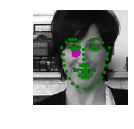

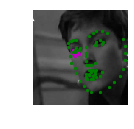

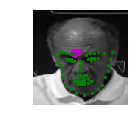

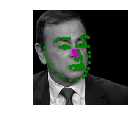

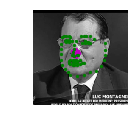

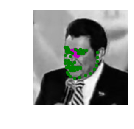

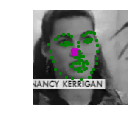

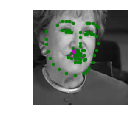

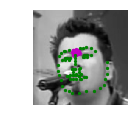

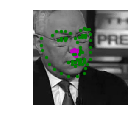

In [99]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [100]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

def train_net(n_epochs):

    # prepare the net for training
    net.train()
    net.cuda()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epoch_i = 0
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        epoch_i += 1
        running_loss = 0.0
        # 每50个epoch保存一次模型
        if epoch_i % 50 == 0:
            # after training, save your model parameters in the dir 'saved_models'
            torch.save(net.state_dict(), model_dir+model_name)

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [20]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.0028560498654842375
Epoch: 1, Batch: 20, Avg. Loss: 0.0029498741328716277


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.0027068848460912705
Epoch: 2, Batch: 20, Avg. Loss: 0.0029324331879615785


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.0026814056634902952
Epoch: 3, Batch: 20, Avg. Loss: 0.0028543290793895722


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0026568153947591783
Epoch: 4, Batch: 20, Avg. Loss: 0.0026538444608449935


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0025707545429468153
Epoch: 5, Batch: 20, Avg. Loss: 0.002458089664578438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0024566031396389006
Epoch: 6, Batch: 20, Avg. Loss: 0.002442281141877174


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.0025324671268463135
Epoch: 7, Batch: 20, Avg. Loss: 0.0025320368111133576


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.002388853222131729
Epoch: 8, Batch: 20, Avg. Loss: 0.002338458612561226


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.002306042343378067
Epoch: 9, Batch: 20, Avg. Loss: 0.0022673700749874116


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.0022919823676347735
Epoch: 10, Batch: 20, Avg. Loss: 0.002379099726676941


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.002302977308630943
Epoch: 11, Batch: 20, Avg. Loss: 0.00230320480465889


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.0022115504741668703
Epoch: 12, Batch: 20, Avg. Loss: 0.0024179570078849792


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.0022130950689315796
Epoch: 13, Batch: 20, Avg. Loss: 0.002085152223706245


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.00214069564640522
Epoch: 14, Batch: 20, Avg. Loss: 0.0020990947484970093


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.0019801883995532988
Epoch: 15, Batch: 20, Avg. Loss: 0.002159790247678757


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.0019400535076856613
Epoch: 16, Batch: 20, Avg. Loss: 0.002092599093914032


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.001949977844953537
Epoch: 17, Batch: 20, Avg. Loss: 0.0020096010714769365


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.002224045231938362
Epoch: 18, Batch: 20, Avg. Loss: 0.0020105479806661604


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.0020219241231679915
Epoch: 19, Batch: 20, Avg. Loss: 0.0018770286440849303


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.0018446007519960404
Epoch: 20, Batch: 20, Avg. Loss: 0.0018347799181938171


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.0019070066958665848
Epoch: 21, Batch: 20, Avg. Loss: 0.0018923055231571198


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.0019671168774366378
Epoch: 22, Batch: 20, Avg. Loss: 0.0019504488408565522


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.0017583916038274765
Epoch: 23, Batch: 20, Avg. Loss: 0.0017351627945899964


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.0017733856737613678
Epoch: 24, Batch: 20, Avg. Loss: 0.0017655843496322632


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.0018232609480619431
Epoch: 25, Batch: 20, Avg. Loss: 0.0018137220293283462


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.0018231658786535263
Epoch: 26, Batch: 20, Avg. Loss: 0.001821910470724106


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.0017023727744817734
Epoch: 27, Batch: 20, Avg. Loss: 0.0016819073110818862


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.0018096677660942079
Epoch: 28, Batch: 20, Avg. Loss: 0.0017797299921512603


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.0016582565307617187
Epoch: 29, Batch: 20, Avg. Loss: 0.0017318829596042634


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.0016646261215209962
Epoch: 30, Batch: 20, Avg. Loss: 0.0016759149730205536


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.001626406565308571
Epoch: 31, Batch: 20, Avg. Loss: 0.0017365046441555024


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.0016083424687385558
Epoch: 32, Batch: 20, Avg. Loss: 0.0016957464516162873


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.0015860790014266969
Epoch: 33, Batch: 20, Avg. Loss: 0.0016107038855552674


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.0015874871611595155
Epoch: 34, Batch: 20, Avg. Loss: 0.0015096778646111488


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.0016001552119851111
Epoch: 35, Batch: 20, Avg. Loss: 0.0016822680085897446


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.0015607856512069702
Epoch: 36, Batch: 20, Avg. Loss: 0.0015408120304346085


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.001565483957529068
Epoch: 37, Batch: 20, Avg. Loss: 0.0015451436489820481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.001578167676925659
Epoch: 38, Batch: 20, Avg. Loss: 0.0014578125774860381


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.0015018517971038818
Epoch: 39, Batch: 20, Avg. Loss: 0.0015011047348380089


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.0015576023012399674
Epoch: 40, Batch: 20, Avg. Loss: 0.0016010582447052002


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.001599371910095215
Epoch: 41, Batch: 20, Avg. Loss: 0.0014532254189252853


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.0014919915944337846
Epoch: 42, Batch: 20, Avg. Loss: 0.0014836091548204422


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.0016151041537523269
Epoch: 43, Batch: 20, Avg. Loss: 0.0014310694634914398


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.001601344332098961
Epoch: 44, Batch: 20, Avg. Loss: 0.00160756516456604


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.0013691212683916091
Epoch: 45, Batch: 20, Avg. Loss: 0.0016397242397069931


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.00139519714564085
Epoch: 46, Batch: 20, Avg. Loss: 0.0016006737276911735


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.0014168707206845283
Epoch: 47, Batch: 20, Avg. Loss: 0.0014024563953280449


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.0014164195656776429
Epoch: 48, Batch: 20, Avg. Loss: 0.0015317604541778564


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.0015552311763167381
Epoch: 49, Batch: 20, Avg. Loss: 0.0014286639243364335


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.0013293781504034995
Epoch: 50, Batch: 20, Avg. Loss: 0.0014123893529176712


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 51, Batch: 10, Avg. Loss: 0.0015140798762440682
Epoch: 51, Batch: 20, Avg. Loss: 0.0013280122950673104


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 52, Batch: 10, Avg. Loss: 0.0012917824164032936
Epoch: 52, Batch: 20, Avg. Loss: 0.0013174947947263717


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 53, Batch: 10, Avg. Loss: 0.001377008982002735
Epoch: 53, Batch: 20, Avg. Loss: 0.0014268791899085045


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 54, Batch: 10, Avg. Loss: 0.0013046355694532395
Epoch: 54, Batch: 20, Avg. Loss: 0.001371964856982231


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 55, Batch: 10, Avg. Loss: 0.0013019686117768288
Epoch: 55, Batch: 20, Avg. Loss: 0.0014059244319796563


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 56, Batch: 10, Avg. Loss: 0.0015562177076935768
Epoch: 56, Batch: 20, Avg. Loss: 0.0013682906925678252


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 57, Batch: 10, Avg. Loss: 0.0014069803878664971
Epoch: 57, Batch: 20, Avg. Loss: 0.0012273464426398278


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 58, Batch: 10, Avg. Loss: 0.0012280844524502753
Epoch: 58, Batch: 20, Avg. Loss: 0.0014652507305145264


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 59, Batch: 10, Avg. Loss: 0.0013456812649965287
Epoch: 59, Batch: 20, Avg. Loss: 0.0013087746500968934


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 60, Batch: 10, Avg. Loss: 0.0012956274598836899
Epoch: 60, Batch: 20, Avg. Loss: 0.0014113499745726586


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 61, Batch: 10, Avg. Loss: 0.0012434351369738578
Epoch: 61, Batch: 20, Avg. Loss: 0.001315987654030323


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 62, Batch: 10, Avg. Loss: 0.0014805356934666633
Epoch: 62, Batch: 20, Avg. Loss: 0.0013336284458637237


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 63, Batch: 10, Avg. Loss: 0.0012902952879667283
Epoch: 63, Batch: 20, Avg. Loss: 0.0013522089347243308


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 64, Batch: 10, Avg. Loss: 0.0013444264978170395
Epoch: 64, Batch: 20, Avg. Loss: 0.0015004777014255525


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 65, Batch: 10, Avg. Loss: 0.0012933666855096818
Epoch: 65, Batch: 20, Avg. Loss: 0.0012734023854136466


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 66, Batch: 10, Avg. Loss: 0.0013403438553214074
Epoch: 66, Batch: 20, Avg. Loss: 0.0014478455409407615


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 67, Batch: 10, Avg. Loss: 0.0012427447885274888
Epoch: 67, Batch: 20, Avg. Loss: 0.0014619719237089156


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 68, Batch: 10, Avg. Loss: 0.0012824491783976555
Epoch: 68, Batch: 20, Avg. Loss: 0.0012911820262670518


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 69, Batch: 10, Avg. Loss: 0.0013186126202344895
Epoch: 69, Batch: 20, Avg. Loss: 0.0013232819885015488


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 70, Batch: 10, Avg. Loss: 0.0013288774862885474
Epoch: 70, Batch: 20, Avg. Loss: 0.0014140636026859284


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 71, Batch: 10, Avg. Loss: 0.0013329108506441117
Epoch: 71, Batch: 20, Avg. Loss: 0.0014172470197081565


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 72, Batch: 10, Avg. Loss: 0.001303826130926609
Epoch: 72, Batch: 20, Avg. Loss: 0.0013418886363506318


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 73, Batch: 10, Avg. Loss: 0.0013076923340559006
Epoch: 73, Batch: 20, Avg. Loss: 0.0012158558592200279


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 74, Batch: 10, Avg. Loss: 0.0011802706494927406
Epoch: 74, Batch: 20, Avg. Loss: 0.0013142454922199249


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 75, Batch: 10, Avg. Loss: 0.001336144246160984
Epoch: 75, Batch: 20, Avg. Loss: 0.0011724561899900436


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 76, Batch: 10, Avg. Loss: 0.0012772142067551612
Epoch: 76, Batch: 20, Avg. Loss: 0.0011967004388570785


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 77, Batch: 10, Avg. Loss: 0.0012627808898687362
Epoch: 77, Batch: 20, Avg. Loss: 0.001204913668334484


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 78, Batch: 10, Avg. Loss: 0.0011317004188895225
Epoch: 78, Batch: 20, Avg. Loss: 0.0011849320605397224


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 79, Batch: 10, Avg. Loss: 0.0011268728151917458
Epoch: 79, Batch: 20, Avg. Loss: 0.0012407566606998444


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 80, Batch: 10, Avg. Loss: 0.00119654381275177
Epoch: 80, Batch: 20, Avg. Loss: 0.0012801261767745019


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 81, Batch: 10, Avg. Loss: 0.0012500682398676871
Epoch: 81, Batch: 20, Avg. Loss: 0.0011987069621682167


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 82, Batch: 10, Avg. Loss: 0.0011718431562185287
Epoch: 82, Batch: 20, Avg. Loss: 0.001182760939002037


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 83, Batch: 10, Avg. Loss: 0.001207287572324276
Epoch: 83, Batch: 20, Avg. Loss: 0.0011424536406993866


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 84, Batch: 10, Avg. Loss: 0.0011146428659558297
Epoch: 84, Batch: 20, Avg. Loss: 0.0013458909541368485


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 85, Batch: 10, Avg. Loss: 0.0012094546556472778
Epoch: 85, Batch: 20, Avg. Loss: 0.0012147074267268181


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 86, Batch: 10, Avg. Loss: 0.0012311238422989844
Epoch: 86, Batch: 20, Avg. Loss: 0.0011644089445471764


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 87, Batch: 10, Avg. Loss: 0.0011468835547566415
Epoch: 87, Batch: 20, Avg. Loss: 0.001127585418522358


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 88, Batch: 10, Avg. Loss: 0.001239806815981865
Epoch: 88, Batch: 20, Avg. Loss: 0.0011839233338832855


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 89, Batch: 10, Avg. Loss: 0.0011854850277304649
Epoch: 89, Batch: 20, Avg. Loss: 0.0011951980590820313


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 90, Batch: 10, Avg. Loss: 0.0011689219027757644
Epoch: 90, Batch: 20, Avg. Loss: 0.0011117741093039514


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 91, Batch: 10, Avg. Loss: 0.0011325488910079002
Epoch: 91, Batch: 20, Avg. Loss: 0.0010908785834908485


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 92, Batch: 10, Avg. Loss: 0.0012713569030165673
Epoch: 92, Batch: 20, Avg. Loss: 0.0012130787298083306


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 93, Batch: 10, Avg. Loss: 0.0013026815131306649
Epoch: 93, Batch: 20, Avg. Loss: 0.0011271377578377724


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 94, Batch: 10, Avg. Loss: 0.0010915739685297013
Epoch: 94, Batch: 20, Avg. Loss: 0.0012339252829551696


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 95, Batch: 10, Avg. Loss: 0.001102712206542492
Epoch: 95, Batch: 20, Avg. Loss: 0.0011323489993810654


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 96, Batch: 10, Avg. Loss: 0.0011410282030701636
Epoch: 96, Batch: 20, Avg. Loss: 0.0011373889297246933


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 97, Batch: 10, Avg. Loss: 0.001154390901327133
Epoch: 97, Batch: 20, Avg. Loss: 0.0011757479012012482


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 98, Batch: 10, Avg. Loss: 0.0010484074503183366
Epoch: 98, Batch: 20, Avg. Loss: 0.0011841514259576798


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 99, Batch: 10, Avg. Loss: 0.0012655718699097634
Epoch: 99, Batch: 20, Avg. Loss: 0.001125014014542103


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 100, Batch: 10, Avg. Loss: 0.0010710904821753502
Epoch: 100, Batch: 20, Avg. Loss: 0.0011048892587423324


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 101, Batch: 10, Avg. Loss: 0.0011422950699925423
Epoch: 101, Batch: 20, Avg. Loss: 0.001097694918513298


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 102, Batch: 10, Avg. Loss: 0.001104298382997513
Epoch: 102, Batch: 20, Avg. Loss: 0.0010744304582476615


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 103, Batch: 10, Avg. Loss: 0.001250858947634697
Epoch: 103, Batch: 20, Avg. Loss: 0.0012095749005675315


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 104, Batch: 10, Avg. Loss: 0.0011911839991807938
Epoch: 104, Batch: 20, Avg. Loss: 0.0010922171100974083


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 105, Batch: 10, Avg. Loss: 0.0012675889059901237
Epoch: 105, Batch: 20, Avg. Loss: 0.0011465736627578734


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 106, Batch: 10, Avg. Loss: 0.0010955899953842164
Epoch: 106, Batch: 20, Avg. Loss: 0.0011651503592729569


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 107, Batch: 10, Avg. Loss: 0.001083938494324684
Epoch: 107, Batch: 20, Avg. Loss: 0.0011157069504261017


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 108, Batch: 10, Avg. Loss: 0.001187617212533951
Epoch: 108, Batch: 20, Avg. Loss: 0.0010459543615579604


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 109, Batch: 10, Avg. Loss: 0.0009355826899409294
Epoch: 109, Batch: 20, Avg. Loss: 0.001105404682457447


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 110, Batch: 10, Avg. Loss: 0.0011212469935417174
Epoch: 110, Batch: 20, Avg. Loss: 0.0011555652096867561


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 111, Batch: 10, Avg. Loss: 0.0011237760856747628
Epoch: 111, Batch: 20, Avg. Loss: 0.0011069469600915908


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 112, Batch: 10, Avg. Loss: 0.001275494322180748
Epoch: 112, Batch: 20, Avg. Loss: 0.0012608116567134858


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 113, Batch: 10, Avg. Loss: 0.0010749922692775726
Epoch: 113, Batch: 20, Avg. Loss: 0.001247000977396965


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 114, Batch: 10, Avg. Loss: 0.0011382426843047143
Epoch: 114, Batch: 20, Avg. Loss: 0.001132891558110714


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 115, Batch: 10, Avg. Loss: 0.0010379872173070907
Epoch: 115, Batch: 20, Avg. Loss: 0.0012425661906599998


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 116, Batch: 10, Avg. Loss: 0.001070636846125126
Epoch: 116, Batch: 20, Avg. Loss: 0.0010172008201479912


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 117, Batch: 10, Avg. Loss: 0.000977492406964302
Epoch: 117, Batch: 20, Avg. Loss: 0.001096204936504364


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 118, Batch: 10, Avg. Loss: 0.0011428357660770417
Epoch: 118, Batch: 20, Avg. Loss: 0.000976235643029213


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 119, Batch: 10, Avg. Loss: 0.0011298343539237975
Epoch: 119, Batch: 20, Avg. Loss: 0.0011675831228494644


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 120, Batch: 10, Avg. Loss: 0.0011122321635484696
Epoch: 120, Batch: 20, Avg. Loss: 0.0010551787242293357


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 121, Batch: 10, Avg. Loss: 0.0011219442188739777
Epoch: 121, Batch: 20, Avg. Loss: 0.001106571227312088


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 122, Batch: 10, Avg. Loss: 0.0011433825492858888
Epoch: 122, Batch: 20, Avg. Loss: 0.001108841173350811


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 123, Batch: 10, Avg. Loss: 0.0010247386321425437
Epoch: 123, Batch: 20, Avg. Loss: 0.0011862888485193253


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 124, Batch: 10, Avg. Loss: 0.0011546298563480377
Epoch: 124, Batch: 20, Avg. Loss: 0.0010508994534611702


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 125, Batch: 10, Avg. Loss: 0.0010279119536280633
Epoch: 125, Batch: 20, Avg. Loss: 0.0010888582542538643


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 126, Batch: 10, Avg. Loss: 0.0010481752306222916
Epoch: 126, Batch: 20, Avg. Loss: 0.0010021249875426293


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 127, Batch: 10, Avg. Loss: 0.0011257873177528382
Epoch: 127, Batch: 20, Avg. Loss: 0.0011173907220363617


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 128, Batch: 10, Avg. Loss: 0.0011364388167858124
Epoch: 128, Batch: 20, Avg. Loss: 0.0011112933978438377


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 129, Batch: 10, Avg. Loss: 0.0009620311632752419
Epoch: 129, Batch: 20, Avg. Loss: 0.0011100285723805428


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 130, Batch: 10, Avg. Loss: 0.001074824556708336
Epoch: 130, Batch: 20, Avg. Loss: 0.0010665542706847192


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 131, Batch: 10, Avg. Loss: 0.001028859369456768
Epoch: 131, Batch: 20, Avg. Loss: 0.0009234300777316094


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 132, Batch: 10, Avg. Loss: 0.0010309505984187127
Epoch: 132, Batch: 20, Avg. Loss: 0.0010698358342051506


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 133, Batch: 10, Avg. Loss: 0.000986066997051239
Epoch: 133, Batch: 20, Avg. Loss: 0.001060164511203766


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 134, Batch: 10, Avg. Loss: 0.0011103237569332124
Epoch: 134, Batch: 20, Avg. Loss: 0.0011592716425657273


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 135, Batch: 10, Avg. Loss: 0.00128828726708889
Epoch: 135, Batch: 20, Avg. Loss: 0.001007908247411251


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 136, Batch: 10, Avg. Loss: 0.0011702839881181717
Epoch: 136, Batch: 20, Avg. Loss: 0.0011840984672307968


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 137, Batch: 10, Avg. Loss: 0.0010380020663142205
Epoch: 137, Batch: 20, Avg. Loss: 0.000946389801800251


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 138, Batch: 10, Avg. Loss: 0.0010262441784143449
Epoch: 138, Batch: 20, Avg. Loss: 0.0010899268239736558


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 139, Batch: 10, Avg. Loss: 0.0009078807756304741
Epoch: 139, Batch: 20, Avg. Loss: 0.0011410852819681168


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 140, Batch: 10, Avg. Loss: 0.0009900143519043923
Epoch: 140, Batch: 20, Avg. Loss: 0.0009694170206785202


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 141, Batch: 10, Avg. Loss: 0.0010406771153211594
Epoch: 141, Batch: 20, Avg. Loss: 0.0011375397592782975


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 142, Batch: 10, Avg. Loss: 0.001171067699790001
Epoch: 142, Batch: 20, Avg. Loss: 0.0010510664880275726


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 143, Batch: 10, Avg. Loss: 0.0010250750109553337
Epoch: 143, Batch: 20, Avg. Loss: 0.0010226983278989793


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 144, Batch: 10, Avg. Loss: 0.0010197313204407693
Epoch: 144, Batch: 20, Avg. Loss: 0.0009818948060274124


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 145, Batch: 10, Avg. Loss: 0.0010763201415538788
Epoch: 145, Batch: 20, Avg. Loss: 0.0010272216722369194


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 146, Batch: 10, Avg. Loss: 0.0010578859597444533
Epoch: 146, Batch: 20, Avg. Loss: 0.001236817680299282


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 147, Batch: 10, Avg. Loss: 0.0010547134950757027
Epoch: 147, Batch: 20, Avg. Loss: 0.0010123031288385392


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 148, Batch: 10, Avg. Loss: 0.001051867328584194
Epoch: 148, Batch: 20, Avg. Loss: 0.0010297030806541443


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 149, Batch: 10, Avg. Loss: 0.0010536220520734787
Epoch: 149, Batch: 20, Avg. Loss: 0.0010219067633152007


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 150, Batch: 10, Avg. Loss: 0.0009814001321792603
Epoch: 150, Batch: 20, Avg. Loss: 0.0010185994654893875


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 151, Batch: 10, Avg. Loss: 0.001012642800807953
Epoch: 151, Batch: 20, Avg. Loss: 0.0009839935675263404


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 152, Batch: 10, Avg. Loss: 0.001049384742975235
Epoch: 152, Batch: 20, Avg. Loss: 0.0009275881126523018


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 153, Batch: 10, Avg. Loss: 0.0010738318413496017
Epoch: 153, Batch: 20, Avg. Loss: 0.0009948362484574317


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 154, Batch: 10, Avg. Loss: 0.0010782056227326394
Epoch: 154, Batch: 20, Avg. Loss: 0.001099326655268669


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 155, Batch: 10, Avg. Loss: 0.0010722179487347603
Epoch: 155, Batch: 20, Avg. Loss: 0.0010932236984372138


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 156, Batch: 10, Avg. Loss: 0.0009999339133501053
Epoch: 156, Batch: 20, Avg. Loss: 0.0009622992575168609


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 157, Batch: 10, Avg. Loss: 0.0009652308449149132
Epoch: 157, Batch: 20, Avg. Loss: 0.0011557687968015672


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 158, Batch: 10, Avg. Loss: 0.0009554212689399719
Epoch: 158, Batch: 20, Avg. Loss: 0.0010391431897878646


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 159, Batch: 10, Avg. Loss: 0.0009396596252918243
Epoch: 159, Batch: 20, Avg. Loss: 0.000986476369202137


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 160, Batch: 10, Avg. Loss: 0.0010136969462037086
Epoch: 160, Batch: 20, Avg. Loss: 0.0009287198558449745


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 161, Batch: 10, Avg. Loss: 0.0008866709247231483
Epoch: 161, Batch: 20, Avg. Loss: 0.0010844854041934012


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 162, Batch: 10, Avg. Loss: 0.0008716301172971726
Epoch: 162, Batch: 20, Avg. Loss: 0.0009543099701404572


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 163, Batch: 10, Avg. Loss: 0.0009779696986079217
Epoch: 163, Batch: 20, Avg. Loss: 0.0012275415137410165


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 164, Batch: 10, Avg. Loss: 0.0008868293315172195
Epoch: 164, Batch: 20, Avg. Loss: 0.0009898988232016563


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 165, Batch: 10, Avg. Loss: 0.0009194182977080345
Epoch: 165, Batch: 20, Avg. Loss: 0.0009306447356939316


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 166, Batch: 10, Avg. Loss: 0.0011538642197847367
Epoch: 166, Batch: 20, Avg. Loss: 0.0010395238548517227


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 167, Batch: 10, Avg. Loss: 0.0009702678546309471
Epoch: 167, Batch: 20, Avg. Loss: 0.0009343848302960396


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 168, Batch: 10, Avg. Loss: 0.0010663425102829932
Epoch: 168, Batch: 20, Avg. Loss: 0.0009656201973557472


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 169, Batch: 10, Avg. Loss: 0.0009386115297675133
Epoch: 169, Batch: 20, Avg. Loss: 0.0009126752316951751


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 170, Batch: 10, Avg. Loss: 0.001001570612192154
Epoch: 170, Batch: 20, Avg. Loss: 0.0010866126045584678


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 171, Batch: 10, Avg. Loss: 0.0009362701922655106
Epoch: 171, Batch: 20, Avg. Loss: 0.0011939037442207337


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 172, Batch: 10, Avg. Loss: 0.0010736097022891044
Epoch: 172, Batch: 20, Avg. Loss: 0.0010609080642461778


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 173, Batch: 10, Avg. Loss: 0.0010118979588150977
Epoch: 173, Batch: 20, Avg. Loss: 0.0008864497989416123


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 174, Batch: 10, Avg. Loss: 0.0009758113026618958
Epoch: 174, Batch: 20, Avg. Loss: 0.0009556844234466553


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 175, Batch: 10, Avg. Loss: 0.0011128718927502631
Epoch: 175, Batch: 20, Avg. Loss: 0.0009611733928322792


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 176, Batch: 10, Avg. Loss: 0.0009574249759316444
Epoch: 176, Batch: 20, Avg. Loss: 0.0010237173214554787


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 177, Batch: 10, Avg. Loss: 0.0010563033223152162
Epoch: 177, Batch: 20, Avg. Loss: 0.0009220055192708969


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 178, Batch: 10, Avg. Loss: 0.0009355289861559868
Epoch: 178, Batch: 20, Avg. Loss: 0.0011814343184232711


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 179, Batch: 10, Avg. Loss: 0.0009560836255550385
Epoch: 179, Batch: 20, Avg. Loss: 0.0010851577818393708


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 180, Batch: 10, Avg. Loss: 0.0009282852113246917
Epoch: 180, Batch: 20, Avg. Loss: 0.0010038243010640144


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 181, Batch: 10, Avg. Loss: 0.0010296212658286094
Epoch: 181, Batch: 20, Avg. Loss: 0.0011541792303323747


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 182, Batch: 10, Avg. Loss: 0.0009178250730037689
Epoch: 182, Batch: 20, Avg. Loss: 0.0009794280081987382


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 183, Batch: 10, Avg. Loss: 0.0008828197792172432
Epoch: 183, Batch: 20, Avg. Loss: 0.0009836204722523689


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 184, Batch: 10, Avg. Loss: 0.0009040508344769478
Epoch: 184, Batch: 20, Avg. Loss: 0.0008915054276585579


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 185, Batch: 10, Avg. Loss: 0.0010423227474093437
Epoch: 185, Batch: 20, Avg. Loss: 0.000995025411248207


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 186, Batch: 10, Avg. Loss: 0.0009598376601934433
Epoch: 186, Batch: 20, Avg. Loss: 0.0009844203367829322


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 187, Batch: 10, Avg. Loss: 0.000941634677350521
Epoch: 187, Batch: 20, Avg. Loss: 0.0011177060157060623


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 188, Batch: 10, Avg. Loss: 0.0009851786345243454
Epoch: 188, Batch: 20, Avg. Loss: 0.0009261082336306572


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 189, Batch: 10, Avg. Loss: 0.0009045296311378479
Epoch: 189, Batch: 20, Avg. Loss: 0.0008976088911294937


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 190, Batch: 10, Avg. Loss: 0.001064477100968361
Epoch: 190, Batch: 20, Avg. Loss: 0.0009784540310502053


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 191, Batch: 10, Avg. Loss: 0.0009084387868642807
Epoch: 191, Batch: 20, Avg. Loss: 0.0010101555660367012


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 192, Batch: 10, Avg. Loss: 0.0009722954854369163
Epoch: 192, Batch: 20, Avg. Loss: 0.000981277883052826


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 193, Batch: 10, Avg. Loss: 0.0009572619870305061
Epoch: 193, Batch: 20, Avg. Loss: 0.0009696553647518158


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 194, Batch: 10, Avg. Loss: 0.0008982741162180901
Epoch: 194, Batch: 20, Avg. Loss: 0.0009588425382971764


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 195, Batch: 10, Avg. Loss: 0.001029112122952938
Epoch: 195, Batch: 20, Avg. Loss: 0.000908753901720047


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 196, Batch: 10, Avg. Loss: 0.000991703860461712
Epoch: 196, Batch: 20, Avg. Loss: 0.0009874523654580117


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 197, Batch: 10, Avg. Loss: 0.0010220008119940758
Epoch: 197, Batch: 20, Avg. Loss: 0.0009076479375362396


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 198, Batch: 10, Avg. Loss: 0.0008929708153009414
Epoch: 198, Batch: 20, Avg. Loss: 0.0010116227567195893


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 199, Batch: 10, Avg. Loss: 0.0008510809019207955
Epoch: 199, Batch: 20, Avg. Loss: 0.001082471877336502


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 200, Batch: 10, Avg. Loss: 0.0008956344649195671
Epoch: 200, Batch: 20, Avg. Loss: 0.0009236442148685455


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 201, Batch: 10, Avg. Loss: 0.000973466619849205
Epoch: 201, Batch: 20, Avg. Loss: 0.0009541684091091156


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 202, Batch: 10, Avg. Loss: 0.0009841115772724152
Epoch: 202, Batch: 20, Avg. Loss: 0.0008825283423066139


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 203, Batch: 10, Avg. Loss: 0.001021388255059719
Epoch: 203, Batch: 20, Avg. Loss: 0.0008816621676087379


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 204, Batch: 10, Avg. Loss: 0.0011376979798078538
Epoch: 204, Batch: 20, Avg. Loss: 0.0010160344168543816


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 205, Batch: 10, Avg. Loss: 0.0008916035592556
Epoch: 205, Batch: 20, Avg. Loss: 0.0010420326590538024


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 206, Batch: 10, Avg. Loss: 0.000858235664665699
Epoch: 206, Batch: 20, Avg. Loss: 0.0009618870541453361


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 207, Batch: 10, Avg. Loss: 0.0009509355053305626
Epoch: 207, Batch: 20, Avg. Loss: 0.0009688195660710335


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 208, Batch: 10, Avg. Loss: 0.0009989449307322503
Epoch: 208, Batch: 20, Avg. Loss: 0.0008940579518675804


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 209, Batch: 10, Avg. Loss: 0.0009757314175367355
Epoch: 209, Batch: 20, Avg. Loss: 0.001024366945028305


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 210, Batch: 10, Avg. Loss: 0.000990684136748314
Epoch: 210, Batch: 20, Avg. Loss: 0.0009251884594559669


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 211, Batch: 10, Avg. Loss: 0.0009202205501496792
Epoch: 211, Batch: 20, Avg. Loss: 0.0009211922213435173


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 212, Batch: 10, Avg. Loss: 0.0009278844371438026
Epoch: 212, Batch: 20, Avg. Loss: 0.0008330932557582856


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 213, Batch: 10, Avg. Loss: 0.0010247208550572394
Epoch: 213, Batch: 20, Avg. Loss: 0.0009513222426176071


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 214, Batch: 10, Avg. Loss: 0.0008395393937826157
Epoch: 214, Batch: 20, Avg. Loss: 0.001049738325178623


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 215, Batch: 10, Avg. Loss: 0.0009294801875948906
Epoch: 215, Batch: 20, Avg. Loss: 0.0008609669096767903


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 216, Batch: 10, Avg. Loss: 0.0009232541993260384
Epoch: 216, Batch: 20, Avg. Loss: 0.001022372283041477


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 217, Batch: 10, Avg. Loss: 0.000853066734969616
Epoch: 217, Batch: 20, Avg. Loss: 0.001003759726881981


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 218, Batch: 10, Avg. Loss: 0.0009722525030374527
Epoch: 218, Batch: 20, Avg. Loss: 0.0009056991785764694


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 219, Batch: 10, Avg. Loss: 0.0008209179639816285
Epoch: 219, Batch: 20, Avg. Loss: 0.0011086968928575515


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 220, Batch: 10, Avg. Loss: 0.0008228436261415482
Epoch: 220, Batch: 20, Avg. Loss: 0.000949097141623497


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 221, Batch: 10, Avg. Loss: 0.0008300650492310525
Epoch: 221, Batch: 20, Avg. Loss: 0.000976085476577282


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 222, Batch: 10, Avg. Loss: 0.0009334928542375564
Epoch: 222, Batch: 20, Avg. Loss: 0.0009397441148757935


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 223, Batch: 10, Avg. Loss: 0.0009112087935209274
Epoch: 223, Batch: 20, Avg. Loss: 0.0008434943780303002


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 224, Batch: 10, Avg. Loss: 0.0009130063876509666
Epoch: 224, Batch: 20, Avg. Loss: 0.0008850274309515953


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 225, Batch: 10, Avg. Loss: 0.0008014372363686562
Epoch: 225, Batch: 20, Avg. Loss: 0.0008989956378936768


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 226, Batch: 10, Avg. Loss: 0.0011134728118777275
Epoch: 226, Batch: 20, Avg. Loss: 0.0009292922839522361


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 227, Batch: 10, Avg. Loss: 0.0009257171005010604
Epoch: 227, Batch: 20, Avg. Loss: 0.0008945010304450988


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 228, Batch: 10, Avg. Loss: 0.0008388525396585464
Epoch: 228, Batch: 20, Avg. Loss: 0.0009620777368545533


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 229, Batch: 10, Avg. Loss: 0.000875137310475111
Epoch: 229, Batch: 20, Avg. Loss: 0.0011486084088683129


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 230, Batch: 10, Avg. Loss: 0.0009711060151457786
Epoch: 230, Batch: 20, Avg. Loss: 0.0010273065268993377


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 231, Batch: 10, Avg. Loss: 0.0010786289423704147
Epoch: 231, Batch: 20, Avg. Loss: 0.00086119344830513


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 232, Batch: 10, Avg. Loss: 0.0009738766923546792
Epoch: 232, Batch: 20, Avg. Loss: 0.0008736177422106267


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 233, Batch: 10, Avg. Loss: 0.0010010546818375588
Epoch: 233, Batch: 20, Avg. Loss: 0.0008877277411520481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 234, Batch: 10, Avg. Loss: 0.0010318092852830887
Epoch: 234, Batch: 20, Avg. Loss: 0.000901171363890171


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 235, Batch: 10, Avg. Loss: 0.0008473401665687561
Epoch: 235, Batch: 20, Avg. Loss: 0.0009127458594739437


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 236, Batch: 10, Avg. Loss: 0.0008474341183900833
Epoch: 236, Batch: 20, Avg. Loss: 0.0008965899422764778


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 237, Batch: 10, Avg. Loss: 0.0008760770484805107
Epoch: 237, Batch: 20, Avg. Loss: 0.0009156012386083603


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 238, Batch: 10, Avg. Loss: 0.0008084913939237594
Epoch: 238, Batch: 20, Avg. Loss: 0.0009089270830154419


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 239, Batch: 10, Avg. Loss: 0.0009451562091708183
Epoch: 239, Batch: 20, Avg. Loss: 0.000842065416276455


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 240, Batch: 10, Avg. Loss: 0.0008570726141333581
Epoch: 240, Batch: 20, Avg. Loss: 0.0008366668820381165


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 241, Batch: 10, Avg. Loss: 0.0010288948863744736
Epoch: 241, Batch: 20, Avg. Loss: 0.0007934694215655327


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 242, Batch: 10, Avg. Loss: 0.0008978729024529457
Epoch: 242, Batch: 20, Avg. Loss: 0.0009610175564885139


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 243, Batch: 10, Avg. Loss: 0.0008529085516929627
Epoch: 243, Batch: 20, Avg. Loss: 0.000839391477406025


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 244, Batch: 10, Avg. Loss: 0.0008571859262883663
Epoch: 244, Batch: 20, Avg. Loss: 0.0008525242879986764


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 245, Batch: 10, Avg. Loss: 0.0010102429613471032
Epoch: 245, Batch: 20, Avg. Loss: 0.0008371544666588306


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 246, Batch: 10, Avg. Loss: 0.0008789063021540642
Epoch: 246, Batch: 20, Avg. Loss: 0.0009371962957084179


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 247, Batch: 10, Avg. Loss: 0.0007952997982501983
Epoch: 247, Batch: 20, Avg. Loss: 0.0008477192744612694


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 248, Batch: 10, Avg. Loss: 0.0010109901130199433
Epoch: 248, Batch: 20, Avg. Loss: 0.0008457811623811722


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 249, Batch: 10, Avg. Loss: 0.0008569715172052384
Epoch: 249, Batch: 20, Avg. Loss: 0.0008514472506940365


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 250, Batch: 10, Avg. Loss: 0.000782079316675663
Epoch: 250, Batch: 20, Avg. Loss: 0.0008661233633756638


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 251, Batch: 10, Avg. Loss: 0.000858297660946846
Epoch: 251, Batch: 20, Avg. Loss: 0.0008458972051739693


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 252, Batch: 10, Avg. Loss: 0.0008213842436671257
Epoch: 252, Batch: 20, Avg. Loss: 0.0008382052406668663


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 253, Batch: 10, Avg. Loss: 0.0009688636288046837
Epoch: 253, Batch: 20, Avg. Loss: 0.0007879058793187142


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 254, Batch: 10, Avg. Loss: 0.0009061717912554741
Epoch: 254, Batch: 20, Avg. Loss: 0.0007997195050120354


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 255, Batch: 10, Avg. Loss: 0.0008586455658078193
Epoch: 255, Batch: 20, Avg. Loss: 0.0009141667783260346


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 256, Batch: 10, Avg. Loss: 0.0008432542756199836
Epoch: 256, Batch: 20, Avg. Loss: 0.000898316964507103


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 257, Batch: 10, Avg. Loss: 0.0008333319351077079
Epoch: 257, Batch: 20, Avg. Loss: 0.0009615488052368164


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 258, Batch: 10, Avg. Loss: 0.0008455148935317993
Epoch: 258, Batch: 20, Avg. Loss: 0.000926594890654087


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 259, Batch: 10, Avg. Loss: 0.0007847954332828522
Epoch: 259, Batch: 20, Avg. Loss: 0.0008663970902562142


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 260, Batch: 10, Avg. Loss: 0.000821328416466713
Epoch: 260, Batch: 20, Avg. Loss: 0.0010400809943675994


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 261, Batch: 10, Avg. Loss: 0.0008642137572169304
Epoch: 261, Batch: 20, Avg. Loss: 0.0008603329211473464


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 262, Batch: 10, Avg. Loss: 0.0008660025596618652
Epoch: 262, Batch: 20, Avg. Loss: 0.000855194367468357


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 263, Batch: 10, Avg. Loss: 0.0009379535540938377
Epoch: 263, Batch: 20, Avg. Loss: 0.0007962634935975074


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 264, Batch: 10, Avg. Loss: 0.0007488368339836597
Epoch: 264, Batch: 20, Avg. Loss: 0.0008297230117022992


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 265, Batch: 10, Avg. Loss: 0.0009319255575537681
Epoch: 265, Batch: 20, Avg. Loss: 0.0008846938237547875


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 266, Batch: 10, Avg. Loss: 0.000995941884815693
Epoch: 266, Batch: 20, Avg. Loss: 0.0008449031710624695


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 267, Batch: 10, Avg. Loss: 0.0007807502672076225
Epoch: 267, Batch: 20, Avg. Loss: 0.0008335597664117814


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 268, Batch: 10, Avg. Loss: 0.0008300790973007679
Epoch: 268, Batch: 20, Avg. Loss: 0.0008342460989952087


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 269, Batch: 10, Avg. Loss: 0.0009099009782075882
Epoch: 269, Batch: 20, Avg. Loss: 0.0008121632412075997


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 270, Batch: 10, Avg. Loss: 0.0007976571694016456
Epoch: 270, Batch: 20, Avg. Loss: 0.0007727415598928929


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 271, Batch: 10, Avg. Loss: 0.0007534135393798352
Epoch: 271, Batch: 20, Avg. Loss: 0.0009720451757311822


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 272, Batch: 10, Avg. Loss: 0.0007419310696423054
Epoch: 272, Batch: 20, Avg. Loss: 0.0007813241183757782


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 273, Batch: 10, Avg. Loss: 0.000812776580452919
Epoch: 273, Batch: 20, Avg. Loss: 0.0008375458084046841


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 274, Batch: 10, Avg. Loss: 0.0007872034758329391
Epoch: 274, Batch: 20, Avg. Loss: 0.0009517809897661209


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 275, Batch: 10, Avg. Loss: 0.0007505637742578983
Epoch: 275, Batch: 20, Avg. Loss: 0.000872539721429348


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 276, Batch: 10, Avg. Loss: 0.0008025062046945095
Epoch: 276, Batch: 20, Avg. Loss: 0.0009595706313848495


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 277, Batch: 10, Avg. Loss: 0.0007660755515098572
Epoch: 277, Batch: 20, Avg. Loss: 0.0008488379940390587


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 278, Batch: 10, Avg. Loss: 0.0008271004781126976
Epoch: 278, Batch: 20, Avg. Loss: 0.000875604547560215


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 279, Batch: 10, Avg. Loss: 0.0007781272493302822
Epoch: 279, Batch: 20, Avg. Loss: 0.0008417843654751777


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 280, Batch: 10, Avg. Loss: 0.0008053350001573562
Epoch: 280, Batch: 20, Avg. Loss: 0.0009694921970367431


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 281, Batch: 10, Avg. Loss: 0.0009046791270375252
Epoch: 281, Batch: 20, Avg. Loss: 0.0009043789729475975


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 282, Batch: 10, Avg. Loss: 0.0007763749435544014
Epoch: 282, Batch: 20, Avg. Loss: 0.0008319184184074402


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 283, Batch: 10, Avg. Loss: 0.0008652666844427586
Epoch: 283, Batch: 20, Avg. Loss: 0.0009387024119496346


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 284, Batch: 10, Avg. Loss: 0.0007969055324792862
Epoch: 284, Batch: 20, Avg. Loss: 0.0008247831538319587


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 285, Batch: 10, Avg. Loss: 0.0007823037207126618
Epoch: 285, Batch: 20, Avg. Loss: 0.0008848054260015487


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 286, Batch: 10, Avg. Loss: 0.0007857023477554321
Epoch: 286, Batch: 20, Avg. Loss: 0.0008271038010716438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 287, Batch: 10, Avg. Loss: 0.000786807544529438
Epoch: 287, Batch: 20, Avg. Loss: 0.0008578549548983573


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 288, Batch: 10, Avg. Loss: 0.0007770830765366554
Epoch: 288, Batch: 20, Avg. Loss: 0.0008689371049404144


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 289, Batch: 10, Avg. Loss: 0.0007847707718610763
Epoch: 289, Batch: 20, Avg. Loss: 0.0008437870740890502


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 290, Batch: 10, Avg. Loss: 0.0008820258863270283
Epoch: 290, Batch: 20, Avg. Loss: 0.0008339871913194656


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 291, Batch: 10, Avg. Loss: 0.0008444899767637253
Epoch: 291, Batch: 20, Avg. Loss: 0.0008095137178897858


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 292, Batch: 10, Avg. Loss: 0.0008837687224149703
Epoch: 292, Batch: 20, Avg. Loss: 0.0007658334746956826


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 293, Batch: 10, Avg. Loss: 0.000787262998521328
Epoch: 293, Batch: 20, Avg. Loss: 0.0008749976605176926


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 294, Batch: 10, Avg. Loss: 0.000769124336540699
Epoch: 294, Batch: 20, Avg. Loss: 0.0009077910482883454


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 295, Batch: 10, Avg. Loss: 0.0007903481796383857
Epoch: 295, Batch: 20, Avg. Loss: 0.0007448127418756484


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 296, Batch: 10, Avg. Loss: 0.0007458990067243576
Epoch: 296, Batch: 20, Avg. Loss: 0.0008465627655386925


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 297, Batch: 10, Avg. Loss: 0.0008529326170682907
Epoch: 297, Batch: 20, Avg. Loss: 0.0008898658230900764


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 298, Batch: 10, Avg. Loss: 0.0009765012040734291
Epoch: 298, Batch: 20, Avg. Loss: 0.0007392858043313026


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 299, Batch: 10, Avg. Loss: 0.0008312266990542412
Epoch: 299, Batch: 20, Avg. Loss: 0.0008503142036497593


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 300, Batch: 10, Avg. Loss: 0.0008820980601012706
Epoch: 300, Batch: 20, Avg. Loss: 0.0008568314127624035


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 301, Batch: 10, Avg. Loss: 0.0008217210918664932
Epoch: 301, Batch: 20, Avg. Loss: 0.0007882132120430469


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 302, Batch: 10, Avg. Loss: 0.0008328430615365505
Epoch: 302, Batch: 20, Avg. Loss: 0.0007556344754993915


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 303, Batch: 10, Avg. Loss: 0.0007996556833386421
Epoch: 303, Batch: 20, Avg. Loss: 0.0007963829934597015


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 304, Batch: 10, Avg. Loss: 0.0008865409083664418
Epoch: 304, Batch: 20, Avg. Loss: 0.0008598399758338928


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 305, Batch: 10, Avg. Loss: 0.0008249386921525001
Epoch: 305, Batch: 20, Avg. Loss: 0.000761920128017664


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 306, Batch: 10, Avg. Loss: 0.0007650201879441738
Epoch: 306, Batch: 20, Avg. Loss: 0.0007917573638260365


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 307, Batch: 10, Avg. Loss: 0.0008936046510934829
Epoch: 307, Batch: 20, Avg. Loss: 0.0008047988340258598


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 308, Batch: 10, Avg. Loss: 0.0007192757129669189
Epoch: 308, Batch: 20, Avg. Loss: 0.000838214248418808


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 309, Batch: 10, Avg. Loss: 0.000813762079924345
Epoch: 309, Batch: 20, Avg. Loss: 0.0008469399735331535


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 310, Batch: 10, Avg. Loss: 0.0007621866688132286
Epoch: 310, Batch: 20, Avg. Loss: 0.0007629076316952706


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 311, Batch: 10, Avg. Loss: 0.0008223706819117069
Epoch: 311, Batch: 20, Avg. Loss: 0.0008331013098359108


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 312, Batch: 10, Avg. Loss: 0.000967136237770319
Epoch: 312, Batch: 20, Avg. Loss: 0.0008018008954823017


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 313, Batch: 10, Avg. Loss: 0.0008759163655340671
Epoch: 313, Batch: 20, Avg. Loss: 0.0007441139034926891


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 314, Batch: 10, Avg. Loss: 0.0007955421470105648
Epoch: 314, Batch: 20, Avg. Loss: 0.0007718782648444176


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 315, Batch: 10, Avg. Loss: 0.0008333080969750882
Epoch: 315, Batch: 20, Avg. Loss: 0.0007989754974842072


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 316, Batch: 10, Avg. Loss: 0.0007265100590884686
Epoch: 316, Batch: 20, Avg. Loss: 0.0009456727243959904


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 317, Batch: 10, Avg. Loss: 0.0008313805200159549
Epoch: 317, Batch: 20, Avg. Loss: 0.0008619189150631428


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 318, Batch: 10, Avg. Loss: 0.0008913599625229835
Epoch: 318, Batch: 20, Avg. Loss: 0.0008182133212685584


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 319, Batch: 10, Avg. Loss: 0.0008318586349487305
Epoch: 319, Batch: 20, Avg. Loss: 0.0008655126355588436


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 320, Batch: 10, Avg. Loss: 0.0008254270479083061
Epoch: 320, Batch: 20, Avg. Loss: 0.0007539896033704281


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 321, Batch: 10, Avg. Loss: 0.00090725876390934
Epoch: 321, Batch: 20, Avg. Loss: 0.0007375755533576011


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 322, Batch: 10, Avg. Loss: 0.0007630649358034134
Epoch: 322, Batch: 20, Avg. Loss: 0.0008429530411958694


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 323, Batch: 10, Avg. Loss: 0.0009530409052968025
Epoch: 323, Batch: 20, Avg. Loss: 0.000774758294224739


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 324, Batch: 10, Avg. Loss: 0.0008018582314252853
Epoch: 324, Batch: 20, Avg. Loss: 0.0007659044601023197


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 325, Batch: 10, Avg. Loss: 0.0007479882352054119
Epoch: 325, Batch: 20, Avg. Loss: 0.0008002279885113239


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 326, Batch: 10, Avg. Loss: 0.0007157500050961971
Epoch: 326, Batch: 20, Avg. Loss: 0.0009736878722906113


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 327, Batch: 10, Avg. Loss: 0.0007407985776662826
Epoch: 327, Batch: 20, Avg. Loss: 0.0009076733067631722


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 328, Batch: 10, Avg. Loss: 0.0007973890751600266
Epoch: 328, Batch: 20, Avg. Loss: 0.0008461825624108315


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 329, Batch: 10, Avg. Loss: 0.0008417487666010857
Epoch: 329, Batch: 20, Avg. Loss: 0.0007401352748274803


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 330, Batch: 10, Avg. Loss: 0.0007748926170170307
Epoch: 330, Batch: 20, Avg. Loss: 0.0009082178473472595


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 331, Batch: 10, Avg. Loss: 0.0007221370041370392
Epoch: 331, Batch: 20, Avg. Loss: 0.0007618540041148663


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 332, Batch: 10, Avg. Loss: 0.000812926147133112
Epoch: 332, Batch: 20, Avg. Loss: 0.0008862571492791176


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 333, Batch: 10, Avg. Loss: 0.0007768035754561424
Epoch: 333, Batch: 20, Avg. Loss: 0.0007747829109430313


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 334, Batch: 10, Avg. Loss: 0.000795928955078125
Epoch: 334, Batch: 20, Avg. Loss: 0.0007873392403125763


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 335, Batch: 10, Avg. Loss: 0.0006847785450518131
Epoch: 335, Batch: 20, Avg. Loss: 0.0007851094640791416


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 336, Batch: 10, Avg. Loss: 0.0007113019973039627
Epoch: 336, Batch: 20, Avg. Loss: 0.0007538053840398789


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 337, Batch: 10, Avg. Loss: 0.0008904576785862446
Epoch: 337, Batch: 20, Avg. Loss: 0.000782447624951601


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 338, Batch: 10, Avg. Loss: 0.0008329583182930946
Epoch: 338, Batch: 20, Avg. Loss: 0.0007610683366656303


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 339, Batch: 10, Avg. Loss: 0.0008077512085437775
Epoch: 339, Batch: 20, Avg. Loss: 0.0007268028594553471


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 340, Batch: 10, Avg. Loss: 0.0007629645764827728
Epoch: 340, Batch: 20, Avg. Loss: 0.0009022632800042629


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 341, Batch: 10, Avg. Loss: 0.0007912875227630139
Epoch: 341, Batch: 20, Avg. Loss: 0.0007336294278502464


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 342, Batch: 10, Avg. Loss: 0.0007385410368442536
Epoch: 342, Batch: 20, Avg. Loss: 0.0007639994621276855


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 343, Batch: 10, Avg. Loss: 0.0007947576902806759
Epoch: 343, Batch: 20, Avg. Loss: 0.000762172281742096


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 344, Batch: 10, Avg. Loss: 0.0007399177104234695
Epoch: 344, Batch: 20, Avg. Loss: 0.0008419643603265285


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 345, Batch: 10, Avg. Loss: 0.0009115731567144394
Epoch: 345, Batch: 20, Avg. Loss: 0.0007563313245773315


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 346, Batch: 10, Avg. Loss: 0.000801758386194706
Epoch: 346, Batch: 20, Avg. Loss: 0.0008058186173439026


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 347, Batch: 10, Avg. Loss: 0.0008344048671424389
Epoch: 347, Batch: 20, Avg. Loss: 0.0007839736863970757


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 348, Batch: 10, Avg. Loss: 0.0007504337280988693
Epoch: 348, Batch: 20, Avg. Loss: 0.0007195975854992866


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 349, Batch: 10, Avg. Loss: 0.0008179462440311908
Epoch: 349, Batch: 20, Avg. Loss: 0.0007518617063760757


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 350, Batch: 10, Avg. Loss: 0.0009744039811193943
Epoch: 350, Batch: 20, Avg. Loss: 0.0007522503696382046


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 351, Batch: 10, Avg. Loss: 0.0008431146144866943
Epoch: 351, Batch: 20, Avg. Loss: 0.000752190075814724


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 352, Batch: 10, Avg. Loss: 0.0008236980810761451
Epoch: 352, Batch: 20, Avg. Loss: 0.000757116436958313


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 353, Batch: 10, Avg. Loss: 0.0008435294777154923
Epoch: 353, Batch: 20, Avg. Loss: 0.0007194933667778969


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 354, Batch: 10, Avg. Loss: 0.0006951356679201126
Epoch: 354, Batch: 20, Avg. Loss: 0.0007674588486552238


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 355, Batch: 10, Avg. Loss: 0.0006650076732039452
Epoch: 355, Batch: 20, Avg. Loss: 0.0009000841528177261


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 356, Batch: 10, Avg. Loss: 0.0007336641661822796
Epoch: 356, Batch: 20, Avg. Loss: 0.0007198558524250984


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 357, Batch: 10, Avg. Loss: 0.0006978966929018498
Epoch: 357, Batch: 20, Avg. Loss: 0.0007465437799692154


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 358, Batch: 10, Avg. Loss: 0.000841070219874382
Epoch: 358, Batch: 20, Avg. Loss: 0.0007762699499726295


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 359, Batch: 10, Avg. Loss: 0.0007393030934035778
Epoch: 359, Batch: 20, Avg. Loss: 0.0007942509949207306


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 360, Batch: 10, Avg. Loss: 0.0006812307946383953
Epoch: 360, Batch: 20, Avg. Loss: 0.0009530809260904789


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 361, Batch: 10, Avg. Loss: 0.0007988703511655331
Epoch: 361, Batch: 20, Avg. Loss: 0.0007113120965659618


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 362, Batch: 10, Avg. Loss: 0.000832814484834671
Epoch: 362, Batch: 20, Avg. Loss: 0.000846460111439228


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 363, Batch: 10, Avg. Loss: 0.0007446574233472347
Epoch: 363, Batch: 20, Avg. Loss: 0.0007941429615020752


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 364, Batch: 10, Avg. Loss: 0.0006953646466135979
Epoch: 364, Batch: 20, Avg. Loss: 0.0010618642270565032


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 365, Batch: 10, Avg. Loss: 0.0007533113174140453
Epoch: 365, Batch: 20, Avg. Loss: 0.0007894149906933308


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 366, Batch: 10, Avg. Loss: 0.0007536600828170776
Epoch: 366, Batch: 20, Avg. Loss: 0.0006979227624833584


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 367, Batch: 10, Avg. Loss: 0.0007256615161895752
Epoch: 367, Batch: 20, Avg. Loss: 0.0009875697530806065


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 368, Batch: 10, Avg. Loss: 0.0007968327328562736
Epoch: 368, Batch: 20, Avg. Loss: 0.0007694602124392986


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 369, Batch: 10, Avg. Loss: 0.0008071849383413792
Epoch: 369, Batch: 20, Avg. Loss: 0.000717877309769392


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 370, Batch: 10, Avg. Loss: 0.0006271086409687995
Epoch: 370, Batch: 20, Avg. Loss: 0.0008193917758762836


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 371, Batch: 10, Avg. Loss: 0.0006706393584609032
Epoch: 371, Batch: 20, Avg. Loss: 0.0008105389699339866


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 372, Batch: 10, Avg. Loss: 0.0007451437152922153
Epoch: 372, Batch: 20, Avg. Loss: 0.0007686645910143852


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 373, Batch: 10, Avg. Loss: 0.0008100210689008236
Epoch: 373, Batch: 20, Avg. Loss: 0.0007258140780031681


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 374, Batch: 10, Avg. Loss: 0.0008386509157717228
Epoch: 374, Batch: 20, Avg. Loss: 0.0007198846600949765


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 375, Batch: 10, Avg. Loss: 0.0007937916181981564
Epoch: 375, Batch: 20, Avg. Loss: 0.0007952448651194573


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 376, Batch: 10, Avg. Loss: 0.0007873240783810616
Epoch: 376, Batch: 20, Avg. Loss: 0.0007750278115272522


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 377, Batch: 10, Avg. Loss: 0.0006962381228804588
Epoch: 377, Batch: 20, Avg. Loss: 0.0007880724892020225


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 378, Batch: 10, Avg. Loss: 0.0007653283923864365
Epoch: 378, Batch: 20, Avg. Loss: 0.0007451367117464543


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 379, Batch: 10, Avg. Loss: 0.0007563216276466846
Epoch: 379, Batch: 20, Avg. Loss: 0.0007154976464807987


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 380, Batch: 10, Avg. Loss: 0.0007985217459499836
Epoch: 380, Batch: 20, Avg. Loss: 0.0006935370229184627


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 381, Batch: 10, Avg. Loss: 0.0006596067808568478
Epoch: 381, Batch: 20, Avg. Loss: 0.0008253550976514816


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 382, Batch: 10, Avg. Loss: 0.0007546949237585067
Epoch: 382, Batch: 20, Avg. Loss: 0.0006750521585345269


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 383, Batch: 10, Avg. Loss: 0.000688470508903265
Epoch: 383, Batch: 20, Avg. Loss: 0.0007448043935000897


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 384, Batch: 10, Avg. Loss: 0.0008908012732863427
Epoch: 384, Batch: 20, Avg. Loss: 0.0007346814833581448


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 385, Batch: 10, Avg. Loss: 0.0009294257164001465
Epoch: 385, Batch: 20, Avg. Loss: 0.0007324865311384201


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 386, Batch: 10, Avg. Loss: 0.0006471294201910496
Epoch: 386, Batch: 20, Avg. Loss: 0.000678885217756033


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 387, Batch: 10, Avg. Loss: 0.0007273714989423751
Epoch: 387, Batch: 20, Avg. Loss: 0.0006857017502188683


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 388, Batch: 10, Avg. Loss: 0.000729673758149147
Epoch: 388, Batch: 20, Avg. Loss: 0.0007482682354748249


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 389, Batch: 10, Avg. Loss: 0.0007932471521198749
Epoch: 389, Batch: 20, Avg. Loss: 0.000804567739367485


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 390, Batch: 10, Avg. Loss: 0.0008402683772146702
Epoch: 390, Batch: 20, Avg. Loss: 0.0006960722729563713


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 391, Batch: 10, Avg. Loss: 0.00072340914234519
Epoch: 391, Batch: 20, Avg. Loss: 0.0008677650652825832


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 392, Batch: 10, Avg. Loss: 0.0007475787326693535
Epoch: 392, Batch: 20, Avg. Loss: 0.000712200615555048


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 393, Batch: 10, Avg. Loss: 0.000943050604313612
Epoch: 393, Batch: 20, Avg. Loss: 0.0007820424363017082


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 394, Batch: 10, Avg. Loss: 0.0008732915483415127
Epoch: 394, Batch: 20, Avg. Loss: 0.0007480729222297669


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 395, Batch: 10, Avg. Loss: 0.0007304455116391181
Epoch: 395, Batch: 20, Avg. Loss: 0.000776349164545536


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 396, Batch: 10, Avg. Loss: 0.0006925789266824722
Epoch: 396, Batch: 20, Avg. Loss: 0.0007621603384613991


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 397, Batch: 10, Avg. Loss: 0.0006938850097358227
Epoch: 397, Batch: 20, Avg. Loss: 0.0006383444555103779


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 398, Batch: 10, Avg. Loss: 0.0007783657610416412
Epoch: 398, Batch: 20, Avg. Loss: 0.0007201360911130905


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 399, Batch: 10, Avg. Loss: 0.0009500134624540805
Epoch: 399, Batch: 20, Avg. Loss: 0.0007972272261977196


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 400, Batch: 10, Avg. Loss: 0.0006955606378614902
Epoch: 400, Batch: 20, Avg. Loss: 0.0008845959007740021


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 401, Batch: 10, Avg. Loss: 0.0007943352088332176
Epoch: 401, Batch: 20, Avg. Loss: 0.0007551287114620209


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 402, Batch: 10, Avg. Loss: 0.0007914939522743225
Epoch: 402, Batch: 20, Avg. Loss: 0.0007387451082468033


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 403, Batch: 10, Avg. Loss: 0.0006292311288416386
Epoch: 403, Batch: 20, Avg. Loss: 0.0007099175639450551


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 404, Batch: 10, Avg. Loss: 0.0006819981932640076
Epoch: 404, Batch: 20, Avg. Loss: 0.000736182726919651


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 405, Batch: 10, Avg. Loss: 0.000837804764509201
Epoch: 405, Batch: 20, Avg. Loss: 0.0007447215281426907


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 406, Batch: 10, Avg. Loss: 0.0007019527293741703
Epoch: 406, Batch: 20, Avg. Loss: 0.0006511484868824481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 407, Batch: 10, Avg. Loss: 0.0008275850936770439
Epoch: 407, Batch: 20, Avg. Loss: 0.0006204840615391731


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 408, Batch: 10, Avg. Loss: 0.000758901309221983
Epoch: 408, Batch: 20, Avg. Loss: 0.000718791738152504


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 409, Batch: 10, Avg. Loss: 0.0007748793736100197
Epoch: 409, Batch: 20, Avg. Loss: 0.0007334528863430024


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 410, Batch: 10, Avg. Loss: 0.000682443205267191
Epoch: 410, Batch: 20, Avg. Loss: 0.0007897009700536728


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 411, Batch: 10, Avg. Loss: 0.0007654169425368309
Epoch: 411, Batch: 20, Avg. Loss: 0.0009380917660892009


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 412, Batch: 10, Avg. Loss: 0.000713019248098135
Epoch: 412, Batch: 20, Avg. Loss: 0.0006987421922385693


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 413, Batch: 10, Avg. Loss: 0.0007381160110235214
Epoch: 413, Batch: 20, Avg. Loss: 0.0007808940596878528


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 414, Batch: 10, Avg. Loss: 0.0007875074036419392
Epoch: 414, Batch: 20, Avg. Loss: 0.0007185508795082569


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 415, Batch: 10, Avg. Loss: 0.0006815967597067356
Epoch: 415, Batch: 20, Avg. Loss: 0.0007374886572360992


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 416, Batch: 10, Avg. Loss: 0.00067625767365098
Epoch: 416, Batch: 20, Avg. Loss: 0.0007640101537108421


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 417, Batch: 10, Avg. Loss: 0.0006648427732288837
Epoch: 417, Batch: 20, Avg. Loss: 0.0007537824809551239


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 418, Batch: 10, Avg. Loss: 0.0006465726941823959
Epoch: 418, Batch: 20, Avg. Loss: 0.0006616072580218315


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 419, Batch: 10, Avg. Loss: 0.0007538951933383942
Epoch: 419, Batch: 20, Avg. Loss: 0.0006772727109491825


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 420, Batch: 10, Avg. Loss: 0.000698355782777071
Epoch: 420, Batch: 20, Avg. Loss: 0.0007169165089726448


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 421, Batch: 10, Avg. Loss: 0.0008343904092907906
Epoch: 421, Batch: 20, Avg. Loss: 0.000729998517781496


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 422, Batch: 10, Avg. Loss: 0.0007029784061014652
Epoch: 422, Batch: 20, Avg. Loss: 0.0007086288519203663


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 423, Batch: 10, Avg. Loss: 0.0008306109756231307
Epoch: 423, Batch: 20, Avg. Loss: 0.0007796284705400467


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 424, Batch: 10, Avg. Loss: 0.0007653643265366554
Epoch: 424, Batch: 20, Avg. Loss: 0.0006748759113252163


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 425, Batch: 10, Avg. Loss: 0.0006660573780536652
Epoch: 425, Batch: 20, Avg. Loss: 0.0006520148366689682


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 426, Batch: 10, Avg. Loss: 0.0007447302155196667
Epoch: 426, Batch: 20, Avg. Loss: 0.0006711899675428867


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 427, Batch: 10, Avg. Loss: 0.0008166431412100791
Epoch: 427, Batch: 20, Avg. Loss: 0.0007770575731992722


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 428, Batch: 10, Avg. Loss: 0.0006534751355648041
Epoch: 428, Batch: 20, Avg. Loss: 0.000952521987259388


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 429, Batch: 10, Avg. Loss: 0.0008532006777822971
Epoch: 429, Batch: 20, Avg. Loss: 0.0006697333343327046


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 430, Batch: 10, Avg. Loss: 0.0007271941527724266
Epoch: 430, Batch: 20, Avg. Loss: 0.0006705104149878025


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 431, Batch: 10, Avg. Loss: 0.0007282166108489036
Epoch: 431, Batch: 20, Avg. Loss: 0.0007669478468596935


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 432, Batch: 10, Avg. Loss: 0.0007445360198616982
Epoch: 432, Batch: 20, Avg. Loss: 0.000761596865952015


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 433, Batch: 10, Avg. Loss: 0.0008718027323484421
Epoch: 433, Batch: 20, Avg. Loss: 0.0006977319084107876


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 434, Batch: 10, Avg. Loss: 0.0006952201612293721
Epoch: 434, Batch: 20, Avg. Loss: 0.0008027188368141651


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 435, Batch: 10, Avg. Loss: 0.0006521907784044742
Epoch: 435, Batch: 20, Avg. Loss: 0.0007214422114193439


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 436, Batch: 10, Avg. Loss: 0.0009349340312182903
Epoch: 436, Batch: 20, Avg. Loss: 0.0008243315368890763


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 437, Batch: 10, Avg. Loss: 0.0006428367383778096
Epoch: 437, Batch: 20, Avg. Loss: 0.0007812239900231361


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 438, Batch: 10, Avg. Loss: 0.0007145414240658283
Epoch: 438, Batch: 20, Avg. Loss: 0.00074361177906394


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 439, Batch: 10, Avg. Loss: 0.0007014118954539298
Epoch: 439, Batch: 20, Avg. Loss: 0.0007670707888901234


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 440, Batch: 10, Avg. Loss: 0.0007570565491914749
Epoch: 440, Batch: 20, Avg. Loss: 0.0006841757483780384


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 441, Batch: 10, Avg. Loss: 0.0006637025102972984
Epoch: 441, Batch: 20, Avg. Loss: 0.0007525522075593472


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 442, Batch: 10, Avg. Loss: 0.0006484275795519352
Epoch: 442, Batch: 20, Avg. Loss: 0.000698613878339529


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 443, Batch: 10, Avg. Loss: 0.0006342670954763889
Epoch: 443, Batch: 20, Avg. Loss: 0.0007542009949684143


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 444, Batch: 10, Avg. Loss: 0.0006334866322576999
Epoch: 444, Batch: 20, Avg. Loss: 0.0008160575106739997


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 445, Batch: 10, Avg. Loss: 0.0007087643705308437
Epoch: 445, Batch: 20, Avg. Loss: 0.0006932414844632149


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 446, Batch: 10, Avg. Loss: 0.0006989889815449715
Epoch: 446, Batch: 20, Avg. Loss: 0.0007265641316771507


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 447, Batch: 10, Avg. Loss: 0.0007751022316515446
Epoch: 447, Batch: 20, Avg. Loss: 0.0007298401407897472


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 448, Batch: 10, Avg. Loss: 0.0006193532571196556
Epoch: 448, Batch: 20, Avg. Loss: 0.0008335482366383076


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 449, Batch: 10, Avg. Loss: 0.0006897057294845581
Epoch: 449, Batch: 20, Avg. Loss: 0.0008373123854398727


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 450, Batch: 10, Avg. Loss: 0.0007042515650391579
Epoch: 450, Batch: 20, Avg. Loss: 0.0008260924182832241


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 451, Batch: 10, Avg. Loss: 0.0006409194171428681
Epoch: 451, Batch: 20, Avg. Loss: 0.0006426294222474098


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 452, Batch: 10, Avg. Loss: 0.0008212087638676166
Epoch: 452, Batch: 20, Avg. Loss: 0.000676308423280716


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 453, Batch: 10, Avg. Loss: 0.0006454655043780803
Epoch: 453, Batch: 20, Avg. Loss: 0.0006660486347973346


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 454, Batch: 10, Avg. Loss: 0.0007092150859534741
Epoch: 454, Batch: 20, Avg. Loss: 0.0006911253295838833


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 455, Batch: 10, Avg. Loss: 0.0006989065073430539
Epoch: 455, Batch: 20, Avg. Loss: 0.0007621714398264885


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 456, Batch: 10, Avg. Loss: 0.0006836958192288875
Epoch: 456, Batch: 20, Avg. Loss: 0.0007682161778211593


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 457, Batch: 10, Avg. Loss: 0.0009823596067726611
Epoch: 457, Batch: 20, Avg. Loss: 0.0006533698998391628


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 458, Batch: 10, Avg. Loss: 0.0006370965763926506
Epoch: 458, Batch: 20, Avg. Loss: 0.0007274237833917141


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 459, Batch: 10, Avg. Loss: 0.0006521805077791214
Epoch: 459, Batch: 20, Avg. Loss: 0.000673699751496315


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 460, Batch: 10, Avg. Loss: 0.0007247031666338444
Epoch: 460, Batch: 20, Avg. Loss: 0.0008257894515991211


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 461, Batch: 10, Avg. Loss: 0.0007077505141496658
Epoch: 461, Batch: 20, Avg. Loss: 0.0007262646220624446


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 462, Batch: 10, Avg. Loss: 0.0006246135793626309
Epoch: 462, Batch: 20, Avg. Loss: 0.0007287774458527565


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 463, Batch: 10, Avg. Loss: 0.0006203291676938534
Epoch: 463, Batch: 20, Avg. Loss: 0.0006987506933510304


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 464, Batch: 10, Avg. Loss: 0.0006615209616720677
Epoch: 464, Batch: 20, Avg. Loss: 0.0006630307585000992


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 465, Batch: 10, Avg. Loss: 0.0007431133091449737
Epoch: 465, Batch: 20, Avg. Loss: 0.000693617582321167


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 466, Batch: 10, Avg. Loss: 0.00064174659922719
Epoch: 466, Batch: 20, Avg. Loss: 0.0006435771584510804


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 467, Batch: 10, Avg. Loss: 0.0006299837157130241
Epoch: 467, Batch: 20, Avg. Loss: 0.0007067299522459507


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 468, Batch: 10, Avg. Loss: 0.000722192894667387
Epoch: 468, Batch: 20, Avg. Loss: 0.0006984796151518821


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 469, Batch: 10, Avg. Loss: 0.000705285906791687
Epoch: 469, Batch: 20, Avg. Loss: 0.0007292172387242317


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 470, Batch: 10, Avg. Loss: 0.0007496061623096466
Epoch: 470, Batch: 20, Avg. Loss: 0.000658428430557251


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 471, Batch: 10, Avg. Loss: 0.0006922796294093132
Epoch: 471, Batch: 20, Avg. Loss: 0.000808685190975666


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 472, Batch: 10, Avg. Loss: 0.0006805702149868012
Epoch: 472, Batch: 20, Avg. Loss: 0.000638644203543663


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 473, Batch: 10, Avg. Loss: 0.0007127922326326371
Epoch: 473, Batch: 20, Avg. Loss: 0.0006363331079483032


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 474, Batch: 10, Avg. Loss: 0.0007406457960605621
Epoch: 474, Batch: 20, Avg. Loss: 0.0006951943598687649


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 475, Batch: 10, Avg. Loss: 0.0007097170688211918
Epoch: 475, Batch: 20, Avg. Loss: 0.0006256605237722397


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 476, Batch: 10, Avg. Loss: 0.0006782750897109509
Epoch: 476, Batch: 20, Avg. Loss: 0.0007342620901763439


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 477, Batch: 10, Avg. Loss: 0.0006458935737609863
Epoch: 477, Batch: 20, Avg. Loss: 0.0007169483974575996


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 478, Batch: 10, Avg. Loss: 0.0006913551539182663
Epoch: 478, Batch: 20, Avg. Loss: 0.0007625522501766681


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 479, Batch: 10, Avg. Loss: 0.0006714083440601825
Epoch: 479, Batch: 20, Avg. Loss: 0.000750189445912838


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 480, Batch: 10, Avg. Loss: 0.0006555325910449028
Epoch: 480, Batch: 20, Avg. Loss: 0.0007174116931855678


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 481, Batch: 10, Avg. Loss: 0.000758984625339508
Epoch: 481, Batch: 20, Avg. Loss: 0.000892002921551466


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 482, Batch: 10, Avg. Loss: 0.0007302521951496601
Epoch: 482, Batch: 20, Avg. Loss: 0.0007098396345973014


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 483, Batch: 10, Avg. Loss: 0.0006331831328570843
Epoch: 483, Batch: 20, Avg. Loss: 0.0007371384799480438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 484, Batch: 10, Avg. Loss: 0.0007145016454160214
Epoch: 484, Batch: 20, Avg. Loss: 0.0006885605938732624


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 485, Batch: 10, Avg. Loss: 0.0007659882307052612
Epoch: 485, Batch: 20, Avg. Loss: 0.0007049847654998303


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 486, Batch: 10, Avg. Loss: 0.0005918837897479534
Epoch: 486, Batch: 20, Avg. Loss: 0.000655614610761404


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 487, Batch: 10, Avg. Loss: 0.0006619064956903457
Epoch: 487, Batch: 20, Avg. Loss: 0.0007630351074039936


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 488, Batch: 10, Avg. Loss: 0.0006529497466981411
Epoch: 488, Batch: 20, Avg. Loss: 0.0007946377247571945


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 489, Batch: 10, Avg. Loss: 0.0007134277187287808
Epoch: 489, Batch: 20, Avg. Loss: 0.0007174496501684189


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 490, Batch: 10, Avg. Loss: 0.0007073618546128273
Epoch: 490, Batch: 20, Avg. Loss: 0.0006477179415524006


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 491, Batch: 10, Avg. Loss: 0.0006878112033009529
Epoch: 491, Batch: 20, Avg. Loss: 0.0007035379633307457


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 492, Batch: 10, Avg. Loss: 0.0006619488187134266
Epoch: 492, Batch: 20, Avg. Loss: 0.0006895202770829201


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 493, Batch: 10, Avg. Loss: 0.0006158097721636295
Epoch: 493, Batch: 20, Avg. Loss: 0.0007216178253293037


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 494, Batch: 10, Avg. Loss: 0.0006539454571902752
Epoch: 494, Batch: 20, Avg. Loss: 0.0006879378333687782


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 495, Batch: 10, Avg. Loss: 0.0006399540789425373
Epoch: 495, Batch: 20, Avg. Loss: 0.0006847179345786571


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 496, Batch: 10, Avg. Loss: 0.0006759332194924355
Epoch: 496, Batch: 20, Avg. Loss: 0.0007837491482496262


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 497, Batch: 10, Avg. Loss: 0.0008108950071036815
Epoch: 497, Batch: 20, Avg. Loss: 0.0007019282728433609


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 498, Batch: 10, Avg. Loss: 0.0006842688880860805
Epoch: 498, Batch: 20, Avg. Loss: 0.0006781708784401417


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 499, Batch: 10, Avg. Loss: 0.0007765873745083809
Epoch: 499, Batch: 20, Avg. Loss: 0.0006467649564146996


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 500, Batch: 10, Avg. Loss: 0.0006899319775402545
Epoch: 500, Batch: 20, Avg. Loss: 0.0007784235849976539


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 501, Batch: 10, Avg. Loss: 0.000708611112087965
Epoch: 501, Batch: 20, Avg. Loss: 0.0006547229140996933


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 502, Batch: 10, Avg. Loss: 0.0006833390891551972
Epoch: 502, Batch: 20, Avg. Loss: 0.0007218456044793129


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 503, Batch: 10, Avg. Loss: 0.0007209139987826347
Epoch: 503, Batch: 20, Avg. Loss: 0.0007185462452471256


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 504, Batch: 10, Avg. Loss: 0.0007403321266174316
Epoch: 504, Batch: 20, Avg. Loss: 0.0006840259358286858


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 505, Batch: 10, Avg. Loss: 0.0007726096771657467
Epoch: 505, Batch: 20, Avg. Loss: 0.0006473996378481388


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 506, Batch: 10, Avg. Loss: 0.000666392982006073
Epoch: 506, Batch: 20, Avg. Loss: 0.0006842556558549404


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 507, Batch: 10, Avg. Loss: 0.0006129158958792687
Epoch: 507, Batch: 20, Avg. Loss: 0.0006858094073832035


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 508, Batch: 10, Avg. Loss: 0.0006663975864648819
Epoch: 508, Batch: 20, Avg. Loss: 0.000727326150983572


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 509, Batch: 10, Avg. Loss: 0.0006609685085713863
Epoch: 509, Batch: 20, Avg. Loss: 0.0007437931261956691


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 510, Batch: 10, Avg. Loss: 0.0006605108901858329
Epoch: 510, Batch: 20, Avg. Loss: 0.0006617757678031921


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 511, Batch: 10, Avg. Loss: 0.0006723946742713451
Epoch: 511, Batch: 20, Avg. Loss: 0.0006426724009215832


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 512, Batch: 10, Avg. Loss: 0.0007122837603092193
Epoch: 512, Batch: 20, Avg. Loss: 0.0007165316343307496


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 513, Batch: 10, Avg. Loss: 0.0006138891577720642
Epoch: 513, Batch: 20, Avg. Loss: 0.0006902584321796894


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 514, Batch: 10, Avg. Loss: 0.0006934202350676059
Epoch: 514, Batch: 20, Avg. Loss: 0.00077900854870677


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 515, Batch: 10, Avg. Loss: 0.0006007292382419109
Epoch: 515, Batch: 20, Avg. Loss: 0.0009018642045557499


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 516, Batch: 10, Avg. Loss: 0.0006500627063214778
Epoch: 516, Batch: 20, Avg. Loss: 0.0007960848957300187


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 517, Batch: 10, Avg. Loss: 0.0006540556587278843
Epoch: 517, Batch: 20, Avg. Loss: 0.0006574608646333218


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 518, Batch: 10, Avg. Loss: 0.0006485857553780079
Epoch: 518, Batch: 20, Avg. Loss: 0.0005832415670156478


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 519, Batch: 10, Avg. Loss: 0.0005938527919352054
Epoch: 519, Batch: 20, Avg. Loss: 0.0006977192349731922


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 520, Batch: 10, Avg. Loss: 0.0006386647820472717
Epoch: 520, Batch: 20, Avg. Loss: 0.0009516923204064369


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 521, Batch: 10, Avg. Loss: 0.0007757374197244645
Epoch: 521, Batch: 20, Avg. Loss: 0.0006758380457758904


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 522, Batch: 10, Avg. Loss: 0.00067482390999794
Epoch: 522, Batch: 20, Avg. Loss: 0.0007139103598892689


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 523, Batch: 10, Avg. Loss: 0.0006961217820644379
Epoch: 523, Batch: 20, Avg. Loss: 0.0007362998239696026


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 524, Batch: 10, Avg. Loss: 0.0007648319751024246
Epoch: 524, Batch: 20, Avg. Loss: 0.0007163094505667686


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 525, Batch: 10, Avg. Loss: 0.0006371616832911969
Epoch: 525, Batch: 20, Avg. Loss: 0.0006677832081913948


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 526, Batch: 10, Avg. Loss: 0.0005974829085171223
Epoch: 526, Batch: 20, Avg. Loss: 0.0007437089532613755


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 527, Batch: 10, Avg. Loss: 0.000595833282917738
Epoch: 527, Batch: 20, Avg. Loss: 0.0009095409326255322


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 528, Batch: 10, Avg. Loss: 0.000614521324634552
Epoch: 528, Batch: 20, Avg. Loss: 0.0006292955726385117


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 529, Batch: 10, Avg. Loss: 0.000662730272859335
Epoch: 529, Batch: 20, Avg. Loss: 0.000641771350055933


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 530, Batch: 10, Avg. Loss: 0.0006416752822697163
Epoch: 530, Batch: 20, Avg. Loss: 0.0005745886899530888


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 531, Batch: 10, Avg. Loss: 0.0009204748757183552
Epoch: 531, Batch: 20, Avg. Loss: 0.0006826327666640281


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 532, Batch: 10, Avg. Loss: 0.000742826234549284
Epoch: 532, Batch: 20, Avg. Loss: 0.0008341232389211655


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 533, Batch: 10, Avg. Loss: 0.0007917600460350514
Epoch: 533, Batch: 20, Avg. Loss: 0.0006542861275374889


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 534, Batch: 10, Avg. Loss: 0.0006004028581082821
Epoch: 534, Batch: 20, Avg. Loss: 0.0006888520605862141


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 535, Batch: 10, Avg. Loss: 0.0007651123628020286
Epoch: 535, Batch: 20, Avg. Loss: 0.0006393522061407566


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 536, Batch: 10, Avg. Loss: 0.0006826365031301975
Epoch: 536, Batch: 20, Avg. Loss: 0.0007677931450307369


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 537, Batch: 10, Avg. Loss: 0.0006242635287344456
Epoch: 537, Batch: 20, Avg. Loss: 0.000725868470966816


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 538, Batch: 10, Avg. Loss: 0.0006480046324431896
Epoch: 538, Batch: 20, Avg. Loss: 0.0006531789936125279


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 539, Batch: 10, Avg. Loss: 0.0006766103655099869
Epoch: 539, Batch: 20, Avg. Loss: 0.0007346428297460079


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 540, Batch: 10, Avg. Loss: 0.0006508248038589955
Epoch: 540, Batch: 20, Avg. Loss: 0.0006645242869853974


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 541, Batch: 10, Avg. Loss: 0.0006305606216192246
Epoch: 541, Batch: 20, Avg. Loss: 0.0007639410942792892


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 542, Batch: 10, Avg. Loss: 0.0006258112341165543
Epoch: 542, Batch: 20, Avg. Loss: 0.0006820612810552121


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 543, Batch: 10, Avg. Loss: 0.0006735172756016254
Epoch: 543, Batch: 20, Avg. Loss: 0.0008089027665555477


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 544, Batch: 10, Avg. Loss: 0.0006578611545264721
Epoch: 544, Batch: 20, Avg. Loss: 0.0007238931842148304


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 545, Batch: 10, Avg. Loss: 0.0006113075502216816
Epoch: 545, Batch: 20, Avg. Loss: 0.0006844317726790905


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 546, Batch: 10, Avg. Loss: 0.0006852094121277332
Epoch: 546, Batch: 20, Avg. Loss: 0.0007043111324310302


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 547, Batch: 10, Avg. Loss: 0.0007025834955275059
Epoch: 547, Batch: 20, Avg. Loss: 0.0005703094862401486


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 548, Batch: 10, Avg. Loss: 0.0007859973460435868
Epoch: 548, Batch: 20, Avg. Loss: 0.0006477796845138073


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 549, Batch: 10, Avg. Loss: 0.0006542292162775993
Epoch: 549, Batch: 20, Avg. Loss: 0.0006576815843582154


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 550, Batch: 10, Avg. Loss: 0.0006569284461438655
Epoch: 550, Batch: 20, Avg. Loss: 0.0006574512720108032


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 551, Batch: 10, Avg. Loss: 0.0006110484339296818
Epoch: 551, Batch: 20, Avg. Loss: 0.0006757013574242591


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 552, Batch: 10, Avg. Loss: 0.0005948108620941639
Epoch: 552, Batch: 20, Avg. Loss: 0.0006231517530977726


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 553, Batch: 10, Avg. Loss: 0.0006224084421992302
Epoch: 553, Batch: 20, Avg. Loss: 0.0006725711151957512


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 554, Batch: 10, Avg. Loss: 0.0005962339080870151
Epoch: 554, Batch: 20, Avg. Loss: 0.0006893492192029953


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 555, Batch: 10, Avg. Loss: 0.0006690118983387947
Epoch: 555, Batch: 20, Avg. Loss: 0.0007238326556980609


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 556, Batch: 10, Avg. Loss: 0.0006563153900206089
Epoch: 556, Batch: 20, Avg. Loss: 0.0007311813086271286


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 557, Batch: 10, Avg. Loss: 0.0006150875128805637
Epoch: 557, Batch: 20, Avg. Loss: 0.0007045477293431758


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 558, Batch: 10, Avg. Loss: 0.0006867200210690499
Epoch: 558, Batch: 20, Avg. Loss: 0.0006270472444593906


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 559, Batch: 10, Avg. Loss: 0.000787897128611803
Epoch: 559, Batch: 20, Avg. Loss: 0.0006184752285480499


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 560, Batch: 10, Avg. Loss: 0.0005815147049725056
Epoch: 560, Batch: 20, Avg. Loss: 0.0006149722188711166


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 561, Batch: 10, Avg. Loss: 0.0006613259464502334
Epoch: 561, Batch: 20, Avg. Loss: 0.0006282297223806382


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 562, Batch: 10, Avg. Loss: 0.0006411572657525539
Epoch: 562, Batch: 20, Avg. Loss: 0.0006299061328172684


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 563, Batch: 10, Avg. Loss: 0.000784859050065279
Epoch: 563, Batch: 20, Avg. Loss: 0.0007074999026954174


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 564, Batch: 10, Avg. Loss: 0.0006846124976873398
Epoch: 564, Batch: 20, Avg. Loss: 0.000579349547624588


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 565, Batch: 10, Avg. Loss: 0.0006298961974680424
Epoch: 565, Batch: 20, Avg. Loss: 0.0007001488171517849


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 566, Batch: 10, Avg. Loss: 0.0006901719346642494
Epoch: 566, Batch: 20, Avg. Loss: 0.0006694926247000694


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 567, Batch: 10, Avg. Loss: 0.0006644830033183098
Epoch: 567, Batch: 20, Avg. Loss: 0.0006467634923756122


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 568, Batch: 10, Avg. Loss: 0.0006505149640142917
Epoch: 568, Batch: 20, Avg. Loss: 0.0007162663117051125


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 569, Batch: 10, Avg. Loss: 0.0006125980392098427
Epoch: 569, Batch: 20, Avg. Loss: 0.0007376087903976441


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 570, Batch: 10, Avg. Loss: 0.0006024360656738282
Epoch: 570, Batch: 20, Avg. Loss: 0.0007870556227862835


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 571, Batch: 10, Avg. Loss: 0.0007011805474758148
Epoch: 571, Batch: 20, Avg. Loss: 0.0007438160441815853


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 572, Batch: 10, Avg. Loss: 0.0006443606056272984
Epoch: 572, Batch: 20, Avg. Loss: 0.000798991072922945


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 573, Batch: 10, Avg. Loss: 0.0006325808800756931
Epoch: 573, Batch: 20, Avg. Loss: 0.0006448356285691262


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 574, Batch: 10, Avg. Loss: 0.0006474685855209827
Epoch: 574, Batch: 20, Avg. Loss: 0.0006803641878068448


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 575, Batch: 10, Avg. Loss: 0.0007002471648156642
Epoch: 575, Batch: 20, Avg. Loss: 0.0007074973545968533


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 576, Batch: 10, Avg. Loss: 0.0007377730160951614
Epoch: 576, Batch: 20, Avg. Loss: 0.0006302064843475819


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 577, Batch: 10, Avg. Loss: 0.0006293797194957733
Epoch: 577, Batch: 20, Avg. Loss: 0.0006153669916093349


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 578, Batch: 10, Avg. Loss: 0.0006305195838212967
Epoch: 578, Batch: 20, Avg. Loss: 0.0006364349946379661


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 579, Batch: 10, Avg. Loss: 0.0006304645799100399
Epoch: 579, Batch: 20, Avg. Loss: 0.000656205091625452


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 580, Batch: 10, Avg. Loss: 0.0007372440434992313
Epoch: 580, Batch: 20, Avg. Loss: 0.0006866999156773091


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 581, Batch: 10, Avg. Loss: 0.0006885749995708465
Epoch: 581, Batch: 20, Avg. Loss: 0.0006146096438169479


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 582, Batch: 10, Avg. Loss: 0.000792159903794527
Epoch: 582, Batch: 20, Avg. Loss: 0.0006510073617100716


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 583, Batch: 10, Avg. Loss: 0.00059764713793993
Epoch: 583, Batch: 20, Avg. Loss: 0.0006260229721665382


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 584, Batch: 10, Avg. Loss: 0.0006064844466745854
Epoch: 584, Batch: 20, Avg. Loss: 0.0006081855930387973


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 585, Batch: 10, Avg. Loss: 0.0006282168664038182
Epoch: 585, Batch: 20, Avg. Loss: 0.0006674640476703644


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 586, Batch: 10, Avg. Loss: 0.0008101426027715207
Epoch: 586, Batch: 20, Avg. Loss: 0.0006422336362302304


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 587, Batch: 10, Avg. Loss: 0.0007972391545772552
Epoch: 587, Batch: 20, Avg. Loss: 0.000651239451020956


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 588, Batch: 10, Avg. Loss: 0.0006250891424715519
Epoch: 588, Batch: 20, Avg. Loss: 0.0006179140992462636


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 589, Batch: 10, Avg. Loss: 0.0006471105962991715
Epoch: 589, Batch: 20, Avg. Loss: 0.0006553243771195412


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 590, Batch: 10, Avg. Loss: 0.0007115350104868412
Epoch: 590, Batch: 20, Avg. Loss: 0.0006466834135353566


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 591, Batch: 10, Avg. Loss: 0.00057562817633152
Epoch: 591, Batch: 20, Avg. Loss: 0.000579405415803194


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 592, Batch: 10, Avg. Loss: 0.0006422195546329022
Epoch: 592, Batch: 20, Avg. Loss: 0.0007231180593371392


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 593, Batch: 10, Avg. Loss: 0.000607062105089426
Epoch: 593, Batch: 20, Avg. Loss: 0.0006433787904679775


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 594, Batch: 10, Avg. Loss: 0.0006418776400387287
Epoch: 594, Batch: 20, Avg. Loss: 0.0006105298288166523


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 595, Batch: 10, Avg. Loss: 0.0006716335974633694
Epoch: 595, Batch: 20, Avg. Loss: 0.000657318226993084


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 596, Batch: 10, Avg. Loss: 0.0006545327231287957
Epoch: 596, Batch: 20, Avg. Loss: 0.0006528397463262081


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 597, Batch: 10, Avg. Loss: 0.0006432662978768348
Epoch: 597, Batch: 20, Avg. Loss: 0.0006592664904892444


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 598, Batch: 10, Avg. Loss: 0.000639810673892498
Epoch: 598, Batch: 20, Avg. Loss: 0.0007907485440373421


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 599, Batch: 10, Avg. Loss: 0.0006839377768337727
Epoch: 599, Batch: 20, Avg. Loss: 0.0007184044755995274


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 600, Batch: 10, Avg. Loss: 0.0006580510623753071
Epoch: 600, Batch: 20, Avg. Loss: 0.0006314357817173004


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 601, Batch: 10, Avg. Loss: 0.0006295037604868412
Epoch: 601, Batch: 20, Avg. Loss: 0.0006708352603018284


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 602, Batch: 10, Avg. Loss: 0.000606030024588108
Epoch: 602, Batch: 20, Avg. Loss: 0.0007373858094215394


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 603, Batch: 10, Avg. Loss: 0.0007831207998096943
Epoch: 603, Batch: 20, Avg. Loss: 0.0006718855910003186


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 604, Batch: 10, Avg. Loss: 0.0006487902328372002
Epoch: 604, Batch: 20, Avg. Loss: 0.0006909574121236801


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 605, Batch: 10, Avg. Loss: 0.0005829504467546939
Epoch: 605, Batch: 20, Avg. Loss: 0.0007575411647558212


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 606, Batch: 10, Avg. Loss: 0.0006629908978939056
Epoch: 606, Batch: 20, Avg. Loss: 0.0007183205559849739


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 607, Batch: 10, Avg. Loss: 0.0007079969383776188
Epoch: 607, Batch: 20, Avg. Loss: 0.0007648706622421741


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 608, Batch: 10, Avg. Loss: 0.0006720149703323841
Epoch: 608, Batch: 20, Avg. Loss: 0.0008185599558055401


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 609, Batch: 10, Avg. Loss: 0.0006755327358841896
Epoch: 609, Batch: 20, Avg. Loss: 0.0006798470616340638


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 610, Batch: 10, Avg. Loss: 0.0006532092690467834
Epoch: 610, Batch: 20, Avg. Loss: 0.0006212266609072685


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 611, Batch: 10, Avg. Loss: 0.0006512661762535572
Epoch: 611, Batch: 20, Avg. Loss: 0.0006466483250260353


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 612, Batch: 10, Avg. Loss: 0.0005846312120556832
Epoch: 612, Batch: 20, Avg. Loss: 0.0007897603362798691


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 613, Batch: 10, Avg. Loss: 0.0007252204790711403
Epoch: 613, Batch: 20, Avg. Loss: 0.0007874507568776608


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 614, Batch: 10, Avg. Loss: 0.0006712770164012909
Epoch: 614, Batch: 20, Avg. Loss: 0.0007186621800065041


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 615, Batch: 10, Avg. Loss: 0.0006104209534823895
Epoch: 615, Batch: 20, Avg. Loss: 0.0006859534084796905


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 616, Batch: 10, Avg. Loss: 0.0006102736927568913
Epoch: 616, Batch: 20, Avg. Loss: 0.0005707163400948047


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 617, Batch: 10, Avg. Loss: 0.0006386642754077911
Epoch: 617, Batch: 20, Avg. Loss: 0.0006947207227349281


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 618, Batch: 10, Avg. Loss: 0.0006758798956871033
Epoch: 618, Batch: 20, Avg. Loss: 0.0006692805849015713


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 619, Batch: 10, Avg. Loss: 0.000683045532554388
Epoch: 619, Batch: 20, Avg. Loss: 0.0007161847949028015


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 620, Batch: 10, Avg. Loss: 0.0005981518626213074
Epoch: 620, Batch: 20, Avg. Loss: 0.0007341768965125083


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 621, Batch: 10, Avg. Loss: 0.0006514226533472538
Epoch: 621, Batch: 20, Avg. Loss: 0.0006845985800027848


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 622, Batch: 10, Avg. Loss: 0.0007284495048224926
Epoch: 622, Batch: 20, Avg. Loss: 0.0006946417912840843


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 623, Batch: 10, Avg. Loss: 0.0005794540271162987
Epoch: 623, Batch: 20, Avg. Loss: 0.0006775251254439354


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 624, Batch: 10, Avg. Loss: 0.0006188322864472866
Epoch: 624, Batch: 20, Avg. Loss: 0.0006278844065964222


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 625, Batch: 10, Avg. Loss: 0.0006162292920053005
Epoch: 625, Batch: 20, Avg. Loss: 0.0006979514621198177


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 626, Batch: 10, Avg. Loss: 0.0005879989713430405
Epoch: 626, Batch: 20, Avg. Loss: 0.0008172469809651375


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 627, Batch: 10, Avg. Loss: 0.0008613701462745667
Epoch: 627, Batch: 20, Avg. Loss: 0.0006338328719139099


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 628, Batch: 10, Avg. Loss: 0.0005664013773202896
Epoch: 628, Batch: 20, Avg. Loss: 0.0008592083491384983


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 629, Batch: 10, Avg. Loss: 0.0006910478137433528
Epoch: 629, Batch: 20, Avg. Loss: 0.0007288110479712486


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 630, Batch: 10, Avg. Loss: 0.0006096823178231716
Epoch: 630, Batch: 20, Avg. Loss: 0.000741031676530838


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 631, Batch: 10, Avg. Loss: 0.000681225273758173
Epoch: 631, Batch: 20, Avg. Loss: 0.000677826926112175


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 632, Batch: 10, Avg. Loss: 0.0006271144896745682
Epoch: 632, Batch: 20, Avg. Loss: 0.0006096745505928993


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 633, Batch: 10, Avg. Loss: 0.0006707359440624714
Epoch: 633, Batch: 20, Avg. Loss: 0.00070175626501441


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 634, Batch: 10, Avg. Loss: 0.000680619802325964
Epoch: 634, Batch: 20, Avg. Loss: 0.0006717758774757386


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 635, Batch: 10, Avg. Loss: 0.000616299033164978
Epoch: 635, Batch: 20, Avg. Loss: 0.0006537639908492565


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 636, Batch: 10, Avg. Loss: 0.0008316796161234378
Epoch: 636, Batch: 20, Avg. Loss: 0.0006668470650911331


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 637, Batch: 10, Avg. Loss: 0.0007575056441128254
Epoch: 637, Batch: 20, Avg. Loss: 0.0006147839948534965


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 638, Batch: 10, Avg. Loss: 0.0006558628156781197
Epoch: 638, Batch: 20, Avg. Loss: 0.0006255900152027607


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 639, Batch: 10, Avg. Loss: 0.0006990649960935116
Epoch: 639, Batch: 20, Avg. Loss: 0.0006631244271993637


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 640, Batch: 10, Avg. Loss: 0.0006039950400590897
Epoch: 640, Batch: 20, Avg. Loss: 0.0006388755030930042


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 641, Batch: 10, Avg. Loss: 0.0006052714847028255
Epoch: 641, Batch: 20, Avg. Loss: 0.0005931156538426876


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 642, Batch: 10, Avg. Loss: 0.0006134307943284512
Epoch: 642, Batch: 20, Avg. Loss: 0.0006144081018865108


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 643, Batch: 10, Avg. Loss: 0.0007000260949134826
Epoch: 643, Batch: 20, Avg. Loss: 0.0006135467328131198


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 644, Batch: 10, Avg. Loss: 0.0006342811360955238
Epoch: 644, Batch: 20, Avg. Loss: 0.0006880645640194416


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 645, Batch: 10, Avg. Loss: 0.0007537808679044247
Epoch: 645, Batch: 20, Avg. Loss: 0.0006771513186395169


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 646, Batch: 10, Avg. Loss: 0.000608139481395483
Epoch: 646, Batch: 20, Avg. Loss: 0.0006493935212492943


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 647, Batch: 10, Avg. Loss: 0.0007522416040301323
Epoch: 647, Batch: 20, Avg. Loss: 0.0006176609583199024


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 648, Batch: 10, Avg. Loss: 0.0006181161627173424
Epoch: 648, Batch: 20, Avg. Loss: 0.0007369666062295437


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 649, Batch: 10, Avg. Loss: 0.0006928151436150074
Epoch: 649, Batch: 20, Avg. Loss: 0.0006964418031275273


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 650, Batch: 10, Avg. Loss: 0.0007151614427566528
Epoch: 650, Batch: 20, Avg. Loss: 0.0006163487248122692


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 651, Batch: 10, Avg. Loss: 0.000603660099208355
Epoch: 651, Batch: 20, Avg. Loss: 0.0005672621279954911


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 652, Batch: 10, Avg. Loss: 0.0006139135956764221
Epoch: 652, Batch: 20, Avg. Loss: 0.0006639838442206383


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 653, Batch: 10, Avg. Loss: 0.000576762143522501
Epoch: 653, Batch: 20, Avg. Loss: 0.0006304673254489899


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 654, Batch: 10, Avg. Loss: 0.000579592376947403
Epoch: 654, Batch: 20, Avg. Loss: 0.000637368030846119


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 655, Batch: 10, Avg. Loss: 0.0006344836093485355
Epoch: 655, Batch: 20, Avg. Loss: 0.0005794085413217545


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 656, Batch: 10, Avg. Loss: 0.0006372583620250225
Epoch: 656, Batch: 20, Avg. Loss: 0.0006315568648278713


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 657, Batch: 10, Avg. Loss: 0.0006033662259578705
Epoch: 657, Batch: 20, Avg. Loss: 0.0007412458956241607


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 658, Batch: 10, Avg. Loss: 0.0005705299712717533
Epoch: 658, Batch: 20, Avg. Loss: 0.0005967078432440757


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 659, Batch: 10, Avg. Loss: 0.0006672994941473008
Epoch: 659, Batch: 20, Avg. Loss: 0.0006564047820866108


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 660, Batch: 10, Avg. Loss: 0.0006183000393211841
Epoch: 660, Batch: 20, Avg. Loss: 0.0006577903442084789


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 661, Batch: 10, Avg. Loss: 0.0005704347677528858
Epoch: 661, Batch: 20, Avg. Loss: 0.0005726514793932438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 662, Batch: 10, Avg. Loss: 0.0006229273453354835
Epoch: 662, Batch: 20, Avg. Loss: 0.0006306951642036438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 663, Batch: 10, Avg. Loss: 0.0006261374466121197
Epoch: 663, Batch: 20, Avg. Loss: 0.0007465037778019905


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 664, Batch: 10, Avg. Loss: 0.0006342670060694218
Epoch: 664, Batch: 20, Avg. Loss: 0.000610466305166483


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 665, Batch: 10, Avg. Loss: 0.0007321254685521126
Epoch: 665, Batch: 20, Avg. Loss: 0.0006028151921927929


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 666, Batch: 10, Avg. Loss: 0.0007274477779865265
Epoch: 666, Batch: 20, Avg. Loss: 0.0006091757342219353


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 667, Batch: 10, Avg. Loss: 0.0007790182381868363
Epoch: 667, Batch: 20, Avg. Loss: 0.0006119872778654099


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 668, Batch: 10, Avg. Loss: 0.0006384455338120461
Epoch: 668, Batch: 20, Avg. Loss: 0.0005886594019830227


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 669, Batch: 10, Avg. Loss: 0.0006258997023105621
Epoch: 669, Batch: 20, Avg. Loss: 0.000586174312978983


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 670, Batch: 10, Avg. Loss: 0.0006431406028568745
Epoch: 670, Batch: 20, Avg. Loss: 0.0006773347593843937


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 671, Batch: 10, Avg. Loss: 0.00062649529799819
Epoch: 671, Batch: 20, Avg. Loss: 0.0006624349169433117


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 672, Batch: 10, Avg. Loss: 0.0005697374865412712
Epoch: 672, Batch: 20, Avg. Loss: 0.0006395841874182224


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 673, Batch: 10, Avg. Loss: 0.0006243965663015842
Epoch: 673, Batch: 20, Avg. Loss: 0.0006206819452345371


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 674, Batch: 10, Avg. Loss: 0.0006426112912595272
Epoch: 674, Batch: 20, Avg. Loss: 0.0006333648264408112


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 675, Batch: 10, Avg. Loss: 0.0006191199943423271
Epoch: 675, Batch: 20, Avg. Loss: 0.0007207006961107254


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 676, Batch: 10, Avg. Loss: 0.0006683098301291466
Epoch: 676, Batch: 20, Avg. Loss: 0.0005973779112100602


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 677, Batch: 10, Avg. Loss: 0.0006591302454471589
Epoch: 677, Batch: 20, Avg. Loss: 0.0006345017291605473


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 678, Batch: 10, Avg. Loss: 0.0006384154595434666
Epoch: 678, Batch: 20, Avg. Loss: 0.0006437381096184254


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 679, Batch: 10, Avg. Loss: 0.0006082772985100746
Epoch: 679, Batch: 20, Avg. Loss: 0.0007221984528005123


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 680, Batch: 10, Avg. Loss: 0.0005818878412246704
Epoch: 680, Batch: 20, Avg. Loss: 0.000712184738367796


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 681, Batch: 10, Avg. Loss: 0.0006353306695818901
Epoch: 681, Batch: 20, Avg. Loss: 0.0007829333059489727


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 682, Batch: 10, Avg. Loss: 0.0006822361499071121
Epoch: 682, Batch: 20, Avg. Loss: 0.0005752407014369965


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 683, Batch: 10, Avg. Loss: 0.0006333992034196854
Epoch: 683, Batch: 20, Avg. Loss: 0.0006266879960894584


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 684, Batch: 10, Avg. Loss: 0.0005611859373748303
Epoch: 684, Batch: 20, Avg. Loss: 0.0006940664350986481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 685, Batch: 10, Avg. Loss: 0.0006523007713258266
Epoch: 685, Batch: 20, Avg. Loss: 0.0005797668807208538


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 686, Batch: 10, Avg. Loss: 0.0005985530726611614
Epoch: 686, Batch: 20, Avg. Loss: 0.0006224266178905964


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 687, Batch: 10, Avg. Loss: 0.0005833678022027016
Epoch: 687, Batch: 20, Avg. Loss: 0.0005510435476899147


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 688, Batch: 10, Avg. Loss: 0.0006560770608484745
Epoch: 688, Batch: 20, Avg. Loss: 0.0007039580941200257


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 689, Batch: 10, Avg. Loss: 0.0007691892012953759
Epoch: 689, Batch: 20, Avg. Loss: 0.0005373823009431362


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 690, Batch: 10, Avg. Loss: 0.0006132108941674233
Epoch: 690, Batch: 20, Avg. Loss: 0.0006096918471157551


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 691, Batch: 10, Avg. Loss: 0.0007456282265484334
Epoch: 691, Batch: 20, Avg. Loss: 0.0006112343296408653


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 692, Batch: 10, Avg. Loss: 0.0006243961080908775
Epoch: 692, Batch: 20, Avg. Loss: 0.000638854555785656


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 693, Batch: 10, Avg. Loss: 0.0006658973768353462
Epoch: 693, Batch: 20, Avg. Loss: 0.0007012905031442642


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 694, Batch: 10, Avg. Loss: 0.0006258256584405899
Epoch: 694, Batch: 20, Avg. Loss: 0.0006051256060600281


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 695, Batch: 10, Avg. Loss: 0.000604568850249052
Epoch: 695, Batch: 20, Avg. Loss: 0.0006571650169789791


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 696, Batch: 10, Avg. Loss: 0.0006000419408082962
Epoch: 696, Batch: 20, Avg. Loss: 0.0005681115016341209


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 697, Batch: 10, Avg. Loss: 0.0006061864867806434
Epoch: 697, Batch: 20, Avg. Loss: 0.0005398059673607349


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 698, Batch: 10, Avg. Loss: 0.0005625612922012806
Epoch: 698, Batch: 20, Avg. Loss: 0.0006027162112295628


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 699, Batch: 10, Avg. Loss: 0.0006905139721930027
Epoch: 699, Batch: 20, Avg. Loss: 0.0006232628896832466


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 700, Batch: 10, Avg. Loss: 0.0006385377570986748
Epoch: 700, Batch: 20, Avg. Loss: 0.0007767051383852959


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 701, Batch: 10, Avg. Loss: 0.0007078207805752754
Epoch: 701, Batch: 20, Avg. Loss: 0.0006384572498500347


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 702, Batch: 10, Avg. Loss: 0.0006624063961207867
Epoch: 702, Batch: 20, Avg. Loss: 0.0006564790457487107


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 703, Batch: 10, Avg. Loss: 0.0007230301685631275
Epoch: 703, Batch: 20, Avg. Loss: 0.0007379843108355999


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 704, Batch: 10, Avg. Loss: 0.0006409590542316437
Epoch: 704, Batch: 20, Avg. Loss: 0.0006118359044194222


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 705, Batch: 10, Avg. Loss: 0.000636477742344141
Epoch: 705, Batch: 20, Avg. Loss: 0.0006692126020789147


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 706, Batch: 10, Avg. Loss: 0.000812309093773365
Epoch: 706, Batch: 20, Avg. Loss: 0.0006101334728300571


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 707, Batch: 10, Avg. Loss: 0.0005996008440852165
Epoch: 707, Batch: 20, Avg. Loss: 0.0007267823927104473


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 708, Batch: 10, Avg. Loss: 0.0006924607045948506
Epoch: 708, Batch: 20, Avg. Loss: 0.0005981554016470909


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 709, Batch: 10, Avg. Loss: 0.0005942866802215577
Epoch: 709, Batch: 20, Avg. Loss: 0.0005921744778752327


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 710, Batch: 10, Avg. Loss: 0.0006378155909478664
Epoch: 710, Batch: 20, Avg. Loss: 0.0006589674949645996


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 711, Batch: 10, Avg. Loss: 0.0006921295337378978
Epoch: 711, Batch: 20, Avg. Loss: 0.0006202653050422669


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 712, Batch: 10, Avg. Loss: 0.0006119256429374218
Epoch: 712, Batch: 20, Avg. Loss: 0.0006551518552005291


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 713, Batch: 10, Avg. Loss: 0.0005826178528368473
Epoch: 713, Batch: 20, Avg. Loss: 0.0005813586227595806


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 714, Batch: 10, Avg. Loss: 0.0007745047546923161
Epoch: 714, Batch: 20, Avg. Loss: 0.0006051788069307804


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 715, Batch: 10, Avg. Loss: 0.0006529978215694428
Epoch: 715, Batch: 20, Avg. Loss: 0.0006225207597017288


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 716, Batch: 10, Avg. Loss: 0.0006305697560310364
Epoch: 716, Batch: 20, Avg. Loss: 0.0006449068114161491


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 717, Batch: 10, Avg. Loss: 0.0006571468934416771
Epoch: 717, Batch: 20, Avg. Loss: 0.0006295170448720455


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 718, Batch: 10, Avg. Loss: 0.0005970626920461655
Epoch: 718, Batch: 20, Avg. Loss: 0.0006407467350363731


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 719, Batch: 10, Avg. Loss: 0.000614104937762022
Epoch: 719, Batch: 20, Avg. Loss: 0.0006946436278522014


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 720, Batch: 10, Avg. Loss: 0.0006565044894814491
Epoch: 720, Batch: 20, Avg. Loss: 0.0006077907532453537


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 721, Batch: 10, Avg. Loss: 0.0006209534108638764
Epoch: 721, Batch: 20, Avg. Loss: 0.0008930029198527336


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 722, Batch: 10, Avg. Loss: 0.0006409845948219299
Epoch: 722, Batch: 20, Avg. Loss: 0.0006580382212996483


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 723, Batch: 10, Avg. Loss: 0.0006385639421641827
Epoch: 723, Batch: 20, Avg. Loss: 0.0006297186873853207


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 724, Batch: 10, Avg. Loss: 0.0006380283050239086
Epoch: 724, Batch: 20, Avg. Loss: 0.0006240812242031097


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 725, Batch: 10, Avg. Loss: 0.0005614107847213745
Epoch: 725, Batch: 20, Avg. Loss: 0.0006131347864866257


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 726, Batch: 10, Avg. Loss: 0.0006199500560760498
Epoch: 726, Batch: 20, Avg. Loss: 0.0006583260148763656


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 727, Batch: 10, Avg. Loss: 0.0006664095111191272
Epoch: 727, Batch: 20, Avg. Loss: 0.0005907717756927013


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 728, Batch: 10, Avg. Loss: 0.0006699751690030098
Epoch: 728, Batch: 20, Avg. Loss: 0.0006366972438991069


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 729, Batch: 10, Avg. Loss: 0.0006074052937328815
Epoch: 729, Batch: 20, Avg. Loss: 0.0006148695237934589


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 730, Batch: 10, Avg. Loss: 0.0005964367762207985
Epoch: 730, Batch: 20, Avg. Loss: 0.000612596869468689


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 731, Batch: 10, Avg. Loss: 0.0006889550425112248
Epoch: 731, Batch: 20, Avg. Loss: 0.0006485591605305672


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 732, Batch: 10, Avg. Loss: 0.0008267958201467991
Epoch: 732, Batch: 20, Avg. Loss: 0.0006055679693818092


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 733, Batch: 10, Avg. Loss: 0.0006836899258196354
Epoch: 733, Batch: 20, Avg. Loss: 0.0006328112408518791


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 734, Batch: 10, Avg. Loss: 0.0006373231112957001
Epoch: 734, Batch: 20, Avg. Loss: 0.0006540159396827221


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 735, Batch: 10, Avg. Loss: 0.0007403929792344571
Epoch: 735, Batch: 20, Avg. Loss: 0.0006172712072730064


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 736, Batch: 10, Avg. Loss: 0.0005456538647413254
Epoch: 736, Batch: 20, Avg. Loss: 0.0007019835524260998


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 737, Batch: 10, Avg. Loss: 0.0007183769196271897
Epoch: 737, Batch: 20, Avg. Loss: 0.0006331547945737839


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 738, Batch: 10, Avg. Loss: 0.0005947129800915718
Epoch: 738, Batch: 20, Avg. Loss: 0.0006199735850095749


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 739, Batch: 10, Avg. Loss: 0.0006536290161311627
Epoch: 739, Batch: 20, Avg. Loss: 0.0006282251477241516


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 740, Batch: 10, Avg. Loss: 0.0006062252670526505
Epoch: 740, Batch: 20, Avg. Loss: 0.0006815459728240967


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 741, Batch: 10, Avg. Loss: 0.000622732114046812
Epoch: 741, Batch: 20, Avg. Loss: 0.0006162822358310223


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 742, Batch: 10, Avg. Loss: 0.0007470001243054866
Epoch: 742, Batch: 20, Avg. Loss: 0.0006152767948806285


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 743, Batch: 10, Avg. Loss: 0.0005962658561766148
Epoch: 743, Batch: 20, Avg. Loss: 0.000620645709335804


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 744, Batch: 10, Avg. Loss: 0.000639319859445095
Epoch: 744, Batch: 20, Avg. Loss: 0.0007629825696349144


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 745, Batch: 10, Avg. Loss: 0.0006716176904737949
Epoch: 745, Batch: 20, Avg. Loss: 0.0006554153561592102


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 746, Batch: 10, Avg. Loss: 0.0006512328013777732
Epoch: 746, Batch: 20, Avg. Loss: 0.0006041675284504891


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 747, Batch: 10, Avg. Loss: 0.0006111887283623219
Epoch: 747, Batch: 20, Avg. Loss: 0.0006678490899503231


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 748, Batch: 10, Avg. Loss: 0.0006372605487704277
Epoch: 748, Batch: 20, Avg. Loss: 0.0006777193397283554


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 749, Batch: 10, Avg. Loss: 0.0006382461674511433
Epoch: 749, Batch: 20, Avg. Loss: 0.0007247931957244873


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 750, Batch: 10, Avg. Loss: 0.0006539521105587482
Epoch: 750, Batch: 20, Avg. Loss: 0.0006585578061640263


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 751, Batch: 10, Avg. Loss: 0.0006799705438315869
Epoch: 751, Batch: 20, Avg. Loss: 0.0006120363138616085


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 752, Batch: 10, Avg. Loss: 0.0006834018081426621
Epoch: 752, Batch: 20, Avg. Loss: 0.0006375319436192513


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 753, Batch: 10, Avg. Loss: 0.0007476425394415856
Epoch: 753, Batch: 20, Avg. Loss: 0.0006153403781354427


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 754, Batch: 10, Avg. Loss: 0.0006033360324800014
Epoch: 754, Batch: 20, Avg. Loss: 0.0006144566535949707


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 755, Batch: 10, Avg. Loss: 0.0006984760202467441
Epoch: 755, Batch: 20, Avg. Loss: 0.0006400044746696949


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 756, Batch: 10, Avg. Loss: 0.0005752923786640167
Epoch: 756, Batch: 20, Avg. Loss: 0.0007213236764073372


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 757, Batch: 10, Avg. Loss: 0.00062604670971632
Epoch: 757, Batch: 20, Avg. Loss: 0.000646374087780714


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 758, Batch: 10, Avg. Loss: 0.0005519142188131809
Epoch: 758, Batch: 20, Avg. Loss: 0.0006476775407791138


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 759, Batch: 10, Avg. Loss: 0.0005603913441300392
Epoch: 759, Batch: 20, Avg. Loss: 0.0005753318518400192


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 760, Batch: 10, Avg. Loss: 0.0007603654228150844
Epoch: 760, Batch: 20, Avg. Loss: 0.0006916137896478176


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 761, Batch: 10, Avg. Loss: 0.0007062784172594547
Epoch: 761, Batch: 20, Avg. Loss: 0.0005970931015908718


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 762, Batch: 10, Avg. Loss: 0.0006827870346605778
Epoch: 762, Batch: 20, Avg. Loss: 0.000597467053681612


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 763, Batch: 10, Avg. Loss: 0.0005995992384850979
Epoch: 763, Batch: 20, Avg. Loss: 0.0007026103883981705


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 764, Batch: 10, Avg. Loss: 0.0006330144181847572
Epoch: 764, Batch: 20, Avg. Loss: 0.0006020934619009495


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 765, Batch: 10, Avg. Loss: 0.0007651510834693908
Epoch: 765, Batch: 20, Avg. Loss: 0.0005600925199687481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 766, Batch: 10, Avg. Loss: 0.0007337874695658684
Epoch: 766, Batch: 20, Avg. Loss: 0.0006912065744400025


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 767, Batch: 10, Avg. Loss: 0.000591335266828537
Epoch: 767, Batch: 20, Avg. Loss: 0.0006509055234491826


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 768, Batch: 10, Avg. Loss: 0.0006845964714884757
Epoch: 768, Batch: 20, Avg. Loss: 0.0006231067329645157


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 769, Batch: 10, Avg. Loss: 0.0005810962580144406
Epoch: 769, Batch: 20, Avg. Loss: 0.0006515111513435841


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 770, Batch: 10, Avg. Loss: 0.0007305091544985771
Epoch: 770, Batch: 20, Avg. Loss: 0.0005966971851885319


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 771, Batch: 10, Avg. Loss: 0.0005944000035524368
Epoch: 771, Batch: 20, Avg. Loss: 0.0006335902027785778


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 772, Batch: 10, Avg. Loss: 0.0006070361882448196
Epoch: 772, Batch: 20, Avg. Loss: 0.0005684073194861413


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 773, Batch: 10, Avg. Loss: 0.000654954832047224
Epoch: 773, Batch: 20, Avg. Loss: 0.0005882809609174728


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 774, Batch: 10, Avg. Loss: 0.0006440059691667556
Epoch: 774, Batch: 20, Avg. Loss: 0.0007618956156075


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 775, Batch: 10, Avg. Loss: 0.0006110201999545098
Epoch: 775, Batch: 20, Avg. Loss: 0.0008686740845441818


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 776, Batch: 10, Avg. Loss: 0.0006308674067258835
Epoch: 776, Batch: 20, Avg. Loss: 0.0006454934440553188


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 777, Batch: 10, Avg. Loss: 0.0005993368439376354
Epoch: 777, Batch: 20, Avg. Loss: 0.0005917522199451923


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 778, Batch: 10, Avg. Loss: 0.0005893104411661625
Epoch: 778, Batch: 20, Avg. Loss: 0.0006323568262159824


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 779, Batch: 10, Avg. Loss: 0.0005878274664282799
Epoch: 779, Batch: 20, Avg. Loss: 0.0005784181356430053


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 780, Batch: 10, Avg. Loss: 0.0006026331856846809
Epoch: 780, Batch: 20, Avg. Loss: 0.0007437261901795864


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 781, Batch: 10, Avg. Loss: 0.0006120461672544479
Epoch: 781, Batch: 20, Avg. Loss: 0.0007794254831969738


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 782, Batch: 10, Avg. Loss: 0.0006923833042383194
Epoch: 782, Batch: 20, Avg. Loss: 0.0005844413116574287


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 783, Batch: 10, Avg. Loss: 0.0006847065500915051
Epoch: 783, Batch: 20, Avg. Loss: 0.000582144021987915


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 784, Batch: 10, Avg. Loss: 0.0006915807873010636
Epoch: 784, Batch: 20, Avg. Loss: 0.0005870578624308109


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 785, Batch: 10, Avg. Loss: 0.0006084517426788807
Epoch: 785, Batch: 20, Avg. Loss: 0.0007266351617872715


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 786, Batch: 10, Avg. Loss: 0.0006180549599230289
Epoch: 786, Batch: 20, Avg. Loss: 0.000577782828360796


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 787, Batch: 10, Avg. Loss: 0.0006459746323525905
Epoch: 787, Batch: 20, Avg. Loss: 0.0006407433189451695


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 788, Batch: 10, Avg. Loss: 0.0006027095951139927
Epoch: 788, Batch: 20, Avg. Loss: 0.0006065512895584107


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 789, Batch: 10, Avg. Loss: 0.0005685805603861809
Epoch: 789, Batch: 20, Avg. Loss: 0.0006475517116487026


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 790, Batch: 10, Avg. Loss: 0.0007042897380888462
Epoch: 790, Batch: 20, Avg. Loss: 0.0006308583021163941


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 791, Batch: 10, Avg. Loss: 0.0005991479456424713
Epoch: 791, Batch: 20, Avg. Loss: 0.0006046030968427658


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 792, Batch: 10, Avg. Loss: 0.0006211319603025913
Epoch: 792, Batch: 20, Avg. Loss: 0.0006469476036727428


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 793, Batch: 10, Avg. Loss: 0.0006926710046827793
Epoch: 793, Batch: 20, Avg. Loss: 0.0006486756540834904


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 794, Batch: 10, Avg. Loss: 0.0006171725764870644
Epoch: 794, Batch: 20, Avg. Loss: 0.0006518299467861652


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 795, Batch: 10, Avg. Loss: 0.0006211126260459424
Epoch: 795, Batch: 20, Avg. Loss: 0.0005842737071216107


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 796, Batch: 10, Avg. Loss: 0.0006313473880290985
Epoch: 796, Batch: 20, Avg. Loss: 0.0006643822938203811


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 797, Batch: 10, Avg. Loss: 0.0005723786316812039
Epoch: 797, Batch: 20, Avg. Loss: 0.0006541022844612598


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 798, Batch: 10, Avg. Loss: 0.0006237325482070446
Epoch: 798, Batch: 20, Avg. Loss: 0.0005555394068360328


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 799, Batch: 10, Avg. Loss: 0.0005992462001740932
Epoch: 799, Batch: 20, Avg. Loss: 0.0005809842459857464


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 800, Batch: 10, Avg. Loss: 0.0006689332127571106
Epoch: 800, Batch: 20, Avg. Loss: 0.0007613365203142166


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 801, Batch: 10, Avg. Loss: 0.0005721769034862518
Epoch: 801, Batch: 20, Avg. Loss: 0.0006643087752163411


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 802, Batch: 10, Avg. Loss: 0.0005982041880488396
Epoch: 802, Batch: 20, Avg. Loss: 0.0007209366969764232


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 803, Batch: 10, Avg. Loss: 0.0006336272470653057
Epoch: 803, Batch: 20, Avg. Loss: 0.0006868803314864636


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 804, Batch: 10, Avg. Loss: 0.0007000301815569401
Epoch: 804, Batch: 20, Avg. Loss: 0.0006529499590396882


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 805, Batch: 10, Avg. Loss: 0.0005855082534253597
Epoch: 805, Batch: 20, Avg. Loss: 0.0006521025821566582


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 806, Batch: 10, Avg. Loss: 0.0005970435291528702
Epoch: 806, Batch: 20, Avg. Loss: 0.0005875563248991967


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 807, Batch: 10, Avg. Loss: 0.0007295484580099583
Epoch: 807, Batch: 20, Avg. Loss: 0.000574363611638546


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 808, Batch: 10, Avg. Loss: 0.0006292602941393852
Epoch: 808, Batch: 20, Avg. Loss: 0.000708733581006527


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 809, Batch: 10, Avg. Loss: 0.0006455411426723003
Epoch: 809, Batch: 20, Avg. Loss: 0.0007416047751903534


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 810, Batch: 10, Avg. Loss: 0.0006083957888185978
Epoch: 810, Batch: 20, Avg. Loss: 0.0006054200194776058


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 811, Batch: 10, Avg. Loss: 0.0005921445712447166
Epoch: 811, Batch: 20, Avg. Loss: 0.0006625148616731167


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 812, Batch: 10, Avg. Loss: 0.0007648899890482425
Epoch: 812, Batch: 20, Avg. Loss: 0.0005539725199341774


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 813, Batch: 10, Avg. Loss: 0.0005898104198276997
Epoch: 813, Batch: 20, Avg. Loss: 0.0006004382520914078


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 814, Batch: 10, Avg. Loss: 0.00064469064027071
Epoch: 814, Batch: 20, Avg. Loss: 0.0005940181389451027


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 815, Batch: 10, Avg. Loss: 0.0007220340520143509
Epoch: 815, Batch: 20, Avg. Loss: 0.0005895877070724964


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 816, Batch: 10, Avg. Loss: 0.0005931360311806202
Epoch: 816, Batch: 20, Avg. Loss: 0.0007462910935282707


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 817, Batch: 10, Avg. Loss: 0.0007210665754973888
Epoch: 817, Batch: 20, Avg. Loss: 0.0006402097530663014


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 818, Batch: 10, Avg. Loss: 0.0006334301754832267
Epoch: 818, Batch: 20, Avg. Loss: 0.0006163473464548588


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 819, Batch: 10, Avg. Loss: 0.0008150910325348378
Epoch: 819, Batch: 20, Avg. Loss: 0.0005837288834154606


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 820, Batch: 10, Avg. Loss: 0.0008580894768238068
Epoch: 820, Batch: 20, Avg. Loss: 0.0006393000707030297


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 821, Batch: 10, Avg. Loss: 0.0006116749197244644
Epoch: 821, Batch: 20, Avg. Loss: 0.0006586748100817204


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 822, Batch: 10, Avg. Loss: 0.0005691498182713986
Epoch: 822, Batch: 20, Avg. Loss: 0.0006228927001357079


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 823, Batch: 10, Avg. Loss: 0.0005720435082912445
Epoch: 823, Batch: 20, Avg. Loss: 0.0005517375059425831


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 824, Batch: 10, Avg. Loss: 0.0005972765162587165
Epoch: 824, Batch: 20, Avg. Loss: 0.000639877799898386


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 825, Batch: 10, Avg. Loss: 0.000582875233143568
Epoch: 825, Batch: 20, Avg. Loss: 0.0006278498768806458


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 826, Batch: 10, Avg. Loss: 0.0005455381162464618
Epoch: 826, Batch: 20, Avg. Loss: 0.0005996164381504059


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 827, Batch: 10, Avg. Loss: 0.0006272725053131581
Epoch: 827, Batch: 20, Avg. Loss: 0.0005674499236047268


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 828, Batch: 10, Avg. Loss: 0.0005779688321053981
Epoch: 828, Batch: 20, Avg. Loss: 0.0007273473739624023


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 829, Batch: 10, Avg. Loss: 0.0006448838636279106
Epoch: 829, Batch: 20, Avg. Loss: 0.0005951478704810143


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 830, Batch: 10, Avg. Loss: 0.0006046559102833271
Epoch: 830, Batch: 20, Avg. Loss: 0.0006924915388226509


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 831, Batch: 10, Avg. Loss: 0.0005364680849015712
Epoch: 831, Batch: 20, Avg. Loss: 0.0006092932149767876


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 832, Batch: 10, Avg. Loss: 0.0006034586988389492
Epoch: 832, Batch: 20, Avg. Loss: 0.0006636616848409176


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 833, Batch: 10, Avg. Loss: 0.0006759696640074253
Epoch: 833, Batch: 20, Avg. Loss: 0.000613841325044632


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 834, Batch: 10, Avg. Loss: 0.0006759893856942654
Epoch: 834, Batch: 20, Avg. Loss: 0.0006232633627951145


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 835, Batch: 10, Avg. Loss: 0.0006777079664170742
Epoch: 835, Batch: 20, Avg. Loss: 0.0006005092859268188


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 836, Batch: 10, Avg. Loss: 0.000598218634724617
Epoch: 836, Batch: 20, Avg. Loss: 0.0006031955145299434


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 837, Batch: 10, Avg. Loss: 0.0005978891253471375
Epoch: 837, Batch: 20, Avg. Loss: 0.0005865260884165763


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 838, Batch: 10, Avg. Loss: 0.0006310424320399761
Epoch: 838, Batch: 20, Avg. Loss: 0.0006747067421674728


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 839, Batch: 10, Avg. Loss: 0.0007310312390327454
Epoch: 839, Batch: 20, Avg. Loss: 0.0005678699277341366


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 840, Batch: 10, Avg. Loss: 0.0007054666094481945
Epoch: 840, Batch: 20, Avg. Loss: 0.0005742453597486019


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 841, Batch: 10, Avg. Loss: 0.0005435516759753227
Epoch: 841, Batch: 20, Avg. Loss: 0.0006508622504770756


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 842, Batch: 10, Avg. Loss: 0.0006583726406097412
Epoch: 842, Batch: 20, Avg. Loss: 0.0005977439992129802


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 843, Batch: 10, Avg. Loss: 0.0006026981249451637
Epoch: 843, Batch: 20, Avg. Loss: 0.0006875276118516922


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 844, Batch: 10, Avg. Loss: 0.0006172121241688728
Epoch: 844, Batch: 20, Avg. Loss: 0.0006106169633567333


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 845, Batch: 10, Avg. Loss: 0.0006150716729462147
Epoch: 845, Batch: 20, Avg. Loss: 0.000612772062420845


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 846, Batch: 10, Avg. Loss: 0.0006525322906672955
Epoch: 846, Batch: 20, Avg. Loss: 0.0006678057760000229


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 847, Batch: 10, Avg. Loss: 0.0005321134999394417
Epoch: 847, Batch: 20, Avg. Loss: 0.000715750340372324


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 848, Batch: 10, Avg. Loss: 0.0005679575353860855
Epoch: 848, Batch: 20, Avg. Loss: 0.0006084743551909923


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 849, Batch: 10, Avg. Loss: 0.0006385815031826496
Epoch: 849, Batch: 20, Avg. Loss: 0.0007280756272375583


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 850, Batch: 10, Avg. Loss: 0.0005949017144739627
Epoch: 850, Batch: 20, Avg. Loss: 0.0006244215779006481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 851, Batch: 10, Avg. Loss: 0.0006149171218276023
Epoch: 851, Batch: 20, Avg. Loss: 0.000597882479429245


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 852, Batch: 10, Avg. Loss: 0.0006042480580508709
Epoch: 852, Batch: 20, Avg. Loss: 0.0005897431969642639


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 853, Batch: 10, Avg. Loss: 0.0005716597773134708
Epoch: 853, Batch: 20, Avg. Loss: 0.0006701178774237632


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 854, Batch: 10, Avg. Loss: 0.0006235112845897674
Epoch: 854, Batch: 20, Avg. Loss: 0.0006425176374614239


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 855, Batch: 10, Avg. Loss: 0.0006350716948509217
Epoch: 855, Batch: 20, Avg. Loss: 0.0005828278325498104


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 856, Batch: 10, Avg. Loss: 0.0006096761636435985
Epoch: 856, Batch: 20, Avg. Loss: 0.0006238910965621472


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 857, Batch: 10, Avg. Loss: 0.0005653084851801395
Epoch: 857, Batch: 20, Avg. Loss: 0.0005901367552578449


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 858, Batch: 10, Avg. Loss: 0.0005531356893479824
Epoch: 858, Batch: 20, Avg. Loss: 0.0007200012318789959


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 859, Batch: 10, Avg. Loss: 0.0005670220851898193
Epoch: 859, Batch: 20, Avg. Loss: 0.0006938836015760899


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 860, Batch: 10, Avg. Loss: 0.0007346624098718167
Epoch: 860, Batch: 20, Avg. Loss: 0.0005573617033660412


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 861, Batch: 10, Avg. Loss: 0.0005892256423830986
Epoch: 861, Batch: 20, Avg. Loss: 0.0005742314048111438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 862, Batch: 10, Avg. Loss: 0.0006215566098690033
Epoch: 862, Batch: 20, Avg. Loss: 0.0005343607179820538


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 863, Batch: 10, Avg. Loss: 0.0007712511494755745
Epoch: 863, Batch: 20, Avg. Loss: 0.0005974484793841839


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 864, Batch: 10, Avg. Loss: 0.0006159500852227211
Epoch: 864, Batch: 20, Avg. Loss: 0.000710537165403366


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 865, Batch: 10, Avg. Loss: 0.0006984604001045227
Epoch: 865, Batch: 20, Avg. Loss: 0.0005527654811739921


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 866, Batch: 10, Avg. Loss: 0.0006663340553641319
Epoch: 866, Batch: 20, Avg. Loss: 0.0006816821433603764


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 867, Batch: 10, Avg. Loss: 0.0006442660838365554
Epoch: 867, Batch: 20, Avg. Loss: 0.0006782365478575229


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 868, Batch: 10, Avg. Loss: 0.0005929669588804245
Epoch: 868, Batch: 20, Avg. Loss: 0.0005829001329839229


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 869, Batch: 10, Avg. Loss: 0.000540798369795084
Epoch: 869, Batch: 20, Avg. Loss: 0.0007258095704019069


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 870, Batch: 10, Avg. Loss: 0.0005924281552433968
Epoch: 870, Batch: 20, Avg. Loss: 0.0005718515068292618


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 871, Batch: 10, Avg. Loss: 0.0005796978436410427
Epoch: 871, Batch: 20, Avg. Loss: 0.0006571845263242721


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 872, Batch: 10, Avg. Loss: 0.0006949555464088917
Epoch: 872, Batch: 20, Avg. Loss: 0.0007259866148233414


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 873, Batch: 10, Avg. Loss: 0.0006104562543332577
Epoch: 873, Batch: 20, Avg. Loss: 0.000563656248152256


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 874, Batch: 10, Avg. Loss: 0.0006082960963249206
Epoch: 874, Batch: 20, Avg. Loss: 0.0006029856465756894


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 875, Batch: 10, Avg. Loss: 0.0006214170940220356
Epoch: 875, Batch: 20, Avg. Loss: 0.0006927196420729161


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 876, Batch: 10, Avg. Loss: 0.0005704826526343823
Epoch: 876, Batch: 20, Avg. Loss: 0.0006409756280481815


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 877, Batch: 10, Avg. Loss: 0.0006154320053756237
Epoch: 877, Batch: 20, Avg. Loss: 0.0005792029201984406


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 878, Batch: 10, Avg. Loss: 0.0005730284452438355
Epoch: 878, Batch: 20, Avg. Loss: 0.0005654524900019169


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 879, Batch: 10, Avg. Loss: 0.0005862552337348461
Epoch: 879, Batch: 20, Avg. Loss: 0.0005827527157962323


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 880, Batch: 10, Avg. Loss: 0.0005852727331221104
Epoch: 880, Batch: 20, Avg. Loss: 0.0006798663288354874


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 881, Batch: 10, Avg. Loss: 0.0006293445006012916
Epoch: 881, Batch: 20, Avg. Loss: 0.0006174923293292522


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 882, Batch: 10, Avg. Loss: 0.0005815413035452366
Epoch: 882, Batch: 20, Avg. Loss: 0.0006991599760949611


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 883, Batch: 10, Avg. Loss: 0.0006240916140377522
Epoch: 883, Batch: 20, Avg. Loss: 0.0006173822917044162


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 884, Batch: 10, Avg. Loss: 0.0005816729702055454
Epoch: 884, Batch: 20, Avg. Loss: 0.0007171947546303272


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 885, Batch: 10, Avg. Loss: 0.0006613625064492226
Epoch: 885, Batch: 20, Avg. Loss: 0.0006211392395198346


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 886, Batch: 10, Avg. Loss: 0.0006719002574682236
Epoch: 886, Batch: 20, Avg. Loss: 0.00056399966776371


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 887, Batch: 10, Avg. Loss: 0.0006245555356144905
Epoch: 887, Batch: 20, Avg. Loss: 0.0005601297542452812


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 888, Batch: 10, Avg. Loss: 0.0006116451360285282
Epoch: 888, Batch: 20, Avg. Loss: 0.000679269254207611


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 889, Batch: 10, Avg. Loss: 0.0006287383623421192
Epoch: 889, Batch: 20, Avg. Loss: 0.0006251998730003834


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 890, Batch: 10, Avg. Loss: 0.0006184458136558533
Epoch: 890, Batch: 20, Avg. Loss: 0.0006118903830647468


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 891, Batch: 10, Avg. Loss: 0.0006230167783796787
Epoch: 891, Batch: 20, Avg. Loss: 0.0005915963016450405


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 892, Batch: 10, Avg. Loss: 0.0005983950160443783
Epoch: 892, Batch: 20, Avg. Loss: 0.0007079706229269504


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 893, Batch: 10, Avg. Loss: 0.0006374002695083618
Epoch: 893, Batch: 20, Avg. Loss: 0.0006727859452366829


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 894, Batch: 10, Avg. Loss: 0.0005910471938550472
Epoch: 894, Batch: 20, Avg. Loss: 0.0006785014197230339


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 895, Batch: 10, Avg. Loss: 0.0006371374949812889
Epoch: 895, Batch: 20, Avg. Loss: 0.000587476946413517


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 896, Batch: 10, Avg. Loss: 0.0007335651107132435
Epoch: 896, Batch: 20, Avg. Loss: 0.0006321348994970322


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 897, Batch: 10, Avg. Loss: 0.0005617369189858437
Epoch: 897, Batch: 20, Avg. Loss: 0.0006030536554753781


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 898, Batch: 10, Avg. Loss: 0.0006039972379803658
Epoch: 898, Batch: 20, Avg. Loss: 0.0006186981461942196


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 899, Batch: 10, Avg. Loss: 0.0006124824918806553
Epoch: 899, Batch: 20, Avg. Loss: 0.0005631848610937595


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 900, Batch: 10, Avg. Loss: 0.000728948637843132
Epoch: 900, Batch: 20, Avg. Loss: 0.0006863245144486427


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 901, Batch: 10, Avg. Loss: 0.000620357945561409
Epoch: 901, Batch: 20, Avg. Loss: 0.00063489481061697


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 902, Batch: 10, Avg. Loss: 0.000814595926553011
Epoch: 902, Batch: 20, Avg. Loss: 0.0006999070830643177


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 903, Batch: 10, Avg. Loss: 0.0006219898946583271
Epoch: 903, Batch: 20, Avg. Loss: 0.0005722481235861778


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 904, Batch: 10, Avg. Loss: 0.0006204359419643879
Epoch: 904, Batch: 20, Avg. Loss: 0.0007568119242787362


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 905, Batch: 10, Avg. Loss: 0.0006245828680694103
Epoch: 905, Batch: 20, Avg. Loss: 0.0005917205475270748


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 906, Batch: 10, Avg. Loss: 0.0006801279038190841
Epoch: 906, Batch: 20, Avg. Loss: 0.0006053663194179535


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 907, Batch: 10, Avg. Loss: 0.0006160043887794018
Epoch: 907, Batch: 20, Avg. Loss: 0.000599475309252739


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 908, Batch: 10, Avg. Loss: 0.0006213344596326351
Epoch: 908, Batch: 20, Avg. Loss: 0.0005579509697854519


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 909, Batch: 10, Avg. Loss: 0.0005712923482060433
Epoch: 909, Batch: 20, Avg. Loss: 0.0006353205107152462


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 910, Batch: 10, Avg. Loss: 0.0005537910722196103
Epoch: 910, Batch: 20, Avg. Loss: 0.0006766112335026264


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 911, Batch: 10, Avg. Loss: 0.0005962893180549145
Epoch: 911, Batch: 20, Avg. Loss: 0.0006525030881166458


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 912, Batch: 10, Avg. Loss: 0.0006293579526245594
Epoch: 912, Batch: 20, Avg. Loss: 0.0007131563909351826


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 913, Batch: 10, Avg. Loss: 0.0006127087771892548
Epoch: 913, Batch: 20, Avg. Loss: 0.0006288586035370827


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 914, Batch: 10, Avg. Loss: 0.0007154733575880527
Epoch: 914, Batch: 20, Avg. Loss: 0.0006485017016530037


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 915, Batch: 10, Avg. Loss: 0.0005860725119709968
Epoch: 915, Batch: 20, Avg. Loss: 0.0005879612900316715


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 916, Batch: 10, Avg. Loss: 0.0005494794994592667
Epoch: 916, Batch: 20, Avg. Loss: 0.000647748775780201


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 917, Batch: 10, Avg. Loss: 0.0006649144738912582
Epoch: 917, Batch: 20, Avg. Loss: 0.0006437147967517376


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 918, Batch: 10, Avg. Loss: 0.0005338115021586418
Epoch: 918, Batch: 20, Avg. Loss: 0.000615139901638031


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 919, Batch: 10, Avg. Loss: 0.0006153058856725693
Epoch: 919, Batch: 20, Avg. Loss: 0.0006477143317461014


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 920, Batch: 10, Avg. Loss: 0.0005764534547924996
Epoch: 920, Batch: 20, Avg. Loss: 0.0006749514490365982


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 921, Batch: 10, Avg. Loss: 0.000698134683072567
Epoch: 921, Batch: 20, Avg. Loss: 0.0006047779358923435


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 922, Batch: 10, Avg. Loss: 0.0007594089917838573
Epoch: 922, Batch: 20, Avg. Loss: 0.0006801566518843174


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 923, Batch: 10, Avg. Loss: 0.0006125553511083127
Epoch: 923, Batch: 20, Avg. Loss: 0.0005935608521103859


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 924, Batch: 10, Avg. Loss: 0.0005682219192385674
Epoch: 924, Batch: 20, Avg. Loss: 0.0008175822198390961


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 925, Batch: 10, Avg. Loss: 0.0005450319088995457
Epoch: 925, Batch: 20, Avg. Loss: 0.0006026279889047146


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 926, Batch: 10, Avg. Loss: 0.0006052117869257927
Epoch: 926, Batch: 20, Avg. Loss: 0.0006692486964166164


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 927, Batch: 10, Avg. Loss: 0.0005937031731009483
Epoch: 927, Batch: 20, Avg. Loss: 0.0006323193199932575


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 928, Batch: 10, Avg. Loss: 0.0007834745533764362
Epoch: 928, Batch: 20, Avg. Loss: 0.0007057032063603401


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 929, Batch: 10, Avg. Loss: 0.0007773588225245476
Epoch: 929, Batch: 20, Avg. Loss: 0.0006300403997302055


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 930, Batch: 10, Avg. Loss: 0.0005977138504385948
Epoch: 930, Batch: 20, Avg. Loss: 0.0006554632931947708


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 931, Batch: 10, Avg. Loss: 0.0006413083709776401
Epoch: 931, Batch: 20, Avg. Loss: 0.0005951364114880562


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 932, Batch: 10, Avg. Loss: 0.0006432368829846383
Epoch: 932, Batch: 20, Avg. Loss: 0.0006047203205525875


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 933, Batch: 10, Avg. Loss: 0.0006510318890213966
Epoch: 933, Batch: 20, Avg. Loss: 0.0006219135150313378


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 934, Batch: 10, Avg. Loss: 0.000611415270715952
Epoch: 934, Batch: 20, Avg. Loss: 0.0006628969348967075


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 935, Batch: 10, Avg. Loss: 0.0005957645699381828
Epoch: 935, Batch: 20, Avg. Loss: 0.0005903998948633671


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 936, Batch: 10, Avg. Loss: 0.0005895545445382595
Epoch: 936, Batch: 20, Avg. Loss: 0.0005704167261719703


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 937, Batch: 10, Avg. Loss: 0.0007250630483031273
Epoch: 937, Batch: 20, Avg. Loss: 0.0006326657943427563


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 938, Batch: 10, Avg. Loss: 0.0005562185943126678
Epoch: 938, Batch: 20, Avg. Loss: 0.000694890808314085


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 939, Batch: 10, Avg. Loss: 0.0008014580719172955
Epoch: 939, Batch: 20, Avg. Loss: 0.000674120981246233


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 940, Batch: 10, Avg. Loss: 0.0005365933291614055
Epoch: 940, Batch: 20, Avg. Loss: 0.0006242332383990288


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 941, Batch: 10, Avg. Loss: 0.0006774159297347069
Epoch: 941, Batch: 20, Avg. Loss: 0.000640338197350502


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 942, Batch: 10, Avg. Loss: 0.0006212966851890087
Epoch: 942, Batch: 20, Avg. Loss: 0.0006662493646144867


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 943, Batch: 10, Avg. Loss: 0.0006006038673222065
Epoch: 943, Batch: 20, Avg. Loss: 0.0005807699300348759


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 944, Batch: 10, Avg. Loss: 0.0005982417017221451
Epoch: 944, Batch: 20, Avg. Loss: 0.0005731664076447486


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 945, Batch: 10, Avg. Loss: 0.0005967746041715145
Epoch: 945, Batch: 20, Avg. Loss: 0.0005331425629556179


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 946, Batch: 10, Avg. Loss: 0.0007257880605757237
Epoch: 946, Batch: 20, Avg. Loss: 0.0006068381555378437


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 947, Batch: 10, Avg. Loss: 0.000572019200772047
Epoch: 947, Batch: 20, Avg. Loss: 0.0006044998839497566


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 948, Batch: 10, Avg. Loss: 0.0005672524794936181
Epoch: 948, Batch: 20, Avg. Loss: 0.0005900921188294887


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 949, Batch: 10, Avg. Loss: 0.0005405219383537769
Epoch: 949, Batch: 20, Avg. Loss: 0.0006090298928320408


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 950, Batch: 10, Avg. Loss: 0.0007375381961464882
Epoch: 950, Batch: 20, Avg. Loss: 0.0005999294891953468


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 951, Batch: 10, Avg. Loss: 0.000558045320212841
Epoch: 951, Batch: 20, Avg. Loss: 0.00058709816634655


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 952, Batch: 10, Avg. Loss: 0.0007425160333514214
Epoch: 952, Batch: 20, Avg. Loss: 0.0006198589354753495


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 953, Batch: 10, Avg. Loss: 0.0005599281825125217
Epoch: 953, Batch: 20, Avg. Loss: 0.0006304654628038407


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 954, Batch: 10, Avg. Loss: 0.0005626658089458943
Epoch: 954, Batch: 20, Avg. Loss: 0.0005776698030531406


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 955, Batch: 10, Avg. Loss: 0.000608001060783863
Epoch: 955, Batch: 20, Avg. Loss: 0.0006715697310864926


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 956, Batch: 10, Avg. Loss: 0.0005692993700504303
Epoch: 956, Batch: 20, Avg. Loss: 0.0007964990735054016


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 957, Batch: 10, Avg. Loss: 0.0006567515581846238
Epoch: 957, Batch: 20, Avg. Loss: 0.0006810597851872445


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 958, Batch: 10, Avg. Loss: 0.0006012713350355626
Epoch: 958, Batch: 20, Avg. Loss: 0.0005679089538753033


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 959, Batch: 10, Avg. Loss: 0.0006925766691565513
Epoch: 959, Batch: 20, Avg. Loss: 0.0005760401971638203


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 960, Batch: 10, Avg. Loss: 0.0005302059687674046
Epoch: 960, Batch: 20, Avg. Loss: 0.000679039154201746


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 961, Batch: 10, Avg. Loss: 0.0006312843672931194
Epoch: 961, Batch: 20, Avg. Loss: 0.0008073390796780587


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 962, Batch: 10, Avg. Loss: 0.0006001438274979592
Epoch: 962, Batch: 20, Avg. Loss: 0.0007617584392428398


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 963, Batch: 10, Avg. Loss: 0.0006249271295964717
Epoch: 963, Batch: 20, Avg. Loss: 0.0006025457382202149


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 964, Batch: 10, Avg. Loss: 0.0006622531674802303
Epoch: 964, Batch: 20, Avg. Loss: 0.000710235171020031


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 965, Batch: 10, Avg. Loss: 0.0006779146008193493
Epoch: 965, Batch: 20, Avg. Loss: 0.0005954838618636131


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 966, Batch: 10, Avg. Loss: 0.0005666075497865677
Epoch: 966, Batch: 20, Avg. Loss: 0.0005831847973167897


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 967, Batch: 10, Avg. Loss: 0.0006320442855358123
Epoch: 967, Batch: 20, Avg. Loss: 0.0005843786261975765


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 968, Batch: 10, Avg. Loss: 0.0005727134495973587
Epoch: 968, Batch: 20, Avg. Loss: 0.0005497364699840546


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 969, Batch: 10, Avg. Loss: 0.0006414931006729602
Epoch: 969, Batch: 20, Avg. Loss: 0.0007326943539083004


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 970, Batch: 10, Avg. Loss: 0.0005878584384918213
Epoch: 970, Batch: 20, Avg. Loss: 0.0006394709385931492


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 971, Batch: 10, Avg. Loss: 0.0006616618968546391
Epoch: 971, Batch: 20, Avg. Loss: 0.0006404841318726539


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 972, Batch: 10, Avg. Loss: 0.0005850262530148029
Epoch: 972, Batch: 20, Avg. Loss: 0.0006873600669205189


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 973, Batch: 10, Avg. Loss: 0.0005738299451768399
Epoch: 973, Batch: 20, Avg. Loss: 0.000717722874134779


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 974, Batch: 10, Avg. Loss: 0.0006649210155010223
Epoch: 974, Batch: 20, Avg. Loss: 0.0005350521467626095


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 975, Batch: 10, Avg. Loss: 0.0006020809710025788
Epoch: 975, Batch: 20, Avg. Loss: 0.0005810823813080788


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 976, Batch: 10, Avg. Loss: 0.0005627420879900456
Epoch: 976, Batch: 20, Avg. Loss: 0.0007417523525655269


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 977, Batch: 10, Avg. Loss: 0.0006053376719355584
Epoch: 977, Batch: 20, Avg. Loss: 0.0005909585766494274


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 978, Batch: 10, Avg. Loss: 0.0006095912270247936
Epoch: 978, Batch: 20, Avg. Loss: 0.0005889823995530605


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 979, Batch: 10, Avg. Loss: 0.0006118813939392566
Epoch: 979, Batch: 20, Avg. Loss: 0.0005745238587260246


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 980, Batch: 10, Avg. Loss: 0.0005731480605900288
Epoch: 980, Batch: 20, Avg. Loss: 0.000660908903926611


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 981, Batch: 10, Avg. Loss: 0.0005902873799204827
Epoch: 981, Batch: 20, Avg. Loss: 0.000583217952400446


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 982, Batch: 10, Avg. Loss: 0.0006324415504932404
Epoch: 982, Batch: 20, Avg. Loss: 0.0005762828812003136


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 983, Batch: 10, Avg. Loss: 0.000695815671235323
Epoch: 983, Batch: 20, Avg. Loss: 0.0007064966075122356


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 984, Batch: 10, Avg. Loss: 0.0005698914974927902
Epoch: 984, Batch: 20, Avg. Loss: 0.000803754024207592


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 985, Batch: 10, Avg. Loss: 0.0006117176823318004
Epoch: 985, Batch: 20, Avg. Loss: 0.0006163324713706971


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 986, Batch: 10, Avg. Loss: 0.0005508408918976784
Epoch: 986, Batch: 20, Avg. Loss: 0.0006522704064846038


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 987, Batch: 10, Avg. Loss: 0.000583878181874752
Epoch: 987, Batch: 20, Avg. Loss: 0.0005981450304389


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 988, Batch: 10, Avg. Loss: 0.0006083955876529216
Epoch: 988, Batch: 20, Avg. Loss: 0.0007332196682691574


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 989, Batch: 10, Avg. Loss: 0.0006444187872111797
Epoch: 989, Batch: 20, Avg. Loss: 0.0005741298496723175


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 990, Batch: 10, Avg. Loss: 0.0005605976730585098
Epoch: 990, Batch: 20, Avg. Loss: 0.0006071691624820232


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 991, Batch: 10, Avg. Loss: 0.0006384707242250442
Epoch: 991, Batch: 20, Avg. Loss: 0.0006651831939816474


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 992, Batch: 10, Avg. Loss: 0.0007205033637583256
Epoch: 992, Batch: 20, Avg. Loss: 0.0005694024227559566


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 993, Batch: 10, Avg. Loss: 0.0005480979345738888
Epoch: 993, Batch: 20, Avg. Loss: 0.0005929790437221527


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 994, Batch: 10, Avg. Loss: 0.0005365596264600754
Epoch: 994, Batch: 20, Avg. Loss: 0.0006141821965575218


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 995, Batch: 10, Avg. Loss: 0.000546753104776144
Epoch: 995, Batch: 20, Avg. Loss: 0.0006471199393272399


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 996, Batch: 10, Avg. Loss: 0.0006218006275594234
Epoch: 996, Batch: 20, Avg. Loss: 0.000584993377327919


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 997, Batch: 10, Avg. Loss: 0.0006525164805352688
Epoch: 997, Batch: 20, Avg. Loss: 0.000737651951611042


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 998, Batch: 10, Avg. Loss: 0.0006634489372372627
Epoch: 998, Batch: 20, Avg. Loss: 0.0005787837132811547


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 999, Batch: 10, Avg. Loss: 0.0006374573893845082
Epoch: 999, Batch: 20, Avg. Loss: 0.0005930524207651615


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1000, Batch: 10, Avg. Loss: 0.0006067254990339279
Epoch: 1000, Batch: 20, Avg. Loss: 0.0005801564417779446


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1001, Batch: 10, Avg. Loss: 0.000681103490293026
Epoch: 1001, Batch: 20, Avg. Loss: 0.000607671145349741


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1002, Batch: 10, Avg. Loss: 0.0005805823765695095
Epoch: 1002, Batch: 20, Avg. Loss: 0.0005907368026673794


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1003, Batch: 10, Avg. Loss: 0.0005441983677446842
Epoch: 1003, Batch: 20, Avg. Loss: 0.0006176029182970524


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1004, Batch: 10, Avg. Loss: 0.0005933321379125118
Epoch: 1004, Batch: 20, Avg. Loss: 0.0005251884795725346


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1005, Batch: 10, Avg. Loss: 0.0005794203020632267
Epoch: 1005, Batch: 20, Avg. Loss: 0.0005849889740347862


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1006, Batch: 10, Avg. Loss: 0.0005455279238522053
Epoch: 1006, Batch: 20, Avg. Loss: 0.0006370402276515961


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1007, Batch: 10, Avg. Loss: 0.0005612419992685318
Epoch: 1007, Batch: 20, Avg. Loss: 0.0006408542282879353


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1008, Batch: 10, Avg. Loss: 0.0006623757556080818
Epoch: 1008, Batch: 20, Avg. Loss: 0.0005805686898529529


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1009, Batch: 10, Avg. Loss: 0.000556222639977932
Epoch: 1009, Batch: 20, Avg. Loss: 0.0006255922578275204


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1010, Batch: 10, Avg. Loss: 0.0006148026585578918
Epoch: 1010, Batch: 20, Avg. Loss: 0.0005670196451246738


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1011, Batch: 10, Avg. Loss: 0.0006536020301282406
Epoch: 1011, Batch: 20, Avg. Loss: 0.0005449148565530777


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1012, Batch: 10, Avg. Loss: 0.0005395944714546204
Epoch: 1012, Batch: 20, Avg. Loss: 0.0006574179753661155


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1013, Batch: 10, Avg. Loss: 0.0007155498750507831
Epoch: 1013, Batch: 20, Avg. Loss: 0.0005363762117922306


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1014, Batch: 10, Avg. Loss: 0.0005715782940387726
Epoch: 1014, Batch: 20, Avg. Loss: 0.0005921932198107243


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1015, Batch: 10, Avg. Loss: 0.000618603590875864
Epoch: 1015, Batch: 20, Avg. Loss: 0.0005644684955477715


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1016, Batch: 10, Avg. Loss: 0.0005919495113193989
Epoch: 1016, Batch: 20, Avg. Loss: 0.0006300530657172203


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1017, Batch: 10, Avg. Loss: 0.0005916998088359833
Epoch: 1017, Batch: 20, Avg. Loss: 0.0006272540986537933


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1018, Batch: 10, Avg. Loss: 0.0006119361445307732
Epoch: 1018, Batch: 20, Avg. Loss: 0.0005974019728600979


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1019, Batch: 10, Avg. Loss: 0.000698377437889576
Epoch: 1019, Batch: 20, Avg. Loss: 0.0005933339484035969


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1020, Batch: 10, Avg. Loss: 0.0006175340414047241
Epoch: 1020, Batch: 20, Avg. Loss: 0.0006402106285095214


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1021, Batch: 10, Avg. Loss: 0.000706599771976471
Epoch: 1021, Batch: 20, Avg. Loss: 0.0007073579207062721


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1022, Batch: 10, Avg. Loss: 0.0006022619046270847
Epoch: 1022, Batch: 20, Avg. Loss: 0.0006531448103487492


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1023, Batch: 10, Avg. Loss: 0.0006017093136906624
Epoch: 1023, Batch: 20, Avg. Loss: 0.0006407274156808853


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1024, Batch: 10, Avg. Loss: 0.0005871649123728275
Epoch: 1024, Batch: 20, Avg. Loss: 0.0006213756948709488


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1025, Batch: 10, Avg. Loss: 0.0006378603577613831
Epoch: 1025, Batch: 20, Avg. Loss: 0.0006336130760610103


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1026, Batch: 10, Avg. Loss: 0.0006994917690753936
Epoch: 1026, Batch: 20, Avg. Loss: 0.0005904268547892571


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1027, Batch: 10, Avg. Loss: 0.000539906743913889
Epoch: 1027, Batch: 20, Avg. Loss: 0.0005919816568493843


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1028, Batch: 10, Avg. Loss: 0.0006259040273725987
Epoch: 1028, Batch: 20, Avg. Loss: 0.0006373381242156029


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1029, Batch: 10, Avg. Loss: 0.000698597714304924
Epoch: 1029, Batch: 20, Avg. Loss: 0.0006047502495348454


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1030, Batch: 10, Avg. Loss: 0.0006415525637567043
Epoch: 1030, Batch: 20, Avg. Loss: 0.0006562116108834743


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1031, Batch: 10, Avg. Loss: 0.0006418632417917252
Epoch: 1031, Batch: 20, Avg. Loss: 0.00060306116938591


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1032, Batch: 10, Avg. Loss: 0.00057336300984025
Epoch: 1032, Batch: 20, Avg. Loss: 0.0006078702919185162


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1033, Batch: 10, Avg. Loss: 0.0006171911954879761
Epoch: 1033, Batch: 20, Avg. Loss: 0.0005594556145370006


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1034, Batch: 10, Avg. Loss: 0.0005898397751152516
Epoch: 1034, Batch: 20, Avg. Loss: 0.0006980921588838101


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1035, Batch: 10, Avg. Loss: 0.0005575076751410961
Epoch: 1035, Batch: 20, Avg. Loss: 0.0005859082862734794


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1036, Batch: 10, Avg. Loss: 0.0006796070225536824
Epoch: 1036, Batch: 20, Avg. Loss: 0.0005897562988102436


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1037, Batch: 10, Avg. Loss: 0.0005750747323036194
Epoch: 1037, Batch: 20, Avg. Loss: 0.0006364515945315361


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1038, Batch: 10, Avg. Loss: 0.0006185942515730858
Epoch: 1038, Batch: 20, Avg. Loss: 0.0005796892121434212


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1039, Batch: 10, Avg. Loss: 0.0005774920172989369
Epoch: 1039, Batch: 20, Avg. Loss: 0.0007430041134357452


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1040, Batch: 10, Avg. Loss: 0.0006771595031023025
Epoch: 1040, Batch: 20, Avg. Loss: 0.0005906411260366439


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1041, Batch: 10, Avg. Loss: 0.0006388108693063259
Epoch: 1041, Batch: 20, Avg. Loss: 0.0005895378366112709


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1042, Batch: 10, Avg. Loss: 0.0006785706914961338
Epoch: 1042, Batch: 20, Avg. Loss: 0.0006747428216040134


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1043, Batch: 10, Avg. Loss: 0.0006554872505366802
Epoch: 1043, Batch: 20, Avg. Loss: 0.0006974240839481354


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1044, Batch: 10, Avg. Loss: 0.0005808946676552296
Epoch: 1044, Batch: 20, Avg. Loss: 0.0006049723774194717


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1045, Batch: 10, Avg. Loss: 0.0005517406016588211
Epoch: 1045, Batch: 20, Avg. Loss: 0.000597314041107893


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1046, Batch: 10, Avg. Loss: 0.0005639688968658447
Epoch: 1046, Batch: 20, Avg. Loss: 0.0007831551507115364


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1047, Batch: 10, Avg. Loss: 0.0005625702030956745
Epoch: 1047, Batch: 20, Avg. Loss: 0.000729163195937872


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1048, Batch: 10, Avg. Loss: 0.000679215781390667
Epoch: 1048, Batch: 20, Avg. Loss: 0.0005712633058428764


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1049, Batch: 10, Avg. Loss: 0.0005979882963001728
Epoch: 1049, Batch: 20, Avg. Loss: 0.0005605834871530533


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1050, Batch: 10, Avg. Loss: 0.0005672842748463153
Epoch: 1050, Batch: 20, Avg. Loss: 0.0005776728689670563


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1051, Batch: 10, Avg. Loss: 0.0007170006074011326
Epoch: 1051, Batch: 20, Avg. Loss: 0.0005873277820646763


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1052, Batch: 10, Avg. Loss: 0.0006045705117285251
Epoch: 1052, Batch: 20, Avg. Loss: 0.0006677794381976128


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1053, Batch: 10, Avg. Loss: 0.0005686433427035809
Epoch: 1053, Batch: 20, Avg. Loss: 0.0006497284956276417


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1054, Batch: 10, Avg. Loss: 0.0006075816228985787
Epoch: 1054, Batch: 20, Avg. Loss: 0.0006141790077090263


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1055, Batch: 10, Avg. Loss: 0.0005595431253314019
Epoch: 1055, Batch: 20, Avg. Loss: 0.000549619983881712


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1056, Batch: 10, Avg. Loss: 0.0005864218100905418
Epoch: 1056, Batch: 20, Avg. Loss: 0.0005980990938842296


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1057, Batch: 10, Avg. Loss: 0.0006183290518820285
Epoch: 1057, Batch: 20, Avg. Loss: 0.0006645438149571419


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1058, Batch: 10, Avg. Loss: 0.0005621384382247925
Epoch: 1058, Batch: 20, Avg. Loss: 0.00062567538022995


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1059, Batch: 10, Avg. Loss: 0.0005393160842359066
Epoch: 1059, Batch: 20, Avg. Loss: 0.0005512793809175491


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1060, Batch: 10, Avg. Loss: 0.0005616989880800247
Epoch: 1060, Batch: 20, Avg. Loss: 0.0006212683841586113


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1061, Batch: 10, Avg. Loss: 0.0006144542805850506
Epoch: 1061, Batch: 20, Avg. Loss: 0.0005870287753641605


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1062, Batch: 10, Avg. Loss: 0.000540543645620346
Epoch: 1062, Batch: 20, Avg. Loss: 0.0005322061851620674


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1063, Batch: 10, Avg. Loss: 0.0005979616306722164
Epoch: 1063, Batch: 20, Avg. Loss: 0.0007090904600918293


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1064, Batch: 10, Avg. Loss: 0.0005480859167873859
Epoch: 1064, Batch: 20, Avg. Loss: 0.0006408537253737449


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1065, Batch: 10, Avg. Loss: 0.0005316695347428322
Epoch: 1065, Batch: 20, Avg. Loss: 0.0006083168797194957


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1066, Batch: 10, Avg. Loss: 0.0005829111710190773
Epoch: 1066, Batch: 20, Avg. Loss: 0.0005992191322147846


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1067, Batch: 10, Avg. Loss: 0.0006425263062119484
Epoch: 1067, Batch: 20, Avg. Loss: 0.000576035100966692


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1068, Batch: 10, Avg. Loss: 0.0006149057187139988
Epoch: 1068, Batch: 20, Avg. Loss: 0.0005493717566132546


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1069, Batch: 10, Avg. Loss: 0.00060881282761693
Epoch: 1069, Batch: 20, Avg. Loss: 0.0006119739077985287


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1070, Batch: 10, Avg. Loss: 0.0006213049329817295
Epoch: 1070, Batch: 20, Avg. Loss: 0.0006324738562107086


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1071, Batch: 10, Avg. Loss: 0.0005472909882664681
Epoch: 1071, Batch: 20, Avg. Loss: 0.0006661591939628124


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1072, Batch: 10, Avg. Loss: 0.0006119940131902694
Epoch: 1072, Batch: 20, Avg. Loss: 0.0007329772859811783


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1073, Batch: 10, Avg. Loss: 0.0005752219036221504
Epoch: 1073, Batch: 20, Avg. Loss: 0.0005846427492797374


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1074, Batch: 10, Avg. Loss: 0.0005688792504370213
Epoch: 1074, Batch: 20, Avg. Loss: 0.000576226394623518


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1075, Batch: 10, Avg. Loss: 0.0006569667793810367
Epoch: 1075, Batch: 20, Avg. Loss: 0.0006397931203246116


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1076, Batch: 10, Avg. Loss: 0.0005261007994413376
Epoch: 1076, Batch: 20, Avg. Loss: 0.0005699358098208904


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1077, Batch: 10, Avg. Loss: 0.0005639505125582218
Epoch: 1077, Batch: 20, Avg. Loss: 0.0006394723244011403


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1078, Batch: 10, Avg. Loss: 0.0005701070204377174
Epoch: 1078, Batch: 20, Avg. Loss: 0.0005541372932493687


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1079, Batch: 10, Avg. Loss: 0.0005781888030469418
Epoch: 1079, Batch: 20, Avg. Loss: 0.0006051435731351376


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1080, Batch: 10, Avg. Loss: 0.0005634096637368202
Epoch: 1080, Batch: 20, Avg. Loss: 0.0006312706805765628


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1081, Batch: 10, Avg. Loss: 0.000732697319239378
Epoch: 1081, Batch: 20, Avg. Loss: 0.0005605065673589707


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1082, Batch: 10, Avg. Loss: 0.0006771474368870258
Epoch: 1082, Batch: 20, Avg. Loss: 0.0006010806336998939


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1083, Batch: 10, Avg. Loss: 0.0005851320661604404
Epoch: 1083, Batch: 20, Avg. Loss: 0.0005618192665278912


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1084, Batch: 10, Avg. Loss: 0.0005815741270780564
Epoch: 1084, Batch: 20, Avg. Loss: 0.0005881105773150921


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1085, Batch: 10, Avg. Loss: 0.0007226515039801597
Epoch: 1085, Batch: 20, Avg. Loss: 0.0005621795319020748


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1086, Batch: 10, Avg. Loss: 0.000625358734279871
Epoch: 1086, Batch: 20, Avg. Loss: 0.0006158238574862481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1087, Batch: 10, Avg. Loss: 0.0005774288438260555
Epoch: 1087, Batch: 20, Avg. Loss: 0.0005579463317990303


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1088, Batch: 10, Avg. Loss: 0.0005818780958652496
Epoch: 1088, Batch: 20, Avg. Loss: 0.0005666048973798752


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1089, Batch: 10, Avg. Loss: 0.0005802838616073132
Epoch: 1089, Batch: 20, Avg. Loss: 0.0005675962045788765


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1090, Batch: 10, Avg. Loss: 0.0006714499145746231
Epoch: 1090, Batch: 20, Avg. Loss: 0.0006389581002295017


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1091, Batch: 10, Avg. Loss: 0.0006391893401741981
Epoch: 1091, Batch: 20, Avg. Loss: 0.000581278994679451


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1092, Batch: 10, Avg. Loss: 0.0005916535556316375
Epoch: 1092, Batch: 20, Avg. Loss: 0.0005895604975521564


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1093, Batch: 10, Avg. Loss: 0.0005797056816518307
Epoch: 1093, Batch: 20, Avg. Loss: 0.0006974006816744805


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1094, Batch: 10, Avg. Loss: 0.0005682347230613232
Epoch: 1094, Batch: 20, Avg. Loss: 0.0006694317795336247


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1095, Batch: 10, Avg. Loss: 0.0005163476429879666
Epoch: 1095, Batch: 20, Avg. Loss: 0.0005983383320271969


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1096, Batch: 10, Avg. Loss: 0.0006239164508879184
Epoch: 1096, Batch: 20, Avg. Loss: 0.0006542600505053997


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1097, Batch: 10, Avg. Loss: 0.0006799521706998349
Epoch: 1097, Batch: 20, Avg. Loss: 0.000615418378263712


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1098, Batch: 10, Avg. Loss: 0.0005582395866513253
Epoch: 1098, Batch: 20, Avg. Loss: 0.0006162973493337631


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1099, Batch: 10, Avg. Loss: 0.0005809233076870441
Epoch: 1099, Batch: 20, Avg. Loss: 0.0006913875602185726


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1100, Batch: 10, Avg. Loss: 0.0006029602065682411
Epoch: 1100, Batch: 20, Avg. Loss: 0.0005527670793235302


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1101, Batch: 10, Avg. Loss: 0.0005498544573783875
Epoch: 1101, Batch: 20, Avg. Loss: 0.0006644312217831611


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1102, Batch: 10, Avg. Loss: 0.0006772484444081783
Epoch: 1102, Batch: 20, Avg. Loss: 0.0005412175357341766


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1103, Batch: 10, Avg. Loss: 0.0006957199908792973
Epoch: 1103, Batch: 20, Avg. Loss: 0.000603082139045


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1104, Batch: 10, Avg. Loss: 0.0005665038824081421
Epoch: 1104, Batch: 20, Avg. Loss: 0.0005900929607450962


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1105, Batch: 10, Avg. Loss: 0.0006616746373474598
Epoch: 1105, Batch: 20, Avg. Loss: 0.0005272945091128349


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1106, Batch: 10, Avg. Loss: 0.0005955379866063595
Epoch: 1106, Batch: 20, Avg. Loss: 0.0005916425324976445


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1107, Batch: 10, Avg. Loss: 0.0005081591792404651
Epoch: 1107, Batch: 20, Avg. Loss: 0.0006005013175308704


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1108, Batch: 10, Avg. Loss: 0.0006870283596217633
Epoch: 1108, Batch: 20, Avg. Loss: 0.0005550015047192573


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1109, Batch: 10, Avg. Loss: 0.0007295504659414291
Epoch: 1109, Batch: 20, Avg. Loss: 0.0006487933211028576


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1110, Batch: 10, Avg. Loss: 0.0006091803759336471
Epoch: 1110, Batch: 20, Avg. Loss: 0.000630415040999651


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1111, Batch: 10, Avg. Loss: 0.0006712077744305134
Epoch: 1111, Batch: 20, Avg. Loss: 0.0005818460322916508


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1112, Batch: 10, Avg. Loss: 0.0006671712547540665
Epoch: 1112, Batch: 20, Avg. Loss: 0.0006190297193825245


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1113, Batch: 10, Avg. Loss: 0.0006013664938509465
Epoch: 1113, Batch: 20, Avg. Loss: 0.0006276833936572075


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1114, Batch: 10, Avg. Loss: 0.0006051740348339081
Epoch: 1114, Batch: 20, Avg. Loss: 0.0005643601678311825


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1115, Batch: 10, Avg. Loss: 0.0006108782887458801
Epoch: 1115, Batch: 20, Avg. Loss: 0.0005365224070847034


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1116, Batch: 10, Avg. Loss: 0.000587312076240778
Epoch: 1116, Batch: 20, Avg. Loss: 0.0005766407772898674


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1117, Batch: 10, Avg. Loss: 0.0005506386868655681
Epoch: 1117, Batch: 20, Avg. Loss: 0.0006016411222517491


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1118, Batch: 10, Avg. Loss: 0.0005561225414276123
Epoch: 1118, Batch: 20, Avg. Loss: 0.0005382792167365551


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1119, Batch: 10, Avg. Loss: 0.000583632942289114
Epoch: 1119, Batch: 20, Avg. Loss: 0.0006704307831823826


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1120, Batch: 10, Avg. Loss: 0.0005549548752605915
Epoch: 1120, Batch: 20, Avg. Loss: 0.0005542481690645217


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1121, Batch: 10, Avg. Loss: 0.0006188161186873913
Epoch: 1121, Batch: 20, Avg. Loss: 0.0005782411471009255


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1122, Batch: 10, Avg. Loss: 0.0005686637945473194
Epoch: 1122, Batch: 20, Avg. Loss: 0.0007002032734453678


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1123, Batch: 10, Avg. Loss: 0.0005831242576241493
Epoch: 1123, Batch: 20, Avg. Loss: 0.000574412290006876


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1124, Batch: 10, Avg. Loss: 0.0006370369531214237
Epoch: 1124, Batch: 20, Avg. Loss: 0.0006716460287570954


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1125, Batch: 10, Avg. Loss: 0.0005923007503151894
Epoch: 1125, Batch: 20, Avg. Loss: 0.0007606082782149315


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1126, Batch: 10, Avg. Loss: 0.0005859707035124302
Epoch: 1126, Batch: 20, Avg. Loss: 0.000698739804327488


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1127, Batch: 10, Avg. Loss: 0.0006862407326698304
Epoch: 1127, Batch: 20, Avg. Loss: 0.0006146566085517407


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1128, Batch: 10, Avg. Loss: 0.0005873427167534828
Epoch: 1128, Batch: 20, Avg. Loss: 0.0006370225138962269


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1129, Batch: 10, Avg. Loss: 0.0006056576929986477
Epoch: 1129, Batch: 20, Avg. Loss: 0.0005234810151159763


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1130, Batch: 10, Avg. Loss: 0.0006859964765608311
Epoch: 1130, Batch: 20, Avg. Loss: 0.0005497669465839863


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1131, Batch: 10, Avg. Loss: 0.0005422942787408828
Epoch: 1131, Batch: 20, Avg. Loss: 0.0005725321993231774


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1132, Batch: 10, Avg. Loss: 0.0005794799886643887
Epoch: 1132, Batch: 20, Avg. Loss: 0.0005658180713653565


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1133, Batch: 10, Avg. Loss: 0.0005901087187230587
Epoch: 1133, Batch: 20, Avg. Loss: 0.0005659538805484771


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1134, Batch: 10, Avg. Loss: 0.0006801386810839176
Epoch: 1134, Batch: 20, Avg. Loss: 0.0005600476861000061


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1135, Batch: 10, Avg. Loss: 0.0006286881044507027
Epoch: 1135, Batch: 20, Avg. Loss: 0.000552342489361763


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1136, Batch: 10, Avg. Loss: 0.0005917630270123482
Epoch: 1136, Batch: 20, Avg. Loss: 0.0005892044901847839


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1137, Batch: 10, Avg. Loss: 0.0005947642289102078
Epoch: 1137, Batch: 20, Avg. Loss: 0.0005986819826066494


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1138, Batch: 10, Avg. Loss: 0.0006232904307544231
Epoch: 1138, Batch: 20, Avg. Loss: 0.000680591594427824


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1139, Batch: 10, Avg. Loss: 0.0006982940249145031
Epoch: 1139, Batch: 20, Avg. Loss: 0.0007251337990164757


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1140, Batch: 10, Avg. Loss: 0.0006315130218863487
Epoch: 1140, Batch: 20, Avg. Loss: 0.0006165641583502293


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1141, Batch: 10, Avg. Loss: 0.0005893098525702954
Epoch: 1141, Batch: 20, Avg. Loss: 0.0006074025742709636


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1142, Batch: 10, Avg. Loss: 0.0005829820372164249
Epoch: 1142, Batch: 20, Avg. Loss: 0.00060373280569911


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1143, Batch: 10, Avg. Loss: 0.0006335974037647247
Epoch: 1143, Batch: 20, Avg. Loss: 0.0005627432838082314


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1144, Batch: 10, Avg. Loss: 0.0005831079334020615
Epoch: 1144, Batch: 20, Avg. Loss: 0.0005988606773316861


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1145, Batch: 10, Avg. Loss: 0.0006033698320388794
Epoch: 1145, Batch: 20, Avg. Loss: 0.0006321041658520699


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1146, Batch: 10, Avg. Loss: 0.0006155416555702686
Epoch: 1146, Batch: 20, Avg. Loss: 0.0005515608042478561


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1147, Batch: 10, Avg. Loss: 0.0005443836115300656
Epoch: 1147, Batch: 20, Avg. Loss: 0.0005452521555125713


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1148, Batch: 10, Avg. Loss: 0.000523773942142725
Epoch: 1148, Batch: 20, Avg. Loss: 0.0007412057183682918


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1149, Batch: 10, Avg. Loss: 0.0007014171183109283
Epoch: 1149, Batch: 20, Avg. Loss: 0.0006950514242053032


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1150, Batch: 10, Avg. Loss: 0.0006564914286136627
Epoch: 1150, Batch: 20, Avg. Loss: 0.0005897303596138954


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1151, Batch: 10, Avg. Loss: 0.0005487152338027955
Epoch: 1151, Batch: 20, Avg. Loss: 0.000548075944185257


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1152, Batch: 10, Avg. Loss: 0.0006161198765039444
Epoch: 1152, Batch: 20, Avg. Loss: 0.0006771086007356644


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1153, Batch: 10, Avg. Loss: 0.0005848145112395287
Epoch: 1153, Batch: 20, Avg. Loss: 0.0006251939870417118


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1154, Batch: 10, Avg. Loss: 0.0005315312519669533
Epoch: 1154, Batch: 20, Avg. Loss: 0.0006441493332386016


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1155, Batch: 10, Avg. Loss: 0.0006137019731104374
Epoch: 1155, Batch: 20, Avg. Loss: 0.000628573451191187


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1156, Batch: 10, Avg. Loss: 0.0005715842209756374
Epoch: 1156, Batch: 20, Avg. Loss: 0.0005890993438661099


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1157, Batch: 10, Avg. Loss: 0.0005859371051192283
Epoch: 1157, Batch: 20, Avg. Loss: 0.000561559297144413


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1158, Batch: 10, Avg. Loss: 0.0006460844874382019
Epoch: 1158, Batch: 20, Avg. Loss: 0.000562228050082922


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1159, Batch: 10, Avg. Loss: 0.0007026827223598957
Epoch: 1159, Batch: 20, Avg. Loss: 0.0005582601465284825


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1160, Batch: 10, Avg. Loss: 0.0005282352678477765
Epoch: 1160, Batch: 20, Avg. Loss: 0.0005555644407868385


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1161, Batch: 10, Avg. Loss: 0.0005710842721164226
Epoch: 1161, Batch: 20, Avg. Loss: 0.0005959466136991978


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1162, Batch: 10, Avg. Loss: 0.0006209403164684772
Epoch: 1162, Batch: 20, Avg. Loss: 0.0005661748237907886


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1163, Batch: 10, Avg. Loss: 0.0005479898191988468
Epoch: 1163, Batch: 20, Avg. Loss: 0.0005973970144987107


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1164, Batch: 10, Avg. Loss: 0.0005867559239268303
Epoch: 1164, Batch: 20, Avg. Loss: 0.0006224965266883373


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1165, Batch: 10, Avg. Loss: 0.0005758046135306359
Epoch: 1165, Batch: 20, Avg. Loss: 0.0006881383471190929


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1166, Batch: 10, Avg. Loss: 0.000643079150468111
Epoch: 1166, Batch: 20, Avg. Loss: 0.0005519630499184132


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1167, Batch: 10, Avg. Loss: 0.0005832505077123642
Epoch: 1167, Batch: 20, Avg. Loss: 0.0005915909558534623


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1168, Batch: 10, Avg. Loss: 0.0005907874517142773
Epoch: 1168, Batch: 20, Avg. Loss: 0.0005985544472932816


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1169, Batch: 10, Avg. Loss: 0.0005625914223492145
Epoch: 1169, Batch: 20, Avg. Loss: 0.0005531957745552062


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1170, Batch: 10, Avg. Loss: 0.0005851728841662407
Epoch: 1170, Batch: 20, Avg. Loss: 0.0006190285794436932


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1171, Batch: 10, Avg. Loss: 0.000707255020737648
Epoch: 1171, Batch: 20, Avg. Loss: 0.0006592579185962677


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1172, Batch: 10, Avg. Loss: 0.0006691301949322224
Epoch: 1172, Batch: 20, Avg. Loss: 0.0006526228524744511


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1173, Batch: 10, Avg. Loss: 0.0005647466257214547
Epoch: 1173, Batch: 20, Avg. Loss: 0.0006267541199922561


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1174, Batch: 10, Avg. Loss: 0.0006233985871076584
Epoch: 1174, Batch: 20, Avg. Loss: 0.0006167276836931705


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1175, Batch: 10, Avg. Loss: 0.0006427787095308303
Epoch: 1175, Batch: 20, Avg. Loss: 0.000562967237085104


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1176, Batch: 10, Avg. Loss: 0.0005482304058969021
Epoch: 1176, Batch: 20, Avg. Loss: 0.0006652143485844135


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1177, Batch: 10, Avg. Loss: 0.0006465001627802849
Epoch: 1177, Batch: 20, Avg. Loss: 0.0006194665729999542


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1178, Batch: 10, Avg. Loss: 0.000544001679867506
Epoch: 1178, Batch: 20, Avg. Loss: 0.0005828689448535442


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1179, Batch: 10, Avg. Loss: 0.0005961337275803089
Epoch: 1179, Batch: 20, Avg. Loss: 0.0006085037104785442


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1180, Batch: 10, Avg. Loss: 0.0006004521213471889
Epoch: 1180, Batch: 20, Avg. Loss: 0.0005681428238749505


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1181, Batch: 10, Avg. Loss: 0.0005745388939976692
Epoch: 1181, Batch: 20, Avg. Loss: 0.0007299828454852104


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1182, Batch: 10, Avg. Loss: 0.0005587805807590484
Epoch: 1182, Batch: 20, Avg. Loss: 0.0005853276401758194


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1183, Batch: 10, Avg. Loss: 0.0005741276331245899
Epoch: 1183, Batch: 20, Avg. Loss: 0.0006237803176045417


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1184, Batch: 10, Avg. Loss: 0.0006481967866420746
Epoch: 1184, Batch: 20, Avg. Loss: 0.0006817163340747356


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1185, Batch: 10, Avg. Loss: 0.0006852384656667709
Epoch: 1185, Batch: 20, Avg. Loss: 0.0005814744234085084


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1186, Batch: 10, Avg. Loss: 0.0005609334148466587
Epoch: 1186, Batch: 20, Avg. Loss: 0.0005760563686490059


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1187, Batch: 10, Avg. Loss: 0.0005973868444561958
Epoch: 1187, Batch: 20, Avg. Loss: 0.0005416816957294941


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1188, Batch: 10, Avg. Loss: 0.0006615408211946487
Epoch: 1188, Batch: 20, Avg. Loss: 0.000575208593159914


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1189, Batch: 10, Avg. Loss: 0.0005469731353223324
Epoch: 1189, Batch: 20, Avg. Loss: 0.0006482751034200191


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1190, Batch: 10, Avg. Loss: 0.0005974011942744255
Epoch: 1190, Batch: 20, Avg. Loss: 0.0006137693226337433


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1191, Batch: 10, Avg. Loss: 0.0005965906344354153
Epoch: 1191, Batch: 20, Avg. Loss: 0.0006617071218788623


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1192, Batch: 10, Avg. Loss: 0.0005903909131884575
Epoch: 1192, Batch: 20, Avg. Loss: 0.0006248305700719357


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1193, Batch: 10, Avg. Loss: 0.0005531060397624969
Epoch: 1193, Batch: 20, Avg. Loss: 0.0005804792083799839


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1194, Batch: 10, Avg. Loss: 0.0005302540138363838
Epoch: 1194, Batch: 20, Avg. Loss: 0.0007050349526107311


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1195, Batch: 10, Avg. Loss: 0.0005602930821478367
Epoch: 1195, Batch: 20, Avg. Loss: 0.0006545794270932674


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1196, Batch: 10, Avg. Loss: 0.0007179142236709595
Epoch: 1196, Batch: 20, Avg. Loss: 0.0005942751131951809


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1197, Batch: 10, Avg. Loss: 0.0006000402122735977
Epoch: 1197, Batch: 20, Avg. Loss: 0.0006036441251635552


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1198, Batch: 10, Avg. Loss: 0.0006085106879472733
Epoch: 1198, Batch: 20, Avg. Loss: 0.0005639827102422714


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1199, Batch: 10, Avg. Loss: 0.0006554573029279709
Epoch: 1199, Batch: 20, Avg. Loss: 0.0006174894273281098


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1200, Batch: 10, Avg. Loss: 0.0005834238305687904
Epoch: 1200, Batch: 20, Avg. Loss: 0.0006216636523604393


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1201, Batch: 10, Avg. Loss: 0.0005202503986656665
Epoch: 1201, Batch: 20, Avg. Loss: 0.0007254173047840595


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1202, Batch: 10, Avg. Loss: 0.0005704262442886829
Epoch: 1202, Batch: 20, Avg. Loss: 0.0006989682987332344


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1203, Batch: 10, Avg. Loss: 0.0005506260730326175
Epoch: 1203, Batch: 20, Avg. Loss: 0.0006371514312922955


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1204, Batch: 10, Avg. Loss: 0.000598935604095459
Epoch: 1204, Batch: 20, Avg. Loss: 0.0005789772160351277


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1205, Batch: 10, Avg. Loss: 0.000554477084428072
Epoch: 1205, Batch: 20, Avg. Loss: 0.0005941239595413208


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1206, Batch: 10, Avg. Loss: 0.0005379386618733406
Epoch: 1206, Batch: 20, Avg. Loss: 0.0005387924201786518


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1207, Batch: 10, Avg. Loss: 0.0006167733073234558
Epoch: 1207, Batch: 20, Avg. Loss: 0.000580073244869709


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1208, Batch: 10, Avg. Loss: 0.0005620801858603954
Epoch: 1208, Batch: 20, Avg. Loss: 0.0005727848187088966


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1209, Batch: 10, Avg. Loss: 0.0006392960287630558
Epoch: 1209, Batch: 20, Avg. Loss: 0.0005905756801366806


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1210, Batch: 10, Avg. Loss: 0.0006225734576582909
Epoch: 1210, Batch: 20, Avg. Loss: 0.0005577487759292125


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1211, Batch: 10, Avg. Loss: 0.0005705906338989735
Epoch: 1211, Batch: 20, Avg. Loss: 0.0005915299020707607


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1212, Batch: 10, Avg. Loss: 0.0006718133799731731
Epoch: 1212, Batch: 20, Avg. Loss: 0.0005806755311787129


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1213, Batch: 10, Avg. Loss: 0.0006715900488197804
Epoch: 1213, Batch: 20, Avg. Loss: 0.0005662798918783665


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1214, Batch: 10, Avg. Loss: 0.0005717765502631664
Epoch: 1214, Batch: 20, Avg. Loss: 0.0006744532510638237


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1215, Batch: 10, Avg. Loss: 0.0006029751896858216
Epoch: 1215, Batch: 20, Avg. Loss: 0.0005440742522478104


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1216, Batch: 10, Avg. Loss: 0.0005690589956939221
Epoch: 1216, Batch: 20, Avg. Loss: 0.0006490744277834892


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1217, Batch: 10, Avg. Loss: 0.0006501868665218354
Epoch: 1217, Batch: 20, Avg. Loss: 0.0006054711192846298


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1218, Batch: 10, Avg. Loss: 0.0006043631024658679
Epoch: 1218, Batch: 20, Avg. Loss: 0.0007010203748941421


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1219, Batch: 10, Avg. Loss: 0.0006020619235932827
Epoch: 1219, Batch: 20, Avg. Loss: 0.0005618745386600495


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1220, Batch: 10, Avg. Loss: 0.0006935481056571007
Epoch: 1220, Batch: 20, Avg. Loss: 0.0006274487301707268


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1221, Batch: 10, Avg. Loss: 0.000575047131627798
Epoch: 1221, Batch: 20, Avg. Loss: 0.0005802214965224266


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1222, Batch: 10, Avg. Loss: 0.0005589317269623279
Epoch: 1222, Batch: 20, Avg. Loss: 0.0005588222183287143


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1223, Batch: 10, Avg. Loss: 0.0006068466007709503
Epoch: 1223, Batch: 20, Avg. Loss: 0.0005679528824985027


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1224, Batch: 10, Avg. Loss: 0.0007510396614670753
Epoch: 1224, Batch: 20, Avg. Loss: 0.0005255430117249489


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1225, Batch: 10, Avg. Loss: 0.0005759971141815186
Epoch: 1225, Batch: 20, Avg. Loss: 0.00056341702491045


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1226, Batch: 10, Avg. Loss: 0.0005821063295006752
Epoch: 1226, Batch: 20, Avg. Loss: 0.0006698792316019535


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1227, Batch: 10, Avg. Loss: 0.0005889705494046212
Epoch: 1227, Batch: 20, Avg. Loss: 0.0005965108983218669


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1228, Batch: 10, Avg. Loss: 0.0006224960312247276
Epoch: 1228, Batch: 20, Avg. Loss: 0.0007051923274993897


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1229, Batch: 10, Avg. Loss: 0.0005749612860381603
Epoch: 1229, Batch: 20, Avg. Loss: 0.0006358631365001202


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1230, Batch: 10, Avg. Loss: 0.0005977439992129802
Epoch: 1230, Batch: 20, Avg. Loss: 0.0005625268369913101


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1231, Batch: 10, Avg. Loss: 0.0006734168492257595
Epoch: 1231, Batch: 20, Avg. Loss: 0.0006264473125338555


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1232, Batch: 10, Avg. Loss: 0.0006678698770701885
Epoch: 1232, Batch: 20, Avg. Loss: 0.0005537856705486775


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1233, Batch: 10, Avg. Loss: 0.000579089131206274
Epoch: 1233, Batch: 20, Avg. Loss: 0.0006923001520335675


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1234, Batch: 10, Avg. Loss: 0.0005312315076589584
Epoch: 1234, Batch: 20, Avg. Loss: 0.0007460691966116428


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1235, Batch: 10, Avg. Loss: 0.0006039170436561108
Epoch: 1235, Batch: 20, Avg. Loss: 0.0006344350092113018


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1236, Batch: 10, Avg. Loss: 0.0006212065890431405
Epoch: 1236, Batch: 20, Avg. Loss: 0.0005694841928780079


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1237, Batch: 10, Avg. Loss: 0.0005434553995728493
Epoch: 1237, Batch: 20, Avg. Loss: 0.0006172550246119499


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1238, Batch: 10, Avg. Loss: 0.0006853589676320553
Epoch: 1238, Batch: 20, Avg. Loss: 0.0005476039797067642


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1239, Batch: 10, Avg. Loss: 0.0007105435505509376
Epoch: 1239, Batch: 20, Avg. Loss: 0.0006829972341656685


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1240, Batch: 10, Avg. Loss: 0.0007277517057955265
Epoch: 1240, Batch: 20, Avg. Loss: 0.0005732074789702893


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1241, Batch: 10, Avg. Loss: 0.0006013551019132137
Epoch: 1241, Batch: 20, Avg. Loss: 0.0006580881737172603


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1242, Batch: 10, Avg. Loss: 0.0006410755328834057
Epoch: 1242, Batch: 20, Avg. Loss: 0.0006176299713551998


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1243, Batch: 10, Avg. Loss: 0.0005913205817341805
Epoch: 1243, Batch: 20, Avg. Loss: 0.0006699985861778259


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1244, Batch: 10, Avg. Loss: 0.0005627442747354508
Epoch: 1244, Batch: 20, Avg. Loss: 0.0005646950751543045


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1245, Batch: 10, Avg. Loss: 0.0005707422122359276
Epoch: 1245, Batch: 20, Avg. Loss: 0.000591776356101036


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1246, Batch: 10, Avg. Loss: 0.000549785129725933
Epoch: 1246, Batch: 20, Avg. Loss: 0.000600652240216732


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1247, Batch: 10, Avg. Loss: 0.0005984283089637756
Epoch: 1247, Batch: 20, Avg. Loss: 0.0005788988918066025


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1248, Batch: 10, Avg. Loss: 0.0005419765114784241
Epoch: 1248, Batch: 20, Avg. Loss: 0.0005838550217449665


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1249, Batch: 10, Avg. Loss: 0.0006370522640645504
Epoch: 1249, Batch: 20, Avg. Loss: 0.0006622109375894069


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1250, Batch: 10, Avg. Loss: 0.0005781674943864346
Epoch: 1250, Batch: 20, Avg. Loss: 0.0006423527076840401


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1251, Batch: 10, Avg. Loss: 0.000657900046557188
Epoch: 1251, Batch: 20, Avg. Loss: 0.0005454772301018238


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1252, Batch: 10, Avg. Loss: 0.0006661817282438278
Epoch: 1252, Batch: 20, Avg. Loss: 0.0006565327122807503


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1253, Batch: 10, Avg. Loss: 0.0005598168186843395
Epoch: 1253, Batch: 20, Avg. Loss: 0.0006082913167774677


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1254, Batch: 10, Avg. Loss: 0.0005876872949302196
Epoch: 1254, Batch: 20, Avg. Loss: 0.0005864040963351727


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1255, Batch: 10, Avg. Loss: 0.0005933786034584045
Epoch: 1255, Batch: 20, Avg. Loss: 0.0006152498722076416


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1256, Batch: 10, Avg. Loss: 0.0005572279505431652
Epoch: 1256, Batch: 20, Avg. Loss: 0.0005511126443743706


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1257, Batch: 10, Avg. Loss: 0.0005369396433234215
Epoch: 1257, Batch: 20, Avg. Loss: 0.0005733053386211396


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1258, Batch: 10, Avg. Loss: 0.0005548663325607776
Epoch: 1258, Batch: 20, Avg. Loss: 0.0006609599441289902


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1259, Batch: 10, Avg. Loss: 0.0006886427514255047
Epoch: 1259, Batch: 20, Avg. Loss: 0.0006532362960278988


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1260, Batch: 10, Avg. Loss: 0.0005839797183871269
Epoch: 1260, Batch: 20, Avg. Loss: 0.0006015364900231362


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1261, Batch: 10, Avg. Loss: 0.0005243645049631595
Epoch: 1261, Batch: 20, Avg. Loss: 0.0006458366326987743


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1262, Batch: 10, Avg. Loss: 0.0005604604370892048
Epoch: 1262, Batch: 20, Avg. Loss: 0.0005546769499778747


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1263, Batch: 10, Avg. Loss: 0.000533643700182438
Epoch: 1263, Batch: 20, Avg. Loss: 0.0005552409924566746


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1264, Batch: 10, Avg. Loss: 0.0005520942360162735
Epoch: 1264, Batch: 20, Avg. Loss: 0.000611006896942854


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1265, Batch: 10, Avg. Loss: 0.0005930657237768173
Epoch: 1265, Batch: 20, Avg. Loss: 0.0006144854836165905


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1266, Batch: 10, Avg. Loss: 0.0005393700301647187
Epoch: 1266, Batch: 20, Avg. Loss: 0.0006022488214075566


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1267, Batch: 10, Avg. Loss: 0.0005915829837322235
Epoch: 1267, Batch: 20, Avg. Loss: 0.0006298123337328434


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1268, Batch: 10, Avg. Loss: 0.0005807388424873352
Epoch: 1268, Batch: 20, Avg. Loss: 0.0006949311681091786


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1269, Batch: 10, Avg. Loss: 0.0005962128713726997
Epoch: 1269, Batch: 20, Avg. Loss: 0.0005439795628190041


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1270, Batch: 10, Avg. Loss: 0.0005818166956305504
Epoch: 1270, Batch: 20, Avg. Loss: 0.0007430388145148754


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1271, Batch: 10, Avg. Loss: 0.0006082382537424564
Epoch: 1271, Batch: 20, Avg. Loss: 0.000580795556306839


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1272, Batch: 10, Avg. Loss: 0.0005438635051250457
Epoch: 1272, Batch: 20, Avg. Loss: 0.0005800978243350982


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1273, Batch: 10, Avg. Loss: 0.0006599250622093678
Epoch: 1273, Batch: 20, Avg. Loss: 0.0007968389950692654


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1274, Batch: 10, Avg. Loss: 0.0006843956410884858
Epoch: 1274, Batch: 20, Avg. Loss: 0.0005660067908465862


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1275, Batch: 10, Avg. Loss: 0.000601972009986639
Epoch: 1275, Batch: 20, Avg. Loss: 0.0005562406368553639


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1276, Batch: 10, Avg. Loss: 0.0005963649265468121
Epoch: 1276, Batch: 20, Avg. Loss: 0.0005534399040043354


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1277, Batch: 10, Avg. Loss: 0.0005806994363665581
Epoch: 1277, Batch: 20, Avg. Loss: 0.0005828878954052925


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1278, Batch: 10, Avg. Loss: 0.0006315489038825035
Epoch: 1278, Batch: 20, Avg. Loss: 0.0005342772714793682


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1279, Batch: 10, Avg. Loss: 0.000592934288084507
Epoch: 1279, Batch: 20, Avg. Loss: 0.000599163006991148


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1280, Batch: 10, Avg. Loss: 0.0006810719110071659
Epoch: 1280, Batch: 20, Avg. Loss: 0.0005828716009855271


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1281, Batch: 10, Avg. Loss: 0.0006220504753291607
Epoch: 1281, Batch: 20, Avg. Loss: 0.0006365187615156174


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1282, Batch: 10, Avg. Loss: 0.0007226812541484833
Epoch: 1282, Batch: 20, Avg. Loss: 0.0005173315517604351


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1283, Batch: 10, Avg. Loss: 0.0005327877998352051
Epoch: 1283, Batch: 20, Avg. Loss: 0.0006235658563673496


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1284, Batch: 10, Avg. Loss: 0.0005648493729531765
Epoch: 1284, Batch: 20, Avg. Loss: 0.0006794109530746937


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1285, Batch: 10, Avg. Loss: 0.0006513869501650334
Epoch: 1285, Batch: 20, Avg. Loss: 0.0005488622970879078


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1286, Batch: 10, Avg. Loss: 0.0006700009331107139
Epoch: 1286, Batch: 20, Avg. Loss: 0.0005934513993561268


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1287, Batch: 10, Avg. Loss: 0.0005502726286649704
Epoch: 1287, Batch: 20, Avg. Loss: 0.0005700228363275528


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1288, Batch: 10, Avg. Loss: 0.0006061560250818729
Epoch: 1288, Batch: 20, Avg. Loss: 0.0005963970869779587


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1289, Batch: 10, Avg. Loss: 0.0005938424579799176
Epoch: 1289, Batch: 20, Avg. Loss: 0.0006750794090330601


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1290, Batch: 10, Avg. Loss: 0.0006216258257627488
Epoch: 1290, Batch: 20, Avg. Loss: 0.0005726772658526897


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1291, Batch: 10, Avg. Loss: 0.0006277900114655495
Epoch: 1291, Batch: 20, Avg. Loss: 0.0007162379287183285


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1292, Batch: 10, Avg. Loss: 0.0006665623188018799
Epoch: 1292, Batch: 20, Avg. Loss: 0.0005797744691371918


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1293, Batch: 10, Avg. Loss: 0.000562035333365202
Epoch: 1293, Batch: 20, Avg. Loss: 0.0006361612342298031


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1294, Batch: 10, Avg. Loss: 0.0006712524220347405
Epoch: 1294, Batch: 20, Avg. Loss: 0.0006047724075615406


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1295, Batch: 10, Avg. Loss: 0.0006147367842495442
Epoch: 1295, Batch: 20, Avg. Loss: 0.0005864354483783245


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1296, Batch: 10, Avg. Loss: 0.0005970600135624408
Epoch: 1296, Batch: 20, Avg. Loss: 0.0005692081674933434


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1297, Batch: 10, Avg. Loss: 0.0005567634962499141
Epoch: 1297, Batch: 20, Avg. Loss: 0.0006355970539152622


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1298, Batch: 10, Avg. Loss: 0.0005627545714378357
Epoch: 1298, Batch: 20, Avg. Loss: 0.0006140636652708053


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1299, Batch: 10, Avg. Loss: 0.0005992129296064377
Epoch: 1299, Batch: 20, Avg. Loss: 0.0005577918030321598


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1300, Batch: 10, Avg. Loss: 0.0005819017961621284
Epoch: 1300, Batch: 20, Avg. Loss: 0.0005848498307168484


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1301, Batch: 10, Avg. Loss: 0.0007073293291032315
Epoch: 1301, Batch: 20, Avg. Loss: 0.00059631959348917


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1302, Batch: 10, Avg. Loss: 0.0005538848340511322
Epoch: 1302, Batch: 20, Avg. Loss: 0.0005955223180353641


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1303, Batch: 10, Avg. Loss: 0.0006853764690458775
Epoch: 1303, Batch: 20, Avg. Loss: 0.0005571298897266388


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1304, Batch: 10, Avg. Loss: 0.0005528382398188115
Epoch: 1304, Batch: 20, Avg. Loss: 0.0006758107021450997


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1305, Batch: 10, Avg. Loss: 0.000609900638461113
Epoch: 1305, Batch: 20, Avg. Loss: 0.0005223587788641453


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1306, Batch: 10, Avg. Loss: 0.000620320063084364
Epoch: 1306, Batch: 20, Avg. Loss: 0.0006486693397164345


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1307, Batch: 10, Avg. Loss: 0.0005918495021760464
Epoch: 1307, Batch: 20, Avg. Loss: 0.0005368216000497341


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1308, Batch: 10, Avg. Loss: 0.0006251928471028805
Epoch: 1308, Batch: 20, Avg. Loss: 0.0005692517198622227


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1309, Batch: 10, Avg. Loss: 0.0005737913511693478
Epoch: 1309, Batch: 20, Avg. Loss: 0.0005832454264163971


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1310, Batch: 10, Avg. Loss: 0.0006099878847599029
Epoch: 1310, Batch: 20, Avg. Loss: 0.0006631626673042774


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1311, Batch: 10, Avg. Loss: 0.0005538149625062942
Epoch: 1311, Batch: 20, Avg. Loss: 0.0005854376815259457


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1312, Batch: 10, Avg. Loss: 0.0005227270200848579
Epoch: 1312, Batch: 20, Avg. Loss: 0.0007064759433269501


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1313, Batch: 10, Avg. Loss: 0.0005099334344267845
Epoch: 1313, Batch: 20, Avg. Loss: 0.0006643394008278847


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1314, Batch: 10, Avg. Loss: 0.000535920474678278
Epoch: 1314, Batch: 20, Avg. Loss: 0.00060805369541049


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1315, Batch: 10, Avg. Loss: 0.0007343524210155011
Epoch: 1315, Batch: 20, Avg. Loss: 0.000547585591673851


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1316, Batch: 10, Avg. Loss: 0.0006319810077548027
Epoch: 1316, Batch: 20, Avg. Loss: 0.0006743284240365028


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1317, Batch: 10, Avg. Loss: 0.0006125617958605289
Epoch: 1317, Batch: 20, Avg. Loss: 0.0006284042559564114


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1318, Batch: 10, Avg. Loss: 0.0005771277211606503
Epoch: 1318, Batch: 20, Avg. Loss: 0.0006920593827962876


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1319, Batch: 10, Avg. Loss: 0.000526984877884388
Epoch: 1319, Batch: 20, Avg. Loss: 0.0006367324367165566


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1320, Batch: 10, Avg. Loss: 0.0006561516597867012
Epoch: 1320, Batch: 20, Avg. Loss: 0.0006133214086294174


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1321, Batch: 10, Avg. Loss: 0.0006720391884446144
Epoch: 1321, Batch: 20, Avg. Loss: 0.0005426700860261917


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1322, Batch: 10, Avg. Loss: 0.0005588805936276913
Epoch: 1322, Batch: 20, Avg. Loss: 0.0007605753615498543


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1323, Batch: 10, Avg. Loss: 0.0006892282292246818
Epoch: 1323, Batch: 20, Avg. Loss: 0.0006092591844499111


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1324, Batch: 10, Avg. Loss: 0.0005189387053251267
Epoch: 1324, Batch: 20, Avg. Loss: 0.0006322687566280365


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1325, Batch: 10, Avg. Loss: 0.0005563217885792255
Epoch: 1325, Batch: 20, Avg. Loss: 0.0005716669820249081


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1326, Batch: 10, Avg. Loss: 0.0005176785290241241
Epoch: 1326, Batch: 20, Avg. Loss: 0.0005695825368165969


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1327, Batch: 10, Avg. Loss: 0.00066113306209445
Epoch: 1327, Batch: 20, Avg. Loss: 0.0005427919626235962


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1328, Batch: 10, Avg. Loss: 0.000607144620269537
Epoch: 1328, Batch: 20, Avg. Loss: 0.0005720660835504532


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1329, Batch: 10, Avg. Loss: 0.0006249339506030082
Epoch: 1329, Batch: 20, Avg. Loss: 0.0005837420523166657


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1330, Batch: 10, Avg. Loss: 0.0005794108435511589
Epoch: 1330, Batch: 20, Avg. Loss: 0.000624197605997324


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1331, Batch: 10, Avg. Loss: 0.0005627403110265731
Epoch: 1331, Batch: 20, Avg. Loss: 0.0005883237421512603


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1332, Batch: 10, Avg. Loss: 0.0005656795166432858
Epoch: 1332, Batch: 20, Avg. Loss: 0.0005526262857019901


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1333, Batch: 10, Avg. Loss: 0.0005574259981513023
Epoch: 1333, Batch: 20, Avg. Loss: 0.0006202062703669071


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1334, Batch: 10, Avg. Loss: 0.000624929778277874
Epoch: 1334, Batch: 20, Avg. Loss: 0.0005723719000816346


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1335, Batch: 10, Avg. Loss: 0.0006047390252351761
Epoch: 1335, Batch: 20, Avg. Loss: 0.0007257370725274086


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1336, Batch: 10, Avg. Loss: 0.0005677646286785603
Epoch: 1336, Batch: 20, Avg. Loss: 0.0007335887253284454


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1337, Batch: 10, Avg. Loss: 0.0005714498125016689
Epoch: 1337, Batch: 20, Avg. Loss: 0.0006254897378385067


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1338, Batch: 10, Avg. Loss: 0.0006853782497346401
Epoch: 1338, Batch: 20, Avg. Loss: 0.0005931855700910091


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1339, Batch: 10, Avg. Loss: 0.0005253384895622731
Epoch: 1339, Batch: 20, Avg. Loss: 0.0005527494959533214


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1340, Batch: 10, Avg. Loss: 0.0006723544150590896
Epoch: 1340, Batch: 20, Avg. Loss: 0.000600729275494814


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1341, Batch: 10, Avg. Loss: 0.0005508833862841129
Epoch: 1341, Batch: 20, Avg. Loss: 0.0006553885973989964


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1342, Batch: 10, Avg. Loss: 0.0005809608660638332
Epoch: 1342, Batch: 20, Avg. Loss: 0.0005762335658073425


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1343, Batch: 10, Avg. Loss: 0.0005978449694812298
Epoch: 1343, Batch: 20, Avg. Loss: 0.0005568058304488659


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1344, Batch: 10, Avg. Loss: 0.0006397182643413544
Epoch: 1344, Batch: 20, Avg. Loss: 0.0006117617152631283


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1345, Batch: 10, Avg. Loss: 0.0005840206183493137
Epoch: 1345, Batch: 20, Avg. Loss: 0.0006888088956475258


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1346, Batch: 10, Avg. Loss: 0.0007038191296160221
Epoch: 1346, Batch: 20, Avg. Loss: 0.0005850241482257843


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1347, Batch: 10, Avg. Loss: 0.000547063197940588
Epoch: 1347, Batch: 20, Avg. Loss: 0.0005746246166527272


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1348, Batch: 10, Avg. Loss: 0.0005480361022055149
Epoch: 1348, Batch: 20, Avg. Loss: 0.0005821389965713024


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1349, Batch: 10, Avg. Loss: 0.0005529791116714478
Epoch: 1349, Batch: 20, Avg. Loss: 0.0005905069559812545


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1350, Batch: 10, Avg. Loss: 0.0006098037473857402
Epoch: 1350, Batch: 20, Avg. Loss: 0.0005671217851340771


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1351, Batch: 10, Avg. Loss: 0.000586601473391056
Epoch: 1351, Batch: 20, Avg. Loss: 0.0005771576911211013


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1352, Batch: 10, Avg. Loss: 0.0006679788418114185
Epoch: 1352, Batch: 20, Avg. Loss: 0.0005523355677723885


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1353, Batch: 10, Avg. Loss: 0.0005384840592741967
Epoch: 1353, Batch: 20, Avg. Loss: 0.0005427919141948223


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1354, Batch: 10, Avg. Loss: 0.0005486880019307137
Epoch: 1354, Batch: 20, Avg. Loss: 0.0006251602135598659


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1355, Batch: 10, Avg. Loss: 0.0005421895198523998
Epoch: 1355, Batch: 20, Avg. Loss: 0.0005552364997565746


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1356, Batch: 10, Avg. Loss: 0.0006427239440381527
Epoch: 1356, Batch: 20, Avg. Loss: 0.0006277663558721542


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1357, Batch: 10, Avg. Loss: 0.0005810699425637722
Epoch: 1357, Batch: 20, Avg. Loss: 0.0006910147592425346


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1358, Batch: 10, Avg. Loss: 0.0005742179378867149
Epoch: 1358, Batch: 20, Avg. Loss: 0.0005734065212309361


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1359, Batch: 10, Avg. Loss: 0.0006531617678701878
Epoch: 1359, Batch: 20, Avg. Loss: 0.0006172735132277012


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1360, Batch: 10, Avg. Loss: 0.0006235066503286361
Epoch: 1360, Batch: 20, Avg. Loss: 0.0006562122143805027


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1361, Batch: 10, Avg. Loss: 0.000651959516108036
Epoch: 1361, Batch: 20, Avg. Loss: 0.0005279625505208969


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1362, Batch: 10, Avg. Loss: 0.0006222481802105903
Epoch: 1362, Batch: 20, Avg. Loss: 0.000599152397364378


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1363, Batch: 10, Avg. Loss: 0.0005984400063753128
Epoch: 1363, Batch: 20, Avg. Loss: 0.0005343239903450012


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1364, Batch: 10, Avg. Loss: 0.0005958337634801864
Epoch: 1364, Batch: 20, Avg. Loss: 0.0005829926878213882


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1365, Batch: 10, Avg. Loss: 0.000595880139619112
Epoch: 1365, Batch: 20, Avg. Loss: 0.0005871333554387093


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1366, Batch: 10, Avg. Loss: 0.0005687588341534138
Epoch: 1366, Batch: 20, Avg. Loss: 0.0006149480678141117


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1367, Batch: 10, Avg. Loss: 0.0005598873160779476
Epoch: 1367, Batch: 20, Avg. Loss: 0.0005771634541451931


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1368, Batch: 10, Avg. Loss: 0.000586336713284254
Epoch: 1368, Batch: 20, Avg. Loss: 0.0005572053082287311


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1369, Batch: 10, Avg. Loss: 0.0006464745737612247
Epoch: 1369, Batch: 20, Avg. Loss: 0.0005901816263794899


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1370, Batch: 10, Avg. Loss: 0.0005569295771420002
Epoch: 1370, Batch: 20, Avg. Loss: 0.0005570062026381493


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1371, Batch: 10, Avg. Loss: 0.000568466167896986
Epoch: 1371, Batch: 20, Avg. Loss: 0.000655705712735653


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1372, Batch: 10, Avg. Loss: 0.000563497994095087
Epoch: 1372, Batch: 20, Avg. Loss: 0.0006061080507934094


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1373, Batch: 10, Avg. Loss: 0.0005800786539912224
Epoch: 1373, Batch: 20, Avg. Loss: 0.0006272114180028438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1374, Batch: 10, Avg. Loss: 0.0005525970309972763
Epoch: 1374, Batch: 20, Avg. Loss: 0.0006798689141869545


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1375, Batch: 10, Avg. Loss: 0.0005359398275613785
Epoch: 1375, Batch: 20, Avg. Loss: 0.0005824088901281357


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1376, Batch: 10, Avg. Loss: 0.0005385380759835243
Epoch: 1376, Batch: 20, Avg. Loss: 0.0005639150887727738


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1377, Batch: 10, Avg. Loss: 0.0006766771487891674
Epoch: 1377, Batch: 20, Avg. Loss: 0.0006128285229206086


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1378, Batch: 10, Avg. Loss: 0.000568255815654993
Epoch: 1378, Batch: 20, Avg. Loss: 0.0005424148328602314


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1379, Batch: 10, Avg. Loss: 0.0006121261902153492
Epoch: 1379, Batch: 20, Avg. Loss: 0.0006536034196615219


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1380, Batch: 10, Avg. Loss: 0.0006093976236879826
Epoch: 1380, Batch: 20, Avg. Loss: 0.0005717361122369766


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1381, Batch: 10, Avg. Loss: 0.0005895499475300312
Epoch: 1381, Batch: 20, Avg. Loss: 0.0006952944584190845


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1382, Batch: 10, Avg. Loss: 0.0005159151442348957
Epoch: 1382, Batch: 20, Avg. Loss: 0.0006478106416761875


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1383, Batch: 10, Avg. Loss: 0.0005175872445106507
Epoch: 1383, Batch: 20, Avg. Loss: 0.000588486596941948


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1384, Batch: 10, Avg. Loss: 0.0006708852648735046
Epoch: 1384, Batch: 20, Avg. Loss: 0.0005252693817019463


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1385, Batch: 10, Avg. Loss: 0.0005878025367856025
Epoch: 1385, Batch: 20, Avg. Loss: 0.0005921411104500294


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1386, Batch: 10, Avg. Loss: 0.0007392193153500557
Epoch: 1386, Batch: 20, Avg. Loss: 0.000557849008589983


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1387, Batch: 10, Avg. Loss: 0.0005205437466502189
Epoch: 1387, Batch: 20, Avg. Loss: 0.0005599721856415272


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1388, Batch: 10, Avg. Loss: 0.0006016535572707653
Epoch: 1388, Batch: 20, Avg. Loss: 0.0005714236199855804


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1389, Batch: 10, Avg. Loss: 0.0005479987375438213
Epoch: 1389, Batch: 20, Avg. Loss: 0.000580786045640707


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1390, Batch: 10, Avg. Loss: 0.0005737913362681866
Epoch: 1390, Batch: 20, Avg. Loss: 0.0005959561169147492


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1391, Batch: 10, Avg. Loss: 0.0005483141914010048
Epoch: 1391, Batch: 20, Avg. Loss: 0.0006173544153571129


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1392, Batch: 10, Avg. Loss: 0.0005494869537651538
Epoch: 1392, Batch: 20, Avg. Loss: 0.000522198099642992


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1393, Batch: 10, Avg. Loss: 0.0005327148474752904
Epoch: 1393, Batch: 20, Avg. Loss: 0.00053823921084404


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1394, Batch: 10, Avg. Loss: 0.0005715925991535187
Epoch: 1394, Batch: 20, Avg. Loss: 0.0006060256287455559


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1395, Batch: 10, Avg. Loss: 0.0005472279824316502
Epoch: 1395, Batch: 20, Avg. Loss: 0.000546595748513937


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1396, Batch: 10, Avg. Loss: 0.000562417421489954
Epoch: 1396, Batch: 20, Avg. Loss: 0.000548204954713583


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1397, Batch: 10, Avg. Loss: 0.0005994203537702561
Epoch: 1397, Batch: 20, Avg. Loss: 0.0006053957417607307


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1398, Batch: 10, Avg. Loss: 0.0005680263303220272
Epoch: 1398, Batch: 20, Avg. Loss: 0.0005689993724226952


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1399, Batch: 10, Avg. Loss: 0.0006559422761201858
Epoch: 1399, Batch: 20, Avg. Loss: 0.0005573699027299881


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1400, Batch: 10, Avg. Loss: 0.0005872146189212799
Epoch: 1400, Batch: 20, Avg. Loss: 0.0005761676616966724


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1401, Batch: 10, Avg. Loss: 0.0006366941705346108
Epoch: 1401, Batch: 20, Avg. Loss: 0.0005341711938381196


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1402, Batch: 10, Avg. Loss: 0.0006425701938569545
Epoch: 1402, Batch: 20, Avg. Loss: 0.0006015361733734607


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1403, Batch: 10, Avg. Loss: 0.0005518577359616756
Epoch: 1403, Batch: 20, Avg. Loss: 0.0006119390949606895


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1404, Batch: 10, Avg. Loss: 0.0005896695703268051
Epoch: 1404, Batch: 20, Avg. Loss: 0.0005380377806723117


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1405, Batch: 10, Avg. Loss: 0.0006841566823422909
Epoch: 1405, Batch: 20, Avg. Loss: 0.0006099809966981411


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1406, Batch: 10, Avg. Loss: 0.0005885441415011882
Epoch: 1406, Batch: 20, Avg. Loss: 0.0006439094580709934


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1407, Batch: 10, Avg. Loss: 0.0005903471820056438
Epoch: 1407, Batch: 20, Avg. Loss: 0.0006238282434642315


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1408, Batch: 10, Avg. Loss: 0.0005275697894394398
Epoch: 1408, Batch: 20, Avg. Loss: 0.0005864252224564552


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1409, Batch: 10, Avg. Loss: 0.0005615123175084591
Epoch: 1409, Batch: 20, Avg. Loss: 0.0005942654050886631


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1410, Batch: 10, Avg. Loss: 0.0005418858416378498
Epoch: 1410, Batch: 20, Avg. Loss: 0.0005861331596970558


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1411, Batch: 10, Avg. Loss: 0.0005123207271099091
Epoch: 1411, Batch: 20, Avg. Loss: 0.0008089566528797149


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1412, Batch: 10, Avg. Loss: 0.0006597733236849309
Epoch: 1412, Batch: 20, Avg. Loss: 0.0005925468653440475


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1413, Batch: 10, Avg. Loss: 0.0005395708866417408
Epoch: 1413, Batch: 20, Avg. Loss: 0.0005703060850501061


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1414, Batch: 10, Avg. Loss: 0.0005745924711227417
Epoch: 1414, Batch: 20, Avg. Loss: 0.0006178098805248737


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1415, Batch: 10, Avg. Loss: 0.0005381524451076984
Epoch: 1415, Batch: 20, Avg. Loss: 0.0005429465062916279


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1416, Batch: 10, Avg. Loss: 0.0005561187118291855
Epoch: 1416, Batch: 20, Avg. Loss: 0.0006001887917518615


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1417, Batch: 10, Avg. Loss: 0.0005073809027671814
Epoch: 1417, Batch: 20, Avg. Loss: 0.0005743313506245613


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1418, Batch: 10, Avg. Loss: 0.0005223484747111797
Epoch: 1418, Batch: 20, Avg. Loss: 0.0005932835675776005


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1419, Batch: 10, Avg. Loss: 0.0005427070111036301
Epoch: 1419, Batch: 20, Avg. Loss: 0.0005673293210566044


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1420, Batch: 10, Avg. Loss: 0.0005679222866892815
Epoch: 1420, Batch: 20, Avg. Loss: 0.0006836269907653332


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1421, Batch: 10, Avg. Loss: 0.0005843925699591636
Epoch: 1421, Batch: 20, Avg. Loss: 0.0006968461982905865


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1422, Batch: 10, Avg. Loss: 0.0005674676895141602
Epoch: 1422, Batch: 20, Avg. Loss: 0.0006695159077644348


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1423, Batch: 10, Avg. Loss: 0.0005942061468958854
Epoch: 1423, Batch: 20, Avg. Loss: 0.0005155284106731415


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1424, Batch: 10, Avg. Loss: 0.0005571500696241856
Epoch: 1424, Batch: 20, Avg. Loss: 0.0006198841519653797


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1425, Batch: 10, Avg. Loss: 0.0005479469895362854
Epoch: 1425, Batch: 20, Avg. Loss: 0.0005356654971837997


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1426, Batch: 10, Avg. Loss: 0.0006242385879158973
Epoch: 1426, Batch: 20, Avg. Loss: 0.0006055096983909607


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1427, Batch: 10, Avg. Loss: 0.0005772340893745422
Epoch: 1427, Batch: 20, Avg. Loss: 0.0005621261410415173


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1428, Batch: 10, Avg. Loss: 0.0005508870705962181
Epoch: 1428, Batch: 20, Avg. Loss: 0.0005761681087315082


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1429, Batch: 10, Avg. Loss: 0.0005348928980529309
Epoch: 1429, Batch: 20, Avg. Loss: 0.0006473128609359264


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1430, Batch: 10, Avg. Loss: 0.0006104492098093033
Epoch: 1430, Batch: 20, Avg. Loss: 0.0005762184672057629


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1431, Batch: 10, Avg. Loss: 0.0005309335105121135
Epoch: 1431, Batch: 20, Avg. Loss: 0.0005789080485701561


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1432, Batch: 10, Avg. Loss: 0.0005645935423672199
Epoch: 1432, Batch: 20, Avg. Loss: 0.0006309989765286445


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1433, Batch: 10, Avg. Loss: 0.0005296121016144752
Epoch: 1433, Batch: 20, Avg. Loss: 0.0006538627594709397


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1434, Batch: 10, Avg. Loss: 0.0006038379780948162
Epoch: 1434, Batch: 20, Avg. Loss: 0.0005534515939652919


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1435, Batch: 10, Avg. Loss: 0.000576575119048357
Epoch: 1435, Batch: 20, Avg. Loss: 0.0005957942046225071


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1436, Batch: 10, Avg. Loss: 0.000657852478325367
Epoch: 1436, Batch: 20, Avg. Loss: 0.0006075660362839699


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1437, Batch: 10, Avg. Loss: 0.0006357742175459862
Epoch: 1437, Batch: 20, Avg. Loss: 0.0006710075996816158


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1438, Batch: 10, Avg. Loss: 0.0005419842265546322
Epoch: 1438, Batch: 20, Avg. Loss: 0.0005522716194391251


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1439, Batch: 10, Avg. Loss: 0.0005621938332915306
Epoch: 1439, Batch: 20, Avg. Loss: 0.0005593341998755932


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1440, Batch: 10, Avg. Loss: 0.0005700394026935101
Epoch: 1440, Batch: 20, Avg. Loss: 0.0005785564705729485


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1441, Batch: 10, Avg. Loss: 0.0005923635214567185
Epoch: 1441, Batch: 20, Avg. Loss: 0.0005481352433562279


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1442, Batch: 10, Avg. Loss: 0.000572594378143549
Epoch: 1442, Batch: 20, Avg. Loss: 0.0006404598392546176


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1443, Batch: 10, Avg. Loss: 0.0005482461303472519
Epoch: 1443, Batch: 20, Avg. Loss: 0.000624049436300993


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1444, Batch: 10, Avg. Loss: 0.000524427130818367
Epoch: 1444, Batch: 20, Avg. Loss: 0.0005430260114371776


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1445, Batch: 10, Avg. Loss: 0.0006041859239339828
Epoch: 1445, Batch: 20, Avg. Loss: 0.0005731960833072662


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1446, Batch: 10, Avg. Loss: 0.00054751967638731
Epoch: 1446, Batch: 20, Avg. Loss: 0.000527729332447052


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1447, Batch: 10, Avg. Loss: 0.0006484126150608062
Epoch: 1447, Batch: 20, Avg. Loss: 0.000563969399780035


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1448, Batch: 10, Avg. Loss: 0.0005671412870287895
Epoch: 1448, Batch: 20, Avg. Loss: 0.0005679632723331452


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1449, Batch: 10, Avg. Loss: 0.0005857319459319115
Epoch: 1449, Batch: 20, Avg. Loss: 0.0006589532271027565


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1450, Batch: 10, Avg. Loss: 0.0004964153803884983
Epoch: 1450, Batch: 20, Avg. Loss: 0.0005049962922930718


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1451, Batch: 10, Avg. Loss: 0.0005593445263803005
Epoch: 1451, Batch: 20, Avg. Loss: 0.0006823766566812992


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1452, Batch: 10, Avg. Loss: 0.0005628724806010724
Epoch: 1452, Batch: 20, Avg. Loss: 0.0005563029162585735


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1453, Batch: 10, Avg. Loss: 0.000650484211742878
Epoch: 1453, Batch: 20, Avg. Loss: 0.0005333333164453506


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1454, Batch: 10, Avg. Loss: 0.0006298330724239349
Epoch: 1454, Batch: 20, Avg. Loss: 0.0005486966259777545


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1455, Batch: 10, Avg. Loss: 0.0005606359876692295
Epoch: 1455, Batch: 20, Avg. Loss: 0.0006674875505268574


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1456, Batch: 10, Avg. Loss: 0.0006225474923849106
Epoch: 1456, Batch: 20, Avg. Loss: 0.0005325635150074959


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1457, Batch: 10, Avg. Loss: 0.0005468166582286358
Epoch: 1457, Batch: 20, Avg. Loss: 0.0006663938425481319


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1458, Batch: 10, Avg. Loss: 0.000660130225121975
Epoch: 1458, Batch: 20, Avg. Loss: 0.0005647185891866684


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1459, Batch: 10, Avg. Loss: 0.0006821345947682858
Epoch: 1459, Batch: 20, Avg. Loss: 0.0005700473114848137


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1460, Batch: 10, Avg. Loss: 0.0005465322434902192
Epoch: 1460, Batch: 20, Avg. Loss: 0.0006265437342226506


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1461, Batch: 10, Avg. Loss: 0.000620981328189373
Epoch: 1461, Batch: 20, Avg. Loss: 0.0005303225442767144


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1462, Batch: 10, Avg. Loss: 0.0005774490050971508
Epoch: 1462, Batch: 20, Avg. Loss: 0.0005824739784002304


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1463, Batch: 10, Avg. Loss: 0.0005616111308336258
Epoch: 1463, Batch: 20, Avg. Loss: 0.0006572959385812283


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1464, Batch: 10, Avg. Loss: 0.0005894103832542896
Epoch: 1464, Batch: 20, Avg. Loss: 0.0006462222747504711


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1465, Batch: 10, Avg. Loss: 0.000578024435788393
Epoch: 1465, Batch: 20, Avg. Loss: 0.0005576296746730804


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1466, Batch: 10, Avg. Loss: 0.0005641886219382286
Epoch: 1466, Batch: 20, Avg. Loss: 0.0005995847694575786


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1467, Batch: 10, Avg. Loss: 0.0006153822876513004
Epoch: 1467, Batch: 20, Avg. Loss: 0.0005522132702171803


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1468, Batch: 10, Avg. Loss: 0.0005300984308123589
Epoch: 1468, Batch: 20, Avg. Loss: 0.0006952039413154125


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1469, Batch: 10, Avg. Loss: 0.0005605553723871708
Epoch: 1469, Batch: 20, Avg. Loss: 0.0005457289740443229


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1470, Batch: 10, Avg. Loss: 0.000767838265746832
Epoch: 1470, Batch: 20, Avg. Loss: 0.000585524968802929


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1471, Batch: 10, Avg. Loss: 0.0005221806280314923
Epoch: 1471, Batch: 20, Avg. Loss: 0.0006060814224183559


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1472, Batch: 10, Avg. Loss: 0.0006351376958191395
Epoch: 1472, Batch: 20, Avg. Loss: 0.0005802978537976742


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1473, Batch: 10, Avg. Loss: 0.0006196118481457233
Epoch: 1473, Batch: 20, Avg. Loss: 0.0005526633746922016


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1474, Batch: 10, Avg. Loss: 0.0006690092757344246
Epoch: 1474, Batch: 20, Avg. Loss: 0.0005221129506826401


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1475, Batch: 10, Avg. Loss: 0.0005512015856802463
Epoch: 1475, Batch: 20, Avg. Loss: 0.0005553585663437843


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1476, Batch: 10, Avg. Loss: 0.0005922068171203136
Epoch: 1476, Batch: 20, Avg. Loss: 0.0005901840962469578


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1477, Batch: 10, Avg. Loss: 0.0005394865497946739
Epoch: 1477, Batch: 20, Avg. Loss: 0.0005670762360095977


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1478, Batch: 10, Avg. Loss: 0.0005750723518431187
Epoch: 1478, Batch: 20, Avg. Loss: 0.0005903094969689846


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1479, Batch: 10, Avg. Loss: 0.000562989067286253
Epoch: 1479, Batch: 20, Avg. Loss: 0.0005897288657724857


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1480, Batch: 10, Avg. Loss: 0.0005891690999269485
Epoch: 1480, Batch: 20, Avg. Loss: 0.0005969493128359318


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1481, Batch: 10, Avg. Loss: 0.0005626531355082989
Epoch: 1481, Batch: 20, Avg. Loss: 0.0005398120917379856


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1482, Batch: 10, Avg. Loss: 0.0005327937714755535
Epoch: 1482, Batch: 20, Avg. Loss: 0.000568860623985529


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1483, Batch: 10, Avg. Loss: 0.0005703444555401802
Epoch: 1483, Batch: 20, Avg. Loss: 0.0005580149665474892


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1484, Batch: 10, Avg. Loss: 0.000640856496989727
Epoch: 1484, Batch: 20, Avg. Loss: 0.000526313953101635


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1485, Batch: 10, Avg. Loss: 0.0005710545964539051
Epoch: 1485, Batch: 20, Avg. Loss: 0.0005540023520588875


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1486, Batch: 10, Avg. Loss: 0.0005353351943194866
Epoch: 1486, Batch: 20, Avg. Loss: 0.0006026078127324582


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1487, Batch: 10, Avg. Loss: 0.0006137679032981396
Epoch: 1487, Batch: 20, Avg. Loss: 0.0005768959112465382


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1488, Batch: 10, Avg. Loss: 0.0005296226553618908
Epoch: 1488, Batch: 20, Avg. Loss: 0.0005212123431265354


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1489, Batch: 10, Avg. Loss: 0.0005228027552366257
Epoch: 1489, Batch: 20, Avg. Loss: 0.0006527760811150074


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1490, Batch: 10, Avg. Loss: 0.0005552492551505566
Epoch: 1490, Batch: 20, Avg. Loss: 0.0006061888374388218


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1491, Batch: 10, Avg. Loss: 0.0007151362411677838
Epoch: 1491, Batch: 20, Avg. Loss: 0.0005485638678073883


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1492, Batch: 10, Avg. Loss: 0.0005584712997078895
Epoch: 1492, Batch: 20, Avg. Loss: 0.0006013257652521133


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1493, Batch: 10, Avg. Loss: 0.0006452220939099788
Epoch: 1493, Batch: 20, Avg. Loss: 0.0006081962510943413


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1494, Batch: 10, Avg. Loss: 0.0005999403409659862
Epoch: 1494, Batch: 20, Avg. Loss: 0.0005947699323296547


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1495, Batch: 10, Avg. Loss: 0.0005575741939246654
Epoch: 1495, Batch: 20, Avg. Loss: 0.0005799017697572708


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1496, Batch: 10, Avg. Loss: 0.0005312797464430332
Epoch: 1496, Batch: 20, Avg. Loss: 0.0005486303716897965


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1497, Batch: 10, Avg. Loss: 0.0007439528293907643
Epoch: 1497, Batch: 20, Avg. Loss: 0.0005691175498068333


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1498, Batch: 10, Avg. Loss: 0.000586090486496687
Epoch: 1498, Batch: 20, Avg. Loss: 0.0005978246927261353


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1499, Batch: 10, Avg. Loss: 0.0006988988742232323
Epoch: 1499, Batch: 20, Avg. Loss: 0.000569933868944645


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1500, Batch: 10, Avg. Loss: 0.0005540816374123097
Epoch: 1500, Batch: 20, Avg. Loss: 0.0005468190871179104


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1501, Batch: 10, Avg. Loss: 0.0005637210234999656
Epoch: 1501, Batch: 20, Avg. Loss: 0.0005451419316232205


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1502, Batch: 10, Avg. Loss: 0.0005067528001964092
Epoch: 1502, Batch: 20, Avg. Loss: 0.0005607369765639305


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1503, Batch: 10, Avg. Loss: 0.000562521081417799
Epoch: 1503, Batch: 20, Avg. Loss: 0.0006092757023870945


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1504, Batch: 10, Avg. Loss: 0.0006781481876969338
Epoch: 1504, Batch: 20, Avg. Loss: 0.0005929294154047966


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1505, Batch: 10, Avg. Loss: 0.0005706752352416516
Epoch: 1505, Batch: 20, Avg. Loss: 0.0006231265813112259


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1506, Batch: 10, Avg. Loss: 0.0006625422574579716
Epoch: 1506, Batch: 20, Avg. Loss: 0.0005713026262819767


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1507, Batch: 10, Avg. Loss: 0.0005816774107515811
Epoch: 1507, Batch: 20, Avg. Loss: 0.0006228615343570709


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1508, Batch: 10, Avg. Loss: 0.000547422643750906
Epoch: 1508, Batch: 20, Avg. Loss: 0.0006095851361751556


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1509, Batch: 10, Avg. Loss: 0.0005673017203807831
Epoch: 1509, Batch: 20, Avg. Loss: 0.0006246963925659656


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1510, Batch: 10, Avg. Loss: 0.0006275349892675877
Epoch: 1510, Batch: 20, Avg. Loss: 0.0006585000902414322


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1511, Batch: 10, Avg. Loss: 0.0006138933524489403
Epoch: 1511, Batch: 20, Avg. Loss: 0.0006131399720907211


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1512, Batch: 10, Avg. Loss: 0.0005872436203062534
Epoch: 1512, Batch: 20, Avg. Loss: 0.000559314463287592


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1513, Batch: 10, Avg. Loss: 0.000577977679669857
Epoch: 1513, Batch: 20, Avg. Loss: 0.000596362479031086


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1514, Batch: 10, Avg. Loss: 0.000617440514266491
Epoch: 1514, Batch: 20, Avg. Loss: 0.0006915106885135174


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1515, Batch: 10, Avg. Loss: 0.0005694144070148468
Epoch: 1515, Batch: 20, Avg. Loss: 0.0006058656387031078


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1516, Batch: 10, Avg. Loss: 0.0005480353273451329
Epoch: 1516, Batch: 20, Avg. Loss: 0.0005567409582436085


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1517, Batch: 10, Avg. Loss: 0.0005047958306968212
Epoch: 1517, Batch: 20, Avg. Loss: 0.0005568175166845322


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1518, Batch: 10, Avg. Loss: 0.0005634134262800217
Epoch: 1518, Batch: 20, Avg. Loss: 0.0005360479690134525


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1519, Batch: 10, Avg. Loss: 0.0005574552118778229
Epoch: 1519, Batch: 20, Avg. Loss: 0.000604442797601223


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1520, Batch: 10, Avg. Loss: 0.00065538340061903
Epoch: 1520, Batch: 20, Avg. Loss: 0.0005830067619681358


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1521, Batch: 10, Avg. Loss: 0.0005466809682548046
Epoch: 1521, Batch: 20, Avg. Loss: 0.0005503513514995575


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1522, Batch: 10, Avg. Loss: 0.0006604675985872746
Epoch: 1522, Batch: 20, Avg. Loss: 0.0005777481012046338


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1523, Batch: 10, Avg. Loss: 0.000621933750808239
Epoch: 1523, Batch: 20, Avg. Loss: 0.0006290592215955257


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1524, Batch: 10, Avg. Loss: 0.0005518089197576046
Epoch: 1524, Batch: 20, Avg. Loss: 0.0006228883974254132


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1525, Batch: 10, Avg. Loss: 0.0005452078692615032
Epoch: 1525, Batch: 20, Avg. Loss: 0.0005748747475445271


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1526, Batch: 10, Avg. Loss: 0.0005449169725179672
Epoch: 1526, Batch: 20, Avg. Loss: 0.0005722260102629662


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1527, Batch: 10, Avg. Loss: 0.000569363746792078
Epoch: 1527, Batch: 20, Avg. Loss: 0.0005571201220154762


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1528, Batch: 10, Avg. Loss: 0.0005167096666991711
Epoch: 1528, Batch: 20, Avg. Loss: 0.0006655000858008861


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1529, Batch: 10, Avg. Loss: 0.0005592046789824963
Epoch: 1529, Batch: 20, Avg. Loss: 0.0007217788994312287


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1530, Batch: 10, Avg. Loss: 0.000634973119944334
Epoch: 1530, Batch: 20, Avg. Loss: 0.000596765249967575


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1531, Batch: 10, Avg. Loss: 0.0006256980523467063
Epoch: 1531, Batch: 20, Avg. Loss: 0.0005865011662244797


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1532, Batch: 10, Avg. Loss: 0.0005489641427993775
Epoch: 1532, Batch: 20, Avg. Loss: 0.0005790530070662499


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1533, Batch: 10, Avg. Loss: 0.0006142991296947002
Epoch: 1533, Batch: 20, Avg. Loss: 0.0005207054167985916


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1534, Batch: 10, Avg. Loss: 0.0006051665917038918
Epoch: 1534, Batch: 20, Avg. Loss: 0.0005597843341529369


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1535, Batch: 10, Avg. Loss: 0.0005603771097958088
Epoch: 1535, Batch: 20, Avg. Loss: 0.000548894103616476


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1536, Batch: 10, Avg. Loss: 0.000582291230559349
Epoch: 1536, Batch: 20, Avg. Loss: 0.000541068620979786


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1537, Batch: 10, Avg. Loss: 0.0006443355046212673
Epoch: 1537, Batch: 20, Avg. Loss: 0.0005575519725680351


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1538, Batch: 10, Avg. Loss: 0.0005392164513468743
Epoch: 1538, Batch: 20, Avg. Loss: 0.0005602959543466568


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1539, Batch: 10, Avg. Loss: 0.0005831354297697544
Epoch: 1539, Batch: 20, Avg. Loss: 0.0006434311158955097


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1540, Batch: 10, Avg. Loss: 0.0005613556466996669
Epoch: 1540, Batch: 20, Avg. Loss: 0.0005665849670767784


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1541, Batch: 10, Avg. Loss: 0.0006087075918912888
Epoch: 1541, Batch: 20, Avg. Loss: 0.0005634474605321885


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1542, Batch: 10, Avg. Loss: 0.0005307540893554687
Epoch: 1542, Batch: 20, Avg. Loss: 0.0005406748615205288


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1543, Batch: 10, Avg. Loss: 0.0005826329663395881
Epoch: 1543, Batch: 20, Avg. Loss: 0.000548776350915432


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1544, Batch: 10, Avg. Loss: 0.0005971572957932949
Epoch: 1544, Batch: 20, Avg. Loss: 0.0005749290324747562


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1545, Batch: 10, Avg. Loss: 0.0006062021255493164
Epoch: 1545, Batch: 20, Avg. Loss: 0.0005254072844982147


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1546, Batch: 10, Avg. Loss: 0.000573126420378685
Epoch: 1546, Batch: 20, Avg. Loss: 0.000709109466522932


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1547, Batch: 10, Avg. Loss: 0.0005579933375120163
Epoch: 1547, Batch: 20, Avg. Loss: 0.0005969339944422245


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1548, Batch: 10, Avg. Loss: 0.000521021232008934
Epoch: 1548, Batch: 20, Avg. Loss: 0.000564146265387535


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1549, Batch: 10, Avg. Loss: 0.0005482998527586461
Epoch: 1549, Batch: 20, Avg. Loss: 0.0005995188802480698


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1550, Batch: 10, Avg. Loss: 0.0006724679209291935
Epoch: 1550, Batch: 20, Avg. Loss: 0.0005963227562606335


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1551, Batch: 10, Avg. Loss: 0.0006148856319487095
Epoch: 1551, Batch: 20, Avg. Loss: 0.0005499390102922916


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1552, Batch: 10, Avg. Loss: 0.000568086825311184
Epoch: 1552, Batch: 20, Avg. Loss: 0.0006234615854918957


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1553, Batch: 10, Avg. Loss: 0.000539580874145031
Epoch: 1553, Batch: 20, Avg. Loss: 0.0005494231395423413


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1554, Batch: 10, Avg. Loss: 0.0005565624497830868
Epoch: 1554, Batch: 20, Avg. Loss: 0.000576463732868433


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1555, Batch: 10, Avg. Loss: 0.0005189457796514034
Epoch: 1555, Batch: 20, Avg. Loss: 0.0005648270212113857


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1556, Batch: 10, Avg. Loss: 0.000660533919930458
Epoch: 1556, Batch: 20, Avg. Loss: 0.000567937009036541


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1557, Batch: 10, Avg. Loss: 0.0006040891222655774
Epoch: 1557, Batch: 20, Avg. Loss: 0.000546114943921566


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1558, Batch: 10, Avg. Loss: 0.0007257863432168961
Epoch: 1558, Batch: 20, Avg. Loss: 0.0005650279112160206


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1559, Batch: 10, Avg. Loss: 0.0005458644777536392
Epoch: 1559, Batch: 20, Avg. Loss: 0.000563019048422575


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1560, Batch: 10, Avg. Loss: 0.0006153000853955746
Epoch: 1560, Batch: 20, Avg. Loss: 0.0006272347047924996


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1561, Batch: 10, Avg. Loss: 0.0005669698268175125
Epoch: 1561, Batch: 20, Avg. Loss: 0.0006674323454499244


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1562, Batch: 10, Avg. Loss: 0.0006062652617692948
Epoch: 1562, Batch: 20, Avg. Loss: 0.0005549508519470691


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1563, Batch: 10, Avg. Loss: 0.0005565810352563858
Epoch: 1563, Batch: 20, Avg. Loss: 0.000567388042807579


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1564, Batch: 10, Avg. Loss: 0.0005316113755106926
Epoch: 1564, Batch: 20, Avg. Loss: 0.00056853586435318


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1565, Batch: 10, Avg. Loss: 0.0005298369117081166
Epoch: 1565, Batch: 20, Avg. Loss: 0.000565053179860115


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1566, Batch: 10, Avg. Loss: 0.0005699639357626438
Epoch: 1566, Batch: 20, Avg. Loss: 0.0005611461140215397


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1567, Batch: 10, Avg. Loss: 0.0005979693345725536
Epoch: 1567, Batch: 20, Avg. Loss: 0.0005361218526959419


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1568, Batch: 10, Avg. Loss: 0.0006303178332746029
Epoch: 1568, Batch: 20, Avg. Loss: 0.0005764657892286777


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1569, Batch: 10, Avg. Loss: 0.000507554043084383
Epoch: 1569, Batch: 20, Avg. Loss: 0.0005658616349101067


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1570, Batch: 10, Avg. Loss: 0.0006600930318236351
Epoch: 1570, Batch: 20, Avg. Loss: 0.0006110818907618523


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1571, Batch: 10, Avg. Loss: 0.0005437657684087753
Epoch: 1571, Batch: 20, Avg. Loss: 0.0005358458310365676


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1572, Batch: 10, Avg. Loss: 0.0005402163863182067
Epoch: 1572, Batch: 20, Avg. Loss: 0.0006384613960981369


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1573, Batch: 10, Avg. Loss: 0.0005593349151313305
Epoch: 1573, Batch: 20, Avg. Loss: 0.0005891437567770481


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1574, Batch: 10, Avg. Loss: 0.0006504564322531223
Epoch: 1574, Batch: 20, Avg. Loss: 0.0005802455209195614


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1575, Batch: 10, Avg. Loss: 0.0005889329090714454
Epoch: 1575, Batch: 20, Avg. Loss: 0.0005604823306202888


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1576, Batch: 10, Avg. Loss: 0.0005751419588923455
Epoch: 1576, Batch: 20, Avg. Loss: 0.0005751963034272194


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1577, Batch: 10, Avg. Loss: 0.0005361546277999878
Epoch: 1577, Batch: 20, Avg. Loss: 0.0005380352810025216


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1578, Batch: 10, Avg. Loss: 0.0005612324625253678
Epoch: 1578, Batch: 20, Avg. Loss: 0.0005740593411028385


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1579, Batch: 10, Avg. Loss: 0.0005577089674770832
Epoch: 1579, Batch: 20, Avg. Loss: 0.0006090857163071632


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1580, Batch: 10, Avg. Loss: 0.0005480207242071629
Epoch: 1580, Batch: 20, Avg. Loss: 0.0005499647706747055


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1581, Batch: 10, Avg. Loss: 0.0005429661497473717
Epoch: 1581, Batch: 20, Avg. Loss: 0.0007027719616889954


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1582, Batch: 10, Avg. Loss: 0.0006786704994738102
Epoch: 1582, Batch: 20, Avg. Loss: 0.0005523632988333702


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1583, Batch: 10, Avg. Loss: 0.0005473576001822949
Epoch: 1583, Batch: 20, Avg. Loss: 0.0005858797430992127


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1584, Batch: 10, Avg. Loss: 0.0006130871139466762
Epoch: 1584, Batch: 20, Avg. Loss: 0.0005373274981975556


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1585, Batch: 10, Avg. Loss: 0.0005716152228415013
Epoch: 1585, Batch: 20, Avg. Loss: 0.0006037044674158097


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1586, Batch: 10, Avg. Loss: 0.0005497391708195209
Epoch: 1586, Batch: 20, Avg. Loss: 0.0005363480523228645


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1587, Batch: 10, Avg. Loss: 0.0005395883992314339
Epoch: 1587, Batch: 20, Avg. Loss: 0.0005354718752205371


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1588, Batch: 10, Avg. Loss: 0.0005231216140091419
Epoch: 1588, Batch: 20, Avg. Loss: 0.0005719988085329533


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1589, Batch: 10, Avg. Loss: 0.0005656305141746998
Epoch: 1589, Batch: 20, Avg. Loss: 0.0006069658547639846


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1590, Batch: 10, Avg. Loss: 0.0006210263818502426
Epoch: 1590, Batch: 20, Avg. Loss: 0.0005723969116806984


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1591, Batch: 10, Avg. Loss: 0.0005904405377805233
Epoch: 1591, Batch: 20, Avg. Loss: 0.0005450755879282951


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1592, Batch: 10, Avg. Loss: 0.0005665066353976727
Epoch: 1592, Batch: 20, Avg. Loss: 0.0006480018831789494


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1593, Batch: 10, Avg. Loss: 0.000537353977560997
Epoch: 1593, Batch: 20, Avg. Loss: 0.0005705731362104416


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1594, Batch: 10, Avg. Loss: 0.0006389037780463695
Epoch: 1594, Batch: 20, Avg. Loss: 0.0005784484557807446


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1595, Batch: 10, Avg. Loss: 0.0005251677706837654
Epoch: 1595, Batch: 20, Avg. Loss: 0.0006752883642911911


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1596, Batch: 10, Avg. Loss: 0.0005548493936657906
Epoch: 1596, Batch: 20, Avg. Loss: 0.0005745392516255379


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1597, Batch: 10, Avg. Loss: 0.0005466950759291649
Epoch: 1597, Batch: 20, Avg. Loss: 0.0006024934276938438


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1598, Batch: 10, Avg. Loss: 0.0006500297412276268
Epoch: 1598, Batch: 20, Avg. Loss: 0.0005915367603302002


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1599, Batch: 10, Avg. Loss: 0.0006808475479483605
Epoch: 1599, Batch: 20, Avg. Loss: 0.0005996480397880078


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1600, Batch: 10, Avg. Loss: 0.0005575774423778057
Epoch: 1600, Batch: 20, Avg. Loss: 0.0006101250648498536


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1601, Batch: 10, Avg. Loss: 0.0005798740833997726
Epoch: 1601, Batch: 20, Avg. Loss: 0.0005857177637517453


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1602, Batch: 10, Avg. Loss: 0.0006780039183795452
Epoch: 1602, Batch: 20, Avg. Loss: 0.0005607309862971306


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1603, Batch: 10, Avg. Loss: 0.0005372621677815914
Epoch: 1603, Batch: 20, Avg. Loss: 0.0005545728690922261


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1604, Batch: 10, Avg. Loss: 0.0006610547043383122
Epoch: 1604, Batch: 20, Avg. Loss: 0.0006627610325813293


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1605, Batch: 10, Avg. Loss: 0.000529810044914484
Epoch: 1605, Batch: 20, Avg. Loss: 0.0007293766364455223


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1606, Batch: 10, Avg. Loss: 0.0005826996713876725
Epoch: 1606, Batch: 20, Avg. Loss: 0.0005860242955386638


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1607, Batch: 10, Avg. Loss: 0.0006670986376702785
Epoch: 1607, Batch: 20, Avg. Loss: 0.0005440939478576183


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1608, Batch: 10, Avg. Loss: 0.0005898564830422401
Epoch: 1608, Batch: 20, Avg. Loss: 0.0005714545026421547


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1609, Batch: 10, Avg. Loss: 0.0006109640412032604
Epoch: 1609, Batch: 20, Avg. Loss: 0.0006485816016793251


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1610, Batch: 10, Avg. Loss: 0.0005282121896743775
Epoch: 1610, Batch: 20, Avg. Loss: 0.000512455515563488


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1611, Batch: 10, Avg. Loss: 0.0005854242965579033
Epoch: 1611, Batch: 20, Avg. Loss: 0.0006729440502822399


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1612, Batch: 10, Avg. Loss: 0.0006274164393544197
Epoch: 1612, Batch: 20, Avg. Loss: 0.0006168187074363232


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1613, Batch: 10, Avg. Loss: 0.0006088158972561359
Epoch: 1613, Batch: 20, Avg. Loss: 0.0005478937327861786


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1614, Batch: 10, Avg. Loss: 0.0007119232267141342
Epoch: 1614, Batch: 20, Avg. Loss: 0.0006087800413370132


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1615, Batch: 10, Avg. Loss: 0.0005637805722653866
Epoch: 1615, Batch: 20, Avg. Loss: 0.0006676449738442898


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1616, Batch: 10, Avg. Loss: 0.0005737961046397686
Epoch: 1616, Batch: 20, Avg. Loss: 0.0005801295563578606


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1617, Batch: 10, Avg. Loss: 0.0005266108475625514
Epoch: 1617, Batch: 20, Avg. Loss: 0.0005410588271915912


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1618, Batch: 10, Avg. Loss: 0.0005291832610964775
Epoch: 1618, Batch: 20, Avg. Loss: 0.0005752934776246547


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1619, Batch: 10, Avg. Loss: 0.0006513410992920399
Epoch: 1619, Batch: 20, Avg. Loss: 0.0005604287758469582


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1620, Batch: 10, Avg. Loss: 0.0005436995103955269
Epoch: 1620, Batch: 20, Avg. Loss: 0.0005970565862953663


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1621, Batch: 10, Avg. Loss: 0.0007413883469998836
Epoch: 1621, Batch: 20, Avg. Loss: 0.0006283123716711998


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1622, Batch: 10, Avg. Loss: 0.0005719832107424736
Epoch: 1622, Batch: 20, Avg. Loss: 0.0006432625241577626


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1623, Batch: 10, Avg. Loss: 0.0005928152985870838
Epoch: 1623, Batch: 20, Avg. Loss: 0.0005333945080637932


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1624, Batch: 10, Avg. Loss: 0.0005057240352034568
Epoch: 1624, Batch: 20, Avg. Loss: 0.00072771031036973


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1625, Batch: 10, Avg. Loss: 0.0005638452544808387
Epoch: 1625, Batch: 20, Avg. Loss: 0.0006399550996720791


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1626, Batch: 10, Avg. Loss: 0.0006649916805326939
Epoch: 1626, Batch: 20, Avg. Loss: 0.0005926868207752705


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1627, Batch: 10, Avg. Loss: 0.0005450685881078243
Epoch: 1627, Batch: 20, Avg. Loss: 0.00058834258466959


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1628, Batch: 10, Avg. Loss: 0.0006043316312134266
Epoch: 1628, Batch: 20, Avg. Loss: 0.0005397483631968498


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1629, Batch: 10, Avg. Loss: 0.0005160638131201268
Epoch: 1629, Batch: 20, Avg. Loss: 0.000559514470398426


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1630, Batch: 10, Avg. Loss: 0.000599727239459753
Epoch: 1630, Batch: 20, Avg. Loss: 0.0005764860399067402


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1631, Batch: 10, Avg. Loss: 0.000516561608761549
Epoch: 1631, Batch: 20, Avg. Loss: 0.0006647178307175636


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1632, Batch: 10, Avg. Loss: 0.0005472309105098248
Epoch: 1632, Batch: 20, Avg. Loss: 0.0005140129476785659


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1633, Batch: 10, Avg. Loss: 0.0005364855527877808
Epoch: 1633, Batch: 20, Avg. Loss: 0.000568867851048708


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1634, Batch: 10, Avg. Loss: 0.0006735726036131382
Epoch: 1634, Batch: 20, Avg. Loss: 0.0005878819301724434


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1635, Batch: 10, Avg. Loss: 0.0006095575243234635
Epoch: 1635, Batch: 20, Avg. Loss: 0.0005333455801010132


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1636, Batch: 10, Avg. Loss: 0.0005931918062269687
Epoch: 1636, Batch: 20, Avg. Loss: 0.0005290675312280655


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1637, Batch: 10, Avg. Loss: 0.0005267215892672539
Epoch: 1637, Batch: 20, Avg. Loss: 0.0005474365837872028


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1638, Batch: 10, Avg. Loss: 0.0005677875094115734
Epoch: 1638, Batch: 20, Avg. Loss: 0.0005658603087067604


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1639, Batch: 10, Avg. Loss: 0.0005641386695206165
Epoch: 1639, Batch: 20, Avg. Loss: 0.0006572500057518482


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1640, Batch: 10, Avg. Loss: 0.0005452136360108852
Epoch: 1640, Batch: 20, Avg. Loss: 0.0005779041796922684


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1641, Batch: 10, Avg. Loss: 0.0005960356742143631
Epoch: 1641, Batch: 20, Avg. Loss: 0.00064638776704669


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1642, Batch: 10, Avg. Loss: 0.0006503575332462788
Epoch: 1642, Batch: 20, Avg. Loss: 0.0005493992045521736


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1643, Batch: 10, Avg. Loss: 0.0006512964703142643
Epoch: 1643, Batch: 20, Avg. Loss: 0.0005497000887989998


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1644, Batch: 10, Avg. Loss: 0.0005957897827029229
Epoch: 1644, Batch: 20, Avg. Loss: 0.0005784078910946846


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1645, Batch: 10, Avg. Loss: 0.0006723584197461605
Epoch: 1645, Batch: 20, Avg. Loss: 0.0005999936275184154


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1646, Batch: 10, Avg. Loss: 0.0005247455388307571
Epoch: 1646, Batch: 20, Avg. Loss: 0.0005849911123514175


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1647, Batch: 10, Avg. Loss: 0.000691886592656374
Epoch: 1647, Batch: 20, Avg. Loss: 0.000600861981511116


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1648, Batch: 10, Avg. Loss: 0.0006047829836606979
Epoch: 1648, Batch: 20, Avg. Loss: 0.0005772171542048454


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1649, Batch: 10, Avg. Loss: 0.0007134825363755226
Epoch: 1649, Batch: 20, Avg. Loss: 0.0005505381636321544


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1650, Batch: 10, Avg. Loss: 0.0005818703696131706
Epoch: 1650, Batch: 20, Avg. Loss: 0.0006075061969459057


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1651, Batch: 10, Avg. Loss: 0.0005634351223707199
Epoch: 1651, Batch: 20, Avg. Loss: 0.000571553286164999


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1652, Batch: 10, Avg. Loss: 0.0005383130945265293
Epoch: 1652, Batch: 20, Avg. Loss: 0.000571390088647604


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1653, Batch: 10, Avg. Loss: 0.0005410619378089905
Epoch: 1653, Batch: 20, Avg. Loss: 0.0005647988356649875


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1654, Batch: 10, Avg. Loss: 0.0005513394884765149
Epoch: 1654, Batch: 20, Avg. Loss: 0.0005818807706236839


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1655, Batch: 10, Avg. Loss: 0.0006689692512154579
Epoch: 1655, Batch: 20, Avg. Loss: 0.0005364148169755935


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1656, Batch: 10, Avg. Loss: 0.0005738246142864227
Epoch: 1656, Batch: 20, Avg. Loss: 0.0005594251230359077


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1657, Batch: 10, Avg. Loss: 0.0005437293015420437
Epoch: 1657, Batch: 20, Avg. Loss: 0.0006627625524997711


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1658, Batch: 10, Avg. Loss: 0.0005145956017076969
Epoch: 1658, Batch: 20, Avg. Loss: 0.0006253707818686962


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1659, Batch: 10, Avg. Loss: 0.0005862529762089252
Epoch: 1659, Batch: 20, Avg. Loss: 0.0005596413016319275


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1660, Batch: 10, Avg. Loss: 0.0005587176904082299
Epoch: 1660, Batch: 20, Avg. Loss: 0.0006330852396786213


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1661, Batch: 10, Avg. Loss: 0.000551939282566309
Epoch: 1661, Batch: 20, Avg. Loss: 0.0006123114787042141


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1662, Batch: 10, Avg. Loss: 0.0005462355129420757
Epoch: 1662, Batch: 20, Avg. Loss: 0.0005846177190542221


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1663, Batch: 10, Avg. Loss: 0.0005926892012357712
Epoch: 1663, Batch: 20, Avg. Loss: 0.0005362135879695416


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1664, Batch: 10, Avg. Loss: 0.000586515050381422
Epoch: 1664, Batch: 20, Avg. Loss: 0.0006482949778437615


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1665, Batch: 10, Avg. Loss: 0.000596380278468132
Epoch: 1665, Batch: 20, Avg. Loss: 0.0005876733735203743


/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/Data1/uda_project/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
Traceback (most recent call last):
  File "/home/yang/anaconda3/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/yang/anacon

KeyboardInterrupt: 

In [14]:
print(torch.cuda.is_available())

True


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [101]:
# test the model on a batch of test images
# Load saved_model weights
load_model_dir = "saved_models/keypoints_model_100.pt"
net = Net()
net.cuda()
net.load_state_dict(torch.load(load_model_dir))
net.eval()
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        net.cuda()
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [102]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


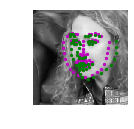

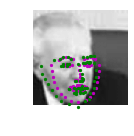

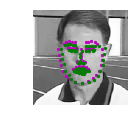

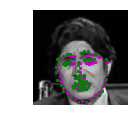

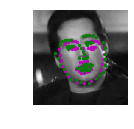

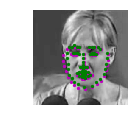

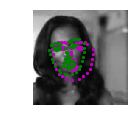

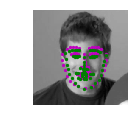

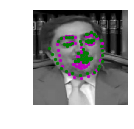

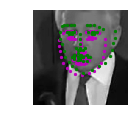

In [108]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data# get the image from it's wrapper
        image = image.cpu()
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        print(image.shape)
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [104]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 
1. 优化算法: 我选用的是Adam优化算法, 因为它综合了momentum和RMSprop的优势, 既不易陷入函数的局部极小值, 又有学习率下降的功能, 最后能够较好的收敛到函数的最小值.
2. 损失函数: 我选用的是均方差损失 MSELoss. 这是因为,通过对问题的分析,我们想要的效果是预测的特征点接近于真实的特征点,这是一个回归问题, 而 MSELoss 是回归问题中常用的损失函数, 而且正适用于我们的问题,当预测点位置与特征点位置越近时,损失函数值越小,反之则越大.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
- 根据之前的学习经验,我认为不需要构造较大或较深的网络,所以我找到了2012年提出的Alexnet网络结构,并根据其进行修改.
- 仿照Alexnet结构 (前面的卷积层进行提取图像特征, 后面的全连接层进行预测), 我构造了2个卷积层+2个全连接层的网络结构. 卷积核分别为5x5和3x3, 网络具体结构在`models.py`中.
- 为了防止过拟合, 在第一个卷积层后面添加了dropout层

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:
1. batch_size=64. 这是因为我另写了`train.py`脚本用于在GPU主机上进行训练, 根据显存的占用率, batch_size=64时显存占用2G左右.
2. epochs=100. 这是因为我放在服务器上托管训练,每50个epoch保存一次权重. 将epochs值设置大些, 训练中途可随时停止,并调用可视化测试函数观察测试结果.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.06430574  0.072432   -0.09331609  0.02751087  0.05451716]
 [ 0.16349734 -0.10312696  0.15821572  0.1863286  -0.09598743]
 [ 0.07084478 -0.0149496  -0.1027557  -0.136475    0.14962143]
 [ 0.21389462 -0.03536074  0.02626314 -0.1228985   0.03562038]
 [-0.07468661 -0.01354649 -0.20822869 -0.20800607  0.00511116]]
(5, 5)


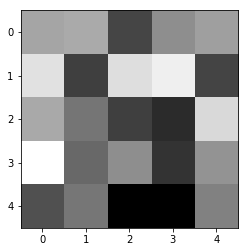

In [106]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data
weights1 = weights1.cpu()
w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

float64
(224, 224)
float32
(5, 5)


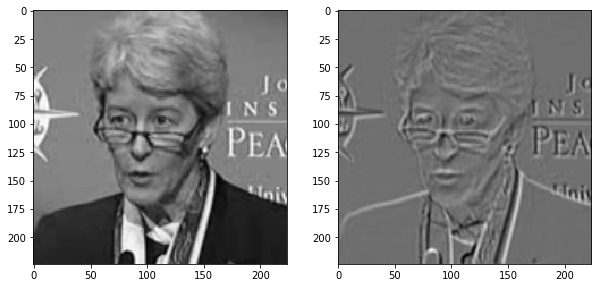

In [107]:
import cv2
# load test data
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)
batch_size = 20
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)
data = next(iter(test_loader))
test_image = data["image"][0]
test_image = test_image.cpu()
test_image = test_image.numpy()
# print(test_image.size())
test_image = np.squeeze(np.transpose(test_image, (1, 2, 0)))

#fig
fig = plt.figure(figsize=(10,20))
fig.add_subplot(1,2,1)
# 显示测试图片
plt.imshow(test_image,"gray")

weight = net.conv1.weight.data[0]
weight = weight.cpu()
w = np.squeeze(weight.numpy())
print(test_image.dtype)
print(test_image.shape)

print(w.dtype)
print(w.shape)
out = cv2.filter2D(test_image, -1, w)
fig.add_subplot(1,2,2)
plt.imshow(out, cmap='gray')
##TODO: load in and display any image from the transformed test dataset
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here
- 如上所示,我选择了第一个卷积核来测试图像的结果. 
- 这个卷积核提取了图像中较为简单的特征.
- 从图像上来看,它检测到了图像中的边缘信息(梯度变化较大的位置)

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!